In [1]:
import numpy as np
def get_csc_inner(X, R, K, reset=True):
    """
    creates the CSC representation for a single cue

    inputs:
        - X is a [T x 1] vector of observations
        - R is a [T x 1] vector of rewards
        - K (int) is the memory duration (how long you remember observations)
    outputs:
        - Z is [T x K], Z[t][0] is 1 if X[t] == 1, and Z[t][1] == 1 if X[t-1] == 1, Z[t][2] == 1 if X[t-2] == 1, and so on...
    """

    Z = []
    z_stim = np.zeros(K)
    last_r = 0
    for (x,r) in zip(X,R):
        z_stim = np.roll(z_stim, shift=-1)
        if x == 1:
            z_stim[-1] = 1
        if reset and (x != 0 or last_r != 0):
            z_stim = np.zeros(K)
            if x == 1:
                z_stim[-1] = 1
        last_r = r
        Z.append(z_stim.copy())
    return np.vstack(Z)

def get_csc_representation(X, R, K, reset=True):
    """
    creates the CSC representation for all cues

    inputs:
        - X is a [T x ncues] matrix of observations from an entire experiment
            - T is the total number of time steps
        - R is a [T x 1] vector of rewards from an entire experiment
        - K is the memory duration
        - reset (bool) indicates whether to zero-out the CSC following a reward
    returns:
        - Z [T x K*ncues] matrix of CSC representations (one per cue)
    """

    Zs = []
    for i in range(X.shape[1]):
        Z = get_csc_inner(X[:,i], R, K=K, reset=reset)
        Zs.append(Z)
    return np.hstack(Zs)

    # vis the csc represent


In [2]:

def wCombined(D, ncues, reward_times, gamma):
    """
    Compute the true value weights for all cues.

    Parameters:
    - D: int, total number of features in the CSC representation.
    - ncues: int, number of cues.
    - reward_times: list, reward time for each cue.
    - gamma: float, discount factor.

    Returns:
    - wtrue: list, true value weights for all cues.
    """

    max_reward_time = max(reward_times)

    wtrue_all = []

    for i in range(ncues):
        w_cue = [gamma ** j for j in range(reward_times[i] + 1)]
        padding = [0] * (max_reward_time - reward_times[i])
        wtrue_all.extend(padding + w_cue)

    return wtrue_all




<ipython-input-3-15d006d5524a>:75: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  ax.legend(handles + ['Reward'], [f'Cue {i+1}' for i in range(self.ncues)] + ['Reward'], loc='upper right')


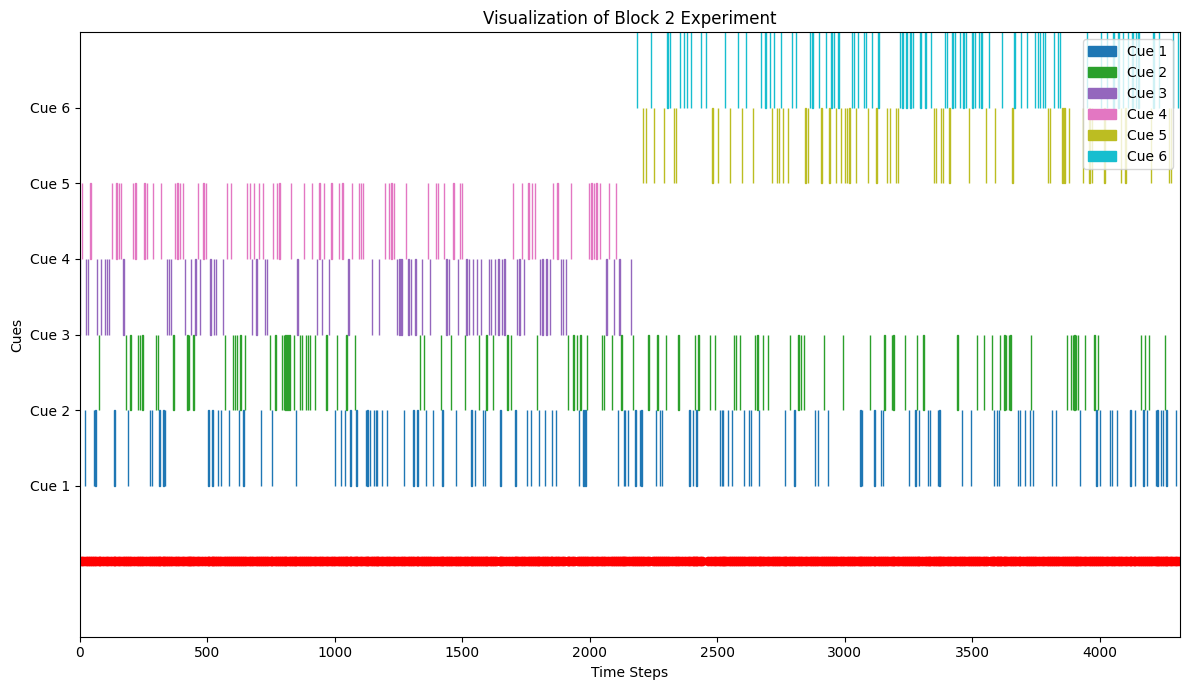

In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
np.random.seed(42)

class Block2PavlovTiming(Dataset):
    def __init__(self, ntrials=10000, include_reward=True):
        self.include_reward = include_reward
        self.ncues = 6
        self.reward_times = [3, 4, 5, 6, 5, 6]  # reward times for the 6 cues
        self.ntrials = ntrials
        self.make_trials()

    def make_trial(self, cue, iti):
        isi = self.reward_times[cue]
        trial = np.zeros((iti + isi + 2, self.ncues + 1))
        trial[iti, cue] = 1.0
        trial[iti + isi, -1] = 1.0
        return trial

    def make_trials(self):
        half_trials = self.ntrials // 2

        # First half: cues [1,2,3,4]
        cues_first_half = np.random.choice([0, 1, 2, 3], half_trials)

        # Second half: cues [1,2,5,6]
        cues_second_half = np.random.choice([0, 1, 4, 5], self.ntrials - half_trials)
        cues = np.concatenate((cues_first_half, cues_second_half))

        # ITI per trial
        ITIs = np.random.geometric(p=0.5, size=self.ntrials)

        # make trials
        self.trials = [self.make_trial(cue, iti) for cue, iti in zip(cues, ITIs)]

    def __getitem__(self, index):
        X = self.trials[index][:,:-1]
        y = self.trials[index][:,-1:]

        if self.include_reward:
            X = np.hstack([X, y])

        return (torch.from_numpy(X), torch.from_numpy(y))

    def __len__(self):
        return len(self.trials)

    def plot_trials(self, ntrials=800):
        fig, ax = plt.subplots(figsize=(12, 7))
        cmap = plt.get_cmap('tab10', self.ncues)

        trials_to_display = self.trials[:ntrials]
        total_time_steps = sum([trial.shape[0] for trial in trials_to_display])

        trial_data = np.vstack(trials_to_display)

        for t in range(total_time_steps):
            for c in range(self.ncues):
                if trial_data[t, c] == 1:
                    ax.add_patch(plt.Rectangle((t, c), 1, 1, color=cmap(c)))

        reward_y = -1
        for t in range(total_time_steps):
            if trial_data[t, -1] == 1:
                ax.plot(t + 0.5, reward_y, 'ro')

        handles = [plt.Rectangle((0, 0), 1, 1, color=cmap(i)) for i in range(self.ncues)]
        ax.legend(handles + ['Reward'], [f'Cue {i+1}' for i in range(self.ncues)] + ['Reward'], loc='upper right')
        ax.set_xlim(0, total_time_steps)
        ax.set_ylim(-2, self.ncues)
        ax.set_title("Visualization of Block 2 Experiment")
        ax.set_xlabel("Time Steps")
        ax.set_ylabel("Cues")
        ax.set_yticks(range(self.ncues))
        ax.set_yticklabels([f'Cue {i+1}' for i in range(self.ncues)])
        plt.tight_layout()
        plt.show()

E_block2 = Block2PavlovTiming(ntrials=500)
E_block2.plot_trials(500)



In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence

class ValueRNN(nn.Module):
    def __init__(self, input_size=4, output_size=1, hidden_size=25,
                 num_layers=1, gamma=0.9):
      super(ValueRNN, self).__init__()

      self.gamma = gamma
      self.input_size = input_size
      self.output_size = output_size
      self.hidden_size = hidden_size
      self.num_layers = num_layers
      self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
      self.value = lambda x: torch.sum(x,2)[:,:,None]
      # self.value = nn.Linear(in_features=hidden_size, out_features=output_size, bias=True)

    def forward(self, x):
        x, (hx, cx) = self.rnn(x)
        if type(x) is torch.nn.utils.rnn.PackedSequence:
            x, output_lengths = pad_packed_sequence(x, batch_first=False)
        x = F.relu(x)
        return self.value(x), (hx, cx)

    def freeze_weights(self, substr=None):
        for name, p in self.named_parameters():
            if substr is None or substr in name:
                p.requires_grad = False

    def unfreeze_weights(self):
        for name, p in self.named_parameters():
            p.requires_grad = True

    def n_parameters(self):
        return sum([p.numel() for p in self.parameters()])

    def get_features(self, name):
        def hook(mdl, input, output):
            self.features[name] = output
        return hook

    def save_weights_to_path(self, path):
        torch.save(self.state_dict(), path)

    def load_weights_from_path(self, path):
        self.load_state_dict(torch.load(path))

    def prepare_to_gather_activity(self):
        if hasattr(self, 'handle'):
            self.handle.remove()
        self.features = {}
        self.hook = self.get_features('hidden')
        self.handle = self.rnn.register_forward_hook(self.hook)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.figsize'] = [3.0, 3.0]
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

def plot_loss(scores):
    plt.plot(scores)
    plt.xlabel('# epochs')
    plt.ylabel('loss')

clr1 = np.array([198, 57, 255])/255
clr2 = np.array([0, 137, 64])/255
clr3 = np.array([242, 90, 41])/255
clr4 = np.array([84, 170, 255])/255
COLORS = [clr1, clr2, clr3, clr4]

def plot_trials(trials):
    clrs = COLORS[:(trials[0].shape[1]-1)]
    clrs += ['k']

    plt.figure(figsize=(2,4))
    ymax = 0.8
    for t in range(len(trials)):
        for c in range(trials[t].shape[1]):
            yinds = np.where(trials[t][:,c])[0]
            for y in yinds:
                plt.plot(y*np.ones(2), [-t, -t+ymax], '-', color=clrs[c])
        xmx = trials[t].shape[0]
        plt.plot([0, xmx], -t + np.zeros(2), 'k-', alpha=0.25)
    plt.yticks(ticks=[], labels=[])
    plt.xlabel('time $\\rightarrow$')
    plt.ylabel('trials $\\rightarrow$')
    plt.gca().spines.get('left').set_visible(False)

def plot_predictions(responses, key='value', gamma=1.0):
    clrs = COLORS[:responses[0]['X'].shape[1]]
    if key == 'value':
        discount = lambda rs_future: np.sum([r * gamma ** (tau+1) if ~np.isnan(r) else 0.0 for tau,r in enumerate(rs_future)])

    plt.figure(figsize=(2,4))
    ymax = 0.85 # for spacing in plots
    tstep = max([trial[key].max()-trial[key].min() for trial in responses]) # for spacing in plots
    for t, trial in enumerate(responses):
        X = trial['X']
        rs = trial['y']
        t_stim = trial['iti']-1
        if trial['isi'] is not None:
            t_rew = trial['isi'] + t_stim
        else:
            t_rew = None
        xs = np.arange(X.shape[0])
        y = trial[key]
        clr = clrs[trial['cue']]

        plt.plot(xs, -t*tstep + np.zeros(len(xs)), 'k-', alpha=0.25)
        plt.plot(t_stim*np.ones(2), [-t*tstep, -t*tstep + tstep*ymax], '-', color=clr)
        if t_rew is not None:
            plt.plot(t_rew*np.ones(2), [-t*tstep, -t*tstep + tstep*ymax], 'k-', alpha=0.25)

        # plot prediction
        plt.plot(xs[:len(y)], 0.95*ymax*y - t*tstep, '.-', color=clr)

        if key == 'value':
            R = np.array([r + discount(rs[(i+1):]) for i,r in enumerate(rs)])
            plt.plot(xs[:-1], tstep*ymax*R[1:] - t*tstep, 'k--', alpha=0.9)

    plt.xlabel('time $\\rightarrow$')
    plt.ylabel(key)
    plt.yticks(ticks=[], labels=[])
    plt.gca().spines.get('left').set_visible(False)
    plt.show()

def plot_hidden_activity(responses, key='Z', align_offset=1):
    clrs = COLORS[:responses[0]['X'].shape[1]]
    msz = 5
    for trial in responses:
        t_stim = trial['iti']
        if trial['isi'] is not None:
            t_rew = trial['isi'] + t_stim
        else:
            t_rew = None
        clr = clrs[trial['cue']]

        Z = trial[key]
        plt.plot(Z[t_stim,0], Z[t_stim,1], 's', color=clr, markersize=5)
        plt.plot(Z[:,0], Z[:,1], '.-', color=clr, markersize=msz, alpha=0.5)
        if t_rew is not None:
            plt.plot(Z[t_rew,0], Z[t_rew,1], '*', color=clr, markersize=5)
        # plt.plot(Z[trial.iti+1+align_offset,0], Z[trial.iti+1+align_offset,1], '*', markersize=6, color=h.get_color())
    plt.plot(0, 0, 'k+')
    plt.xlabel('$z_1$')
    plt.ylabel('$z_2$')
    plt.gca().set_xticks([]);
    plt.gca().set_yticks([]);
    plt.axis('equal')
    plt.show()

In [11]:
import numpy as np
from copy import deepcopy
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

def pad_collate(batch):
    (xx, yy) = zip(*batch)
    x_lens = [len(x) for x in xx]

    X = pad_sequence(xx, batch_first=True, padding_value=0)
    y = pad_sequence(yy, batch_first=True, padding_value=0)

    X = torch.transpose(X, 1, 0) # n.b. no longer batch_first
    y = torch.transpose(y, 1, 0)
    X = X.float()
    y = y.float()
    return X, y, x_lens

def make_dataloader(experiment, batch_size):
    return DataLoader(experiment, batch_size=batch_size, collate_fn=pad_collate)

def train_epoch(model, dataloader, loss_fn, optimizer=None, handle_padding=True):
    " if optimizer is None, no gradient steps are taken "
    if optimizer is not None:
        model.train()
    else:
        model.eval()
    train_loss = 0
    losses = []
    n = 0

    for batch, (X, y, x_lengths) in enumerate(dataloader):
        if handle_padding:
            X = pack_padded_sequence(X, x_lengths, enforce_sorted=False)

        V, (hx,cx) = model(X)

        V_hat = V[:-1,:,:]
        V_next = V[1:,:,:]
        V_target = y[1:,:,:] + model.gamma*V_next.detach()

        if handle_padding:
            loss = 0.0
            for i,l in enumerate(x_lengths):
                loss += loss_fn(V_hat[:,i][:l], V_target[:,i][:l])
            loss /= len(x_lengths)
        else:
            loss = loss_fn(V_hat, V_target)

        # Backpropagation
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss = loss.item()
        train_loss += loss
        losses.append(loss)
        n += 1
    train_loss /= n
    return train_loss, losses

def train_model(model, dataloader, lr, nchances=4, epochs=5000, handle_padding=True, print_every=10):
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []
    scores = np.nan * np.ones((epochs+1,))
    scores[0], _ = train_epoch(model, dataloader, loss_fn, None, handle_padding)
    best_score = scores[0]
    best_weights = deepcopy(model.state_dict())
    nsteps_increase = 0
    try:
        for t in range(epochs):
            if t % print_every == 0:
                print(f"Epoch {t}, {scores[t]:0.4f}")
            scores[t+1], cur_loss = train_epoch(model, dataloader, loss_fn, optimizer, handle_padding)
            losses.append(cur_loss)
            if scores[t+1] < best_score:
                best_score = scores[t+1]
                best_weights = deepcopy(model.state_dict())
            if scores[t+1] > scores[t]:
                if nsteps_increase > nchances:
                    print("Stopping.")
                    break
                nsteps_increase += 1
            else:
                nsteps_increase = 0
    except KeyboardInterrupt:
        pass
    finally:
        scores = scores[~np.isnan(scores)]
        model.load_state_dict(best_weights)
        print(f"Done! Best loss: {best_score}")

        return scores, losses

def probe_model(model, dataloader):
    responses = []
    model.prepare_to_gather_activity()
    with torch.no_grad():
      for batch, (X, y, x_lengths) in enumerate(dataloader):
        X_batch = X.numpy()
        y_batch = y.numpy()
        V_batch, _ = model(X)
        V_batch = V_batch.numpy()
        Z_batch = model.features['hidden'][0].detach().numpy()

        for j in range(X_batch.shape[1]):
            X = X_batch[:x_lengths[j],j,:]
            Z = Z_batch[:x_lengths[j],j,:]
            y = y_batch[:x_lengths[j],j,:]
            V = V_batch[:x_lengths[j],j,:]

            V_hat = V[:-1,:]
            V_next = V[1:,:]
            r = y[1:,:]
            V_target = r + model.gamma*V_next
            rpe = V_target - V_hat

            cue = np.where(X[:,:-1].sum(axis=0))[0][0]
            iti = np.where(X.sum(axis=1))[0][0]
            if y.sum() > 0:
                isi = np.where(y)[0][0] - iti
            else:
                isi = None

            data = {'cue': cue, 'iti': iti, 'isi': isi,
                    'X': X, 'y': y, 'value': V, 'rpe': rpe,
                    'Z': Z}
            responses.append(data)
    return sorted(responses, key=lambda data: data['iti'])

In [12]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [13]:
def TD_with_corrected_Vt(Z, R, gamma, alpha):
    T, D = Z.shape
    w = np.zeros(D)
    Vt = []
    rpes = []

    for t in range(T-1):
        V_curr = np.dot(w, Z[t])
        Vt.append(V_curr)

        rpe = R[t] + gamma * np.dot(w, Z[t+1]) - V_curr
        rpes.append(rpe)
        w += alpha * rpe * Z[t]

    Vt.append(np.dot(w, Z[-1]))
    rpes.append(R[-1] - Vt[-1])

    return w, np.array(Vt), np.array(rpes)

#Generate the E_block2 experiment
ntrials = 10000
E_block2 = Block2PavlovTiming(ntrials=ntrials)
trials = E_block2.trials

X_exp = []
R_exp = []

for trial in trials:
    X = trial[:, :-1]
    R = trial[:, -1:]
    X_exp.append(X)
    R_exp.append(R)

X_exp = np.vstack(X_exp)
R_exp = np.vstack(R_exp)

Z_special = get_csc_representation(X_exp, R_exp, max(E_block2.reward_times) + 1)
cues = [np.where(trial[:, :-1].sum(axis=0))[0][0] for trial in E_block2.trials]

gamma = 0.8
alpha = 0.1
w, Vt, rpes = TD_with_corrected_Vt(Z_special, R_exp, gamma, alpha)
trial_lengths = [trial.shape[0] for trial in trials]

split_rpes = np.split(rpes, np.cumsum(trial_lengths)[:-1])

mean_squared_rpes_per_trial = [np.mean(np.square(rpe_trial)) for rpe_trial in split_rpes]

mean_squared_rpes_per_trial[:10]


[0.125,
 0.1111111111111111,
 0.11662857142857143,
 0.08164,
 0.061534269090909095,
 0.07119140256799998,
 0.1,
 0.09669670857142858,
 0.09071111111111112,
 0.07520855111111112]

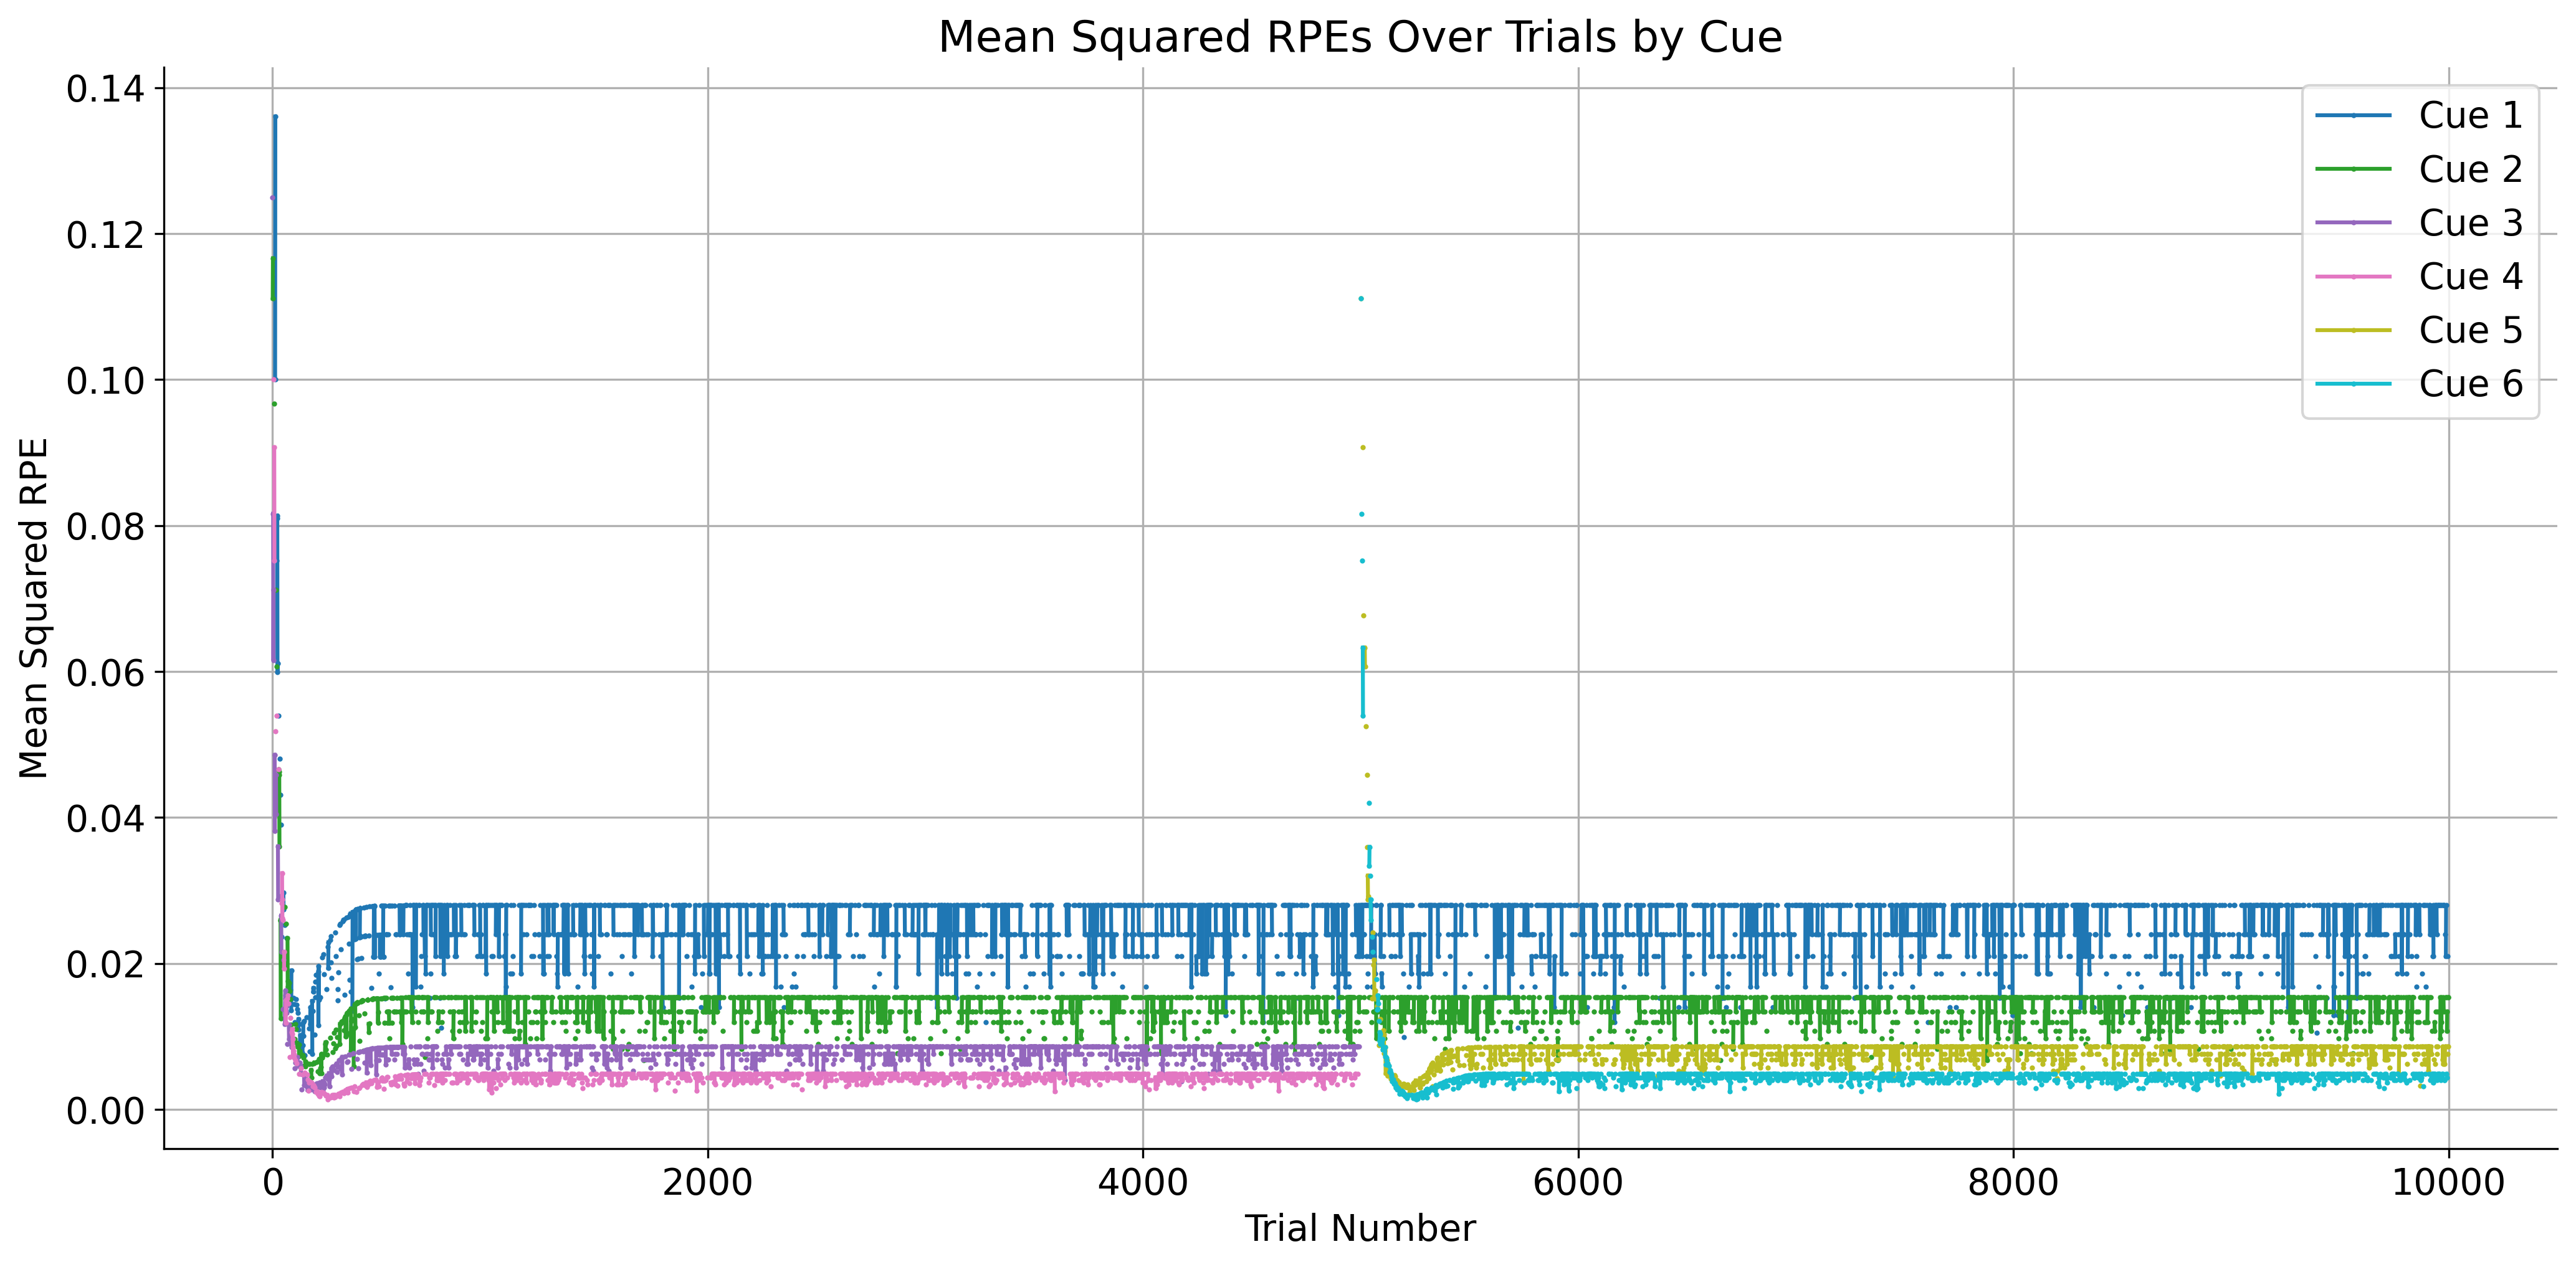

In [14]:
cues_per_trial = [np.where(trial[:, :-1].sum(axis=0) > 0)[0][0] for trial in trials]

plt.figure(figsize=(14, 7))
cmap = plt.get_cmap('tab10', len(np.unique(cues_per_trial)))
trial_nums = range(len(mean_squared_rpes_per_trial))

for cue in np.unique(cues_per_trial):
    cue_rpes = [rpe if cues_per_trial[i] == cue else None for i, rpe in enumerate(mean_squared_rpes_per_trial)]
    plt.plot(trial_nums, cue_rpes, label=f'Cue {cue + 1}', color=cmap(cue), marker='.', linestyle='-', markersize=2)

plt.xlabel('Trial Number')
plt.ylabel('Mean Squared RPE')
plt.title('Mean Squared RPEs Over Trials by Cue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()





In [15]:
import numpy as np
import matplotlib.pyplot as plt

ntrials = 10000
E_block2 = Block2PavlovTiming(ntrials=ntrials)
#E_block2.plot_trials(ntrials=ntrials)

#Extract cues for each trial
cues = []
for trial in E_block2.trials:
    cue_sums = trial[:, :-1].sum(axis=0)
    active_cue = np.where(cue_sums > 0)[0][0]
    cues.append(active_cue)

dataloader = make_dataloader(E_block2, batch_size=1)
hidden_size = 75
gamma = 0.8
input_size = E_block2.ncues + int(E_block2.include_reward)
model = ValueRNN(input_size=input_size, hidden_size=hidden_size, gamma=gamma)
lr = 0.01
scores, rnn_losses = train_model(model, dataloader, lr=lr, epochs=1)
rnn_losses = smooth(rnn_losses[0], 20)

X_exp = [trial[:, :-1] for trial in E_block2.trials]
R_exp = [trial[:, -1:] for trial in E_block2.trials]
Z_special = get_csc_representation(np.vstack(X_exp), np.vstack(R_exp), max(E_block2.reward_times) + 1)
w, Vt, rpes = TD_with_corrected_Vt(Z_special, np.vstack(R_exp), gamma, alpha)

timesteps_per_trial = [trial.shape[0] for trial in E_block2.trials]
split_points = np.cumsum(timesteps_per_trial)[:-1]

# Split the RPEs based on the determined split points
rpes_per_trial = np.split(rpes, split_points)

csc_losses = [np.mean(np.square(rpe)) for rpe in rpes_per_trial]




Epoch 0, 0.1899
Done! Best loss: 0.017938183652976294


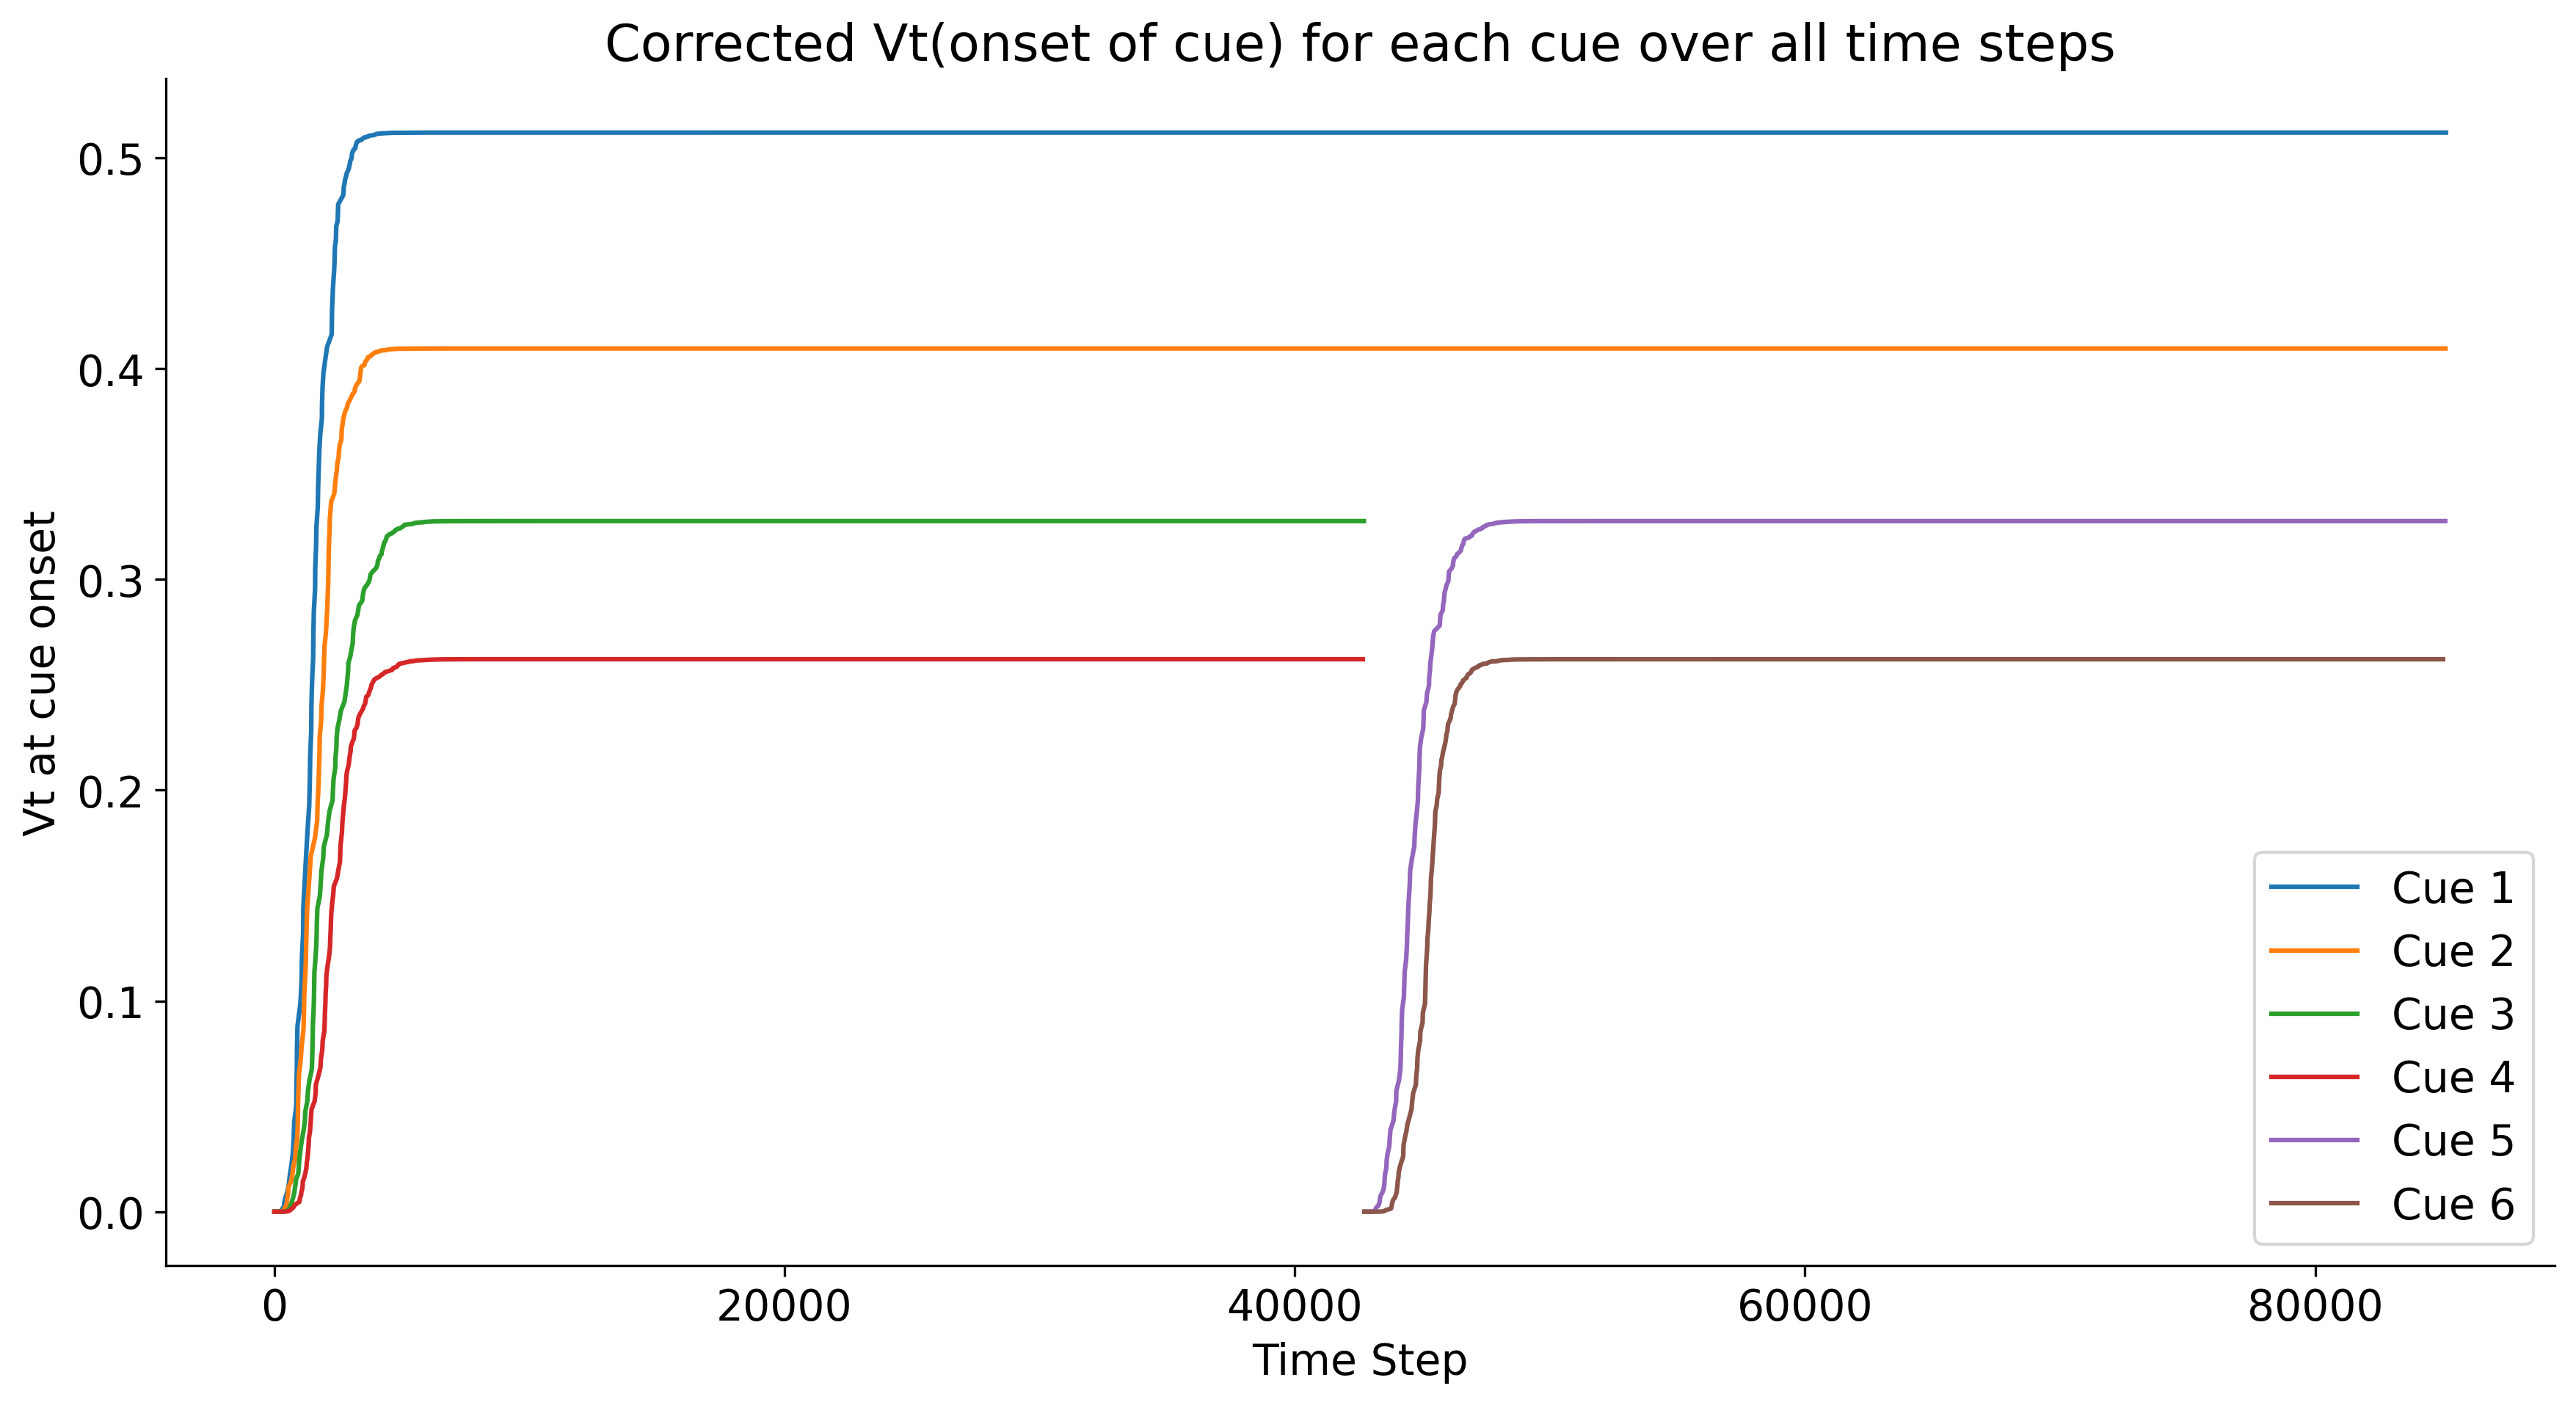

In [16]:
X_exp_array = np.vstack(X_exp)

# Plot Vt for all time steps at the onset of each cue using Vt values
plt.figure(figsize=(14, 7))
for cue_idx in range(len(E_block2.reward_times)):
    cue_onsets = np.where(X_exp_array[:, cue_idx] == 1)[0]
    plt.plot(cue_onsets, Vt[cue_onsets], label=f'Cue {cue_idx + 1}')
plt.xlabel('Time Step')
plt.ylabel('Vt at cue onset')
plt.title('Corrected Vt(onset of cue) for each cue over all time steps')
plt.legend()
plt.show()


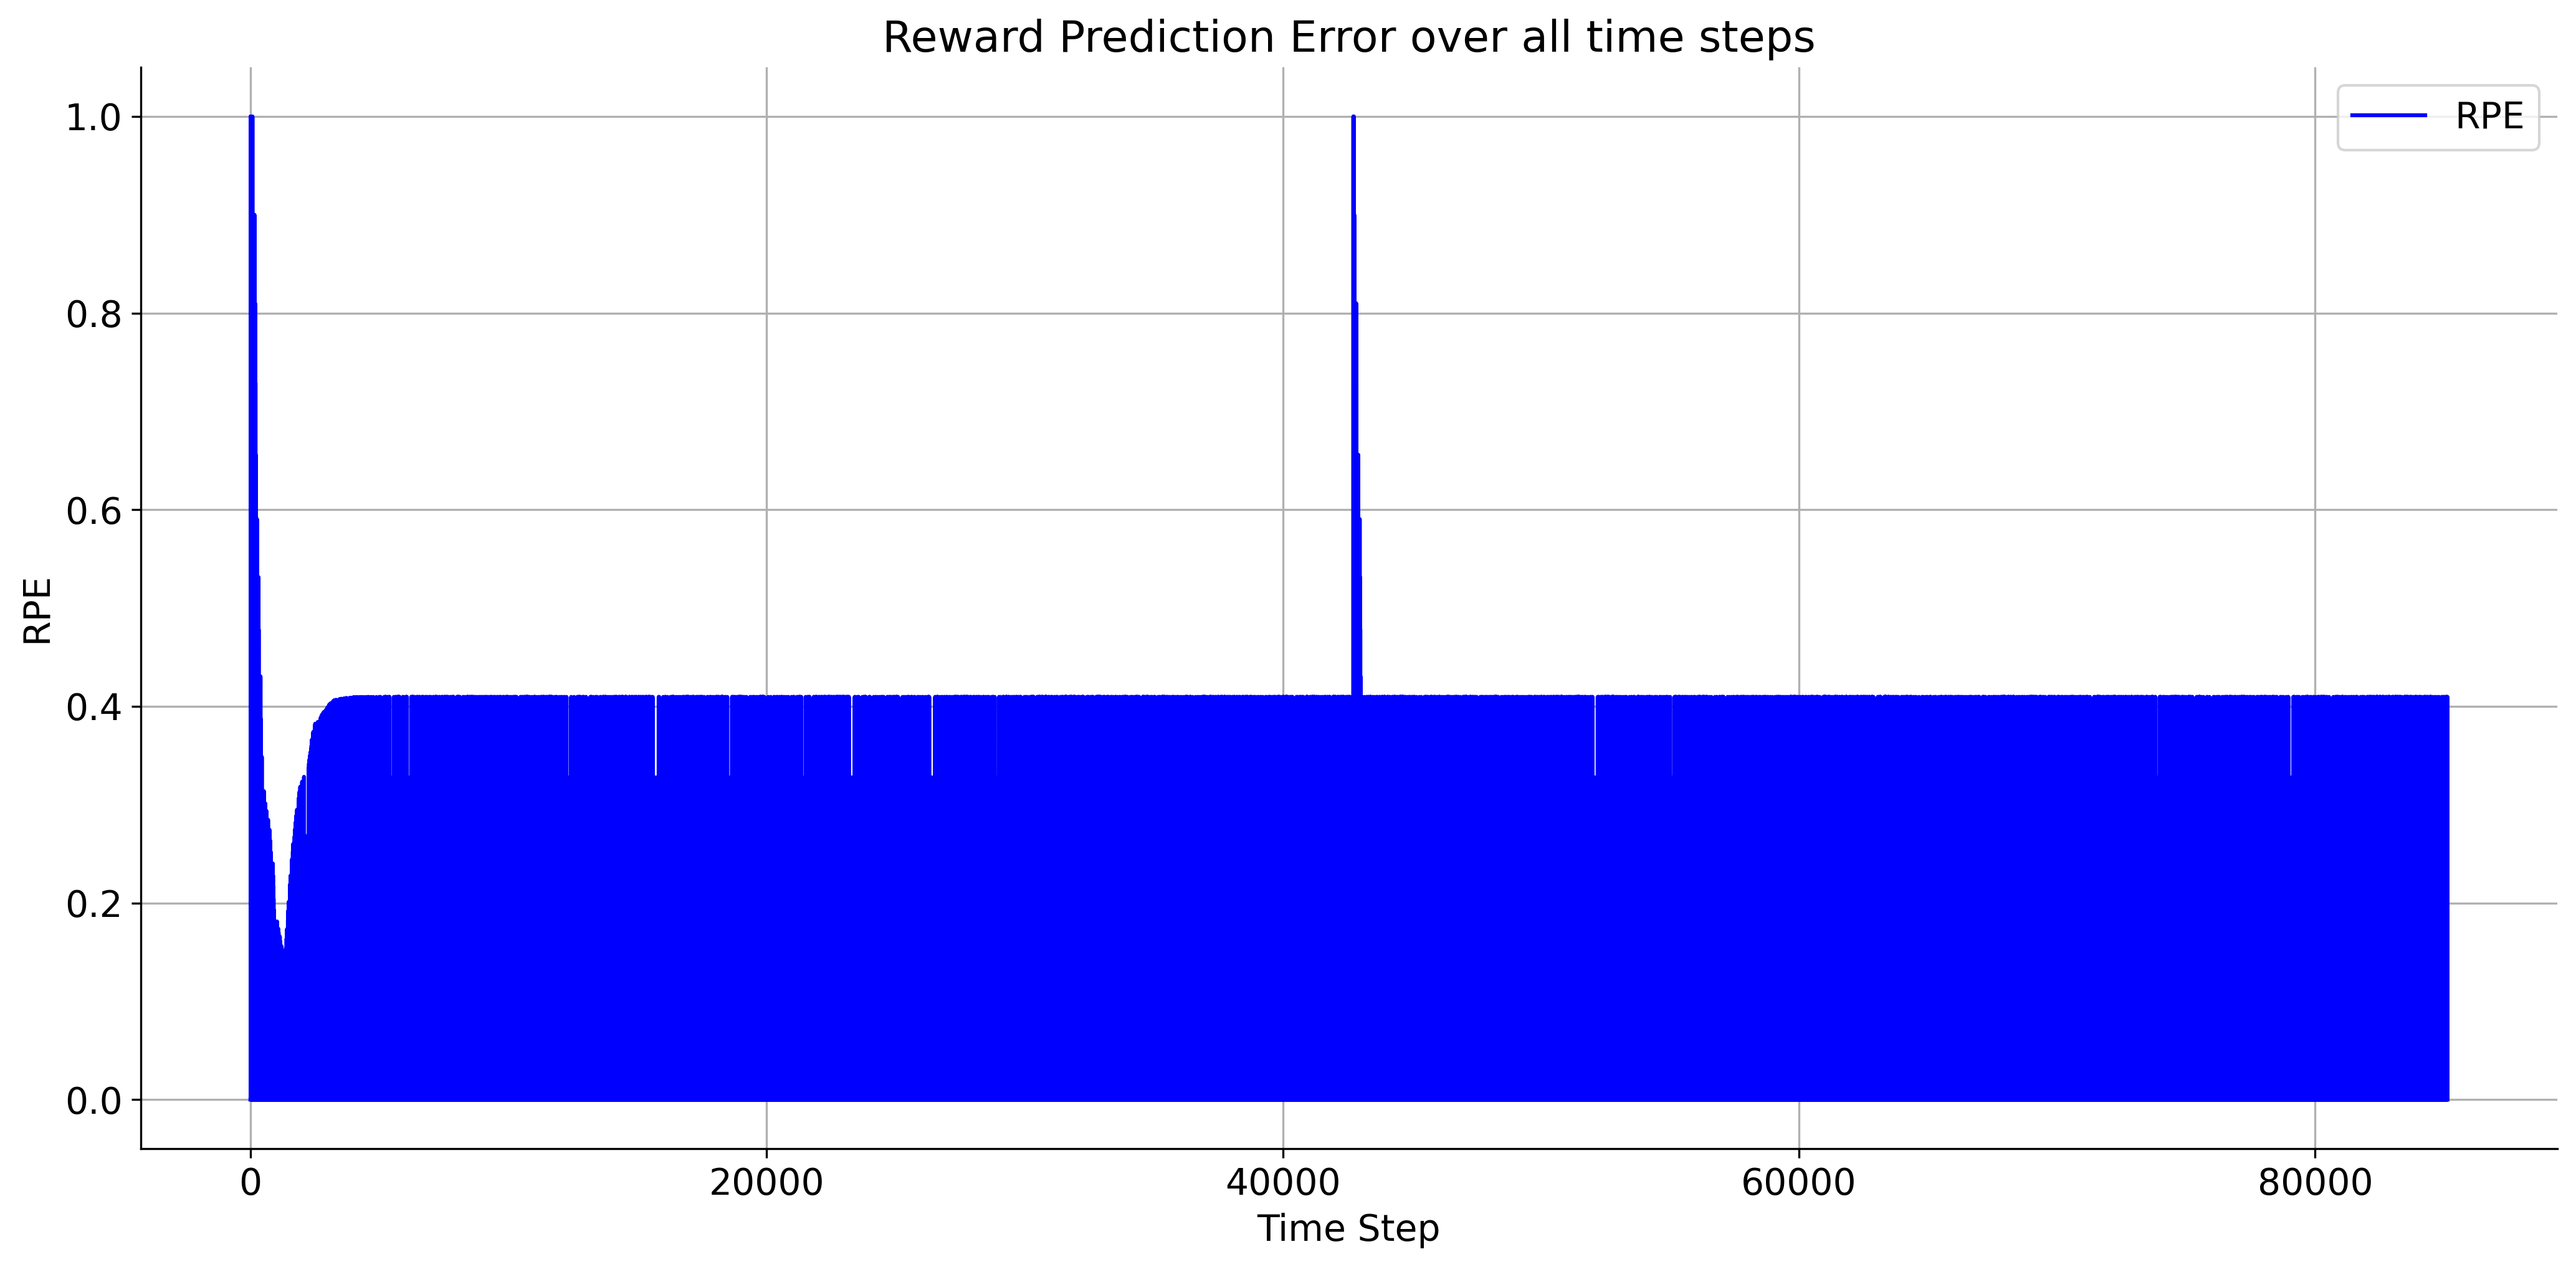

In [17]:
plt.figure(figsize=(14, 7))
plt.plot(rpes, label='RPE', color='blue')
plt.xlabel('Time Step')
plt.ylabel('RPE')
plt.title('Reward Prediction Error over all time steps')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


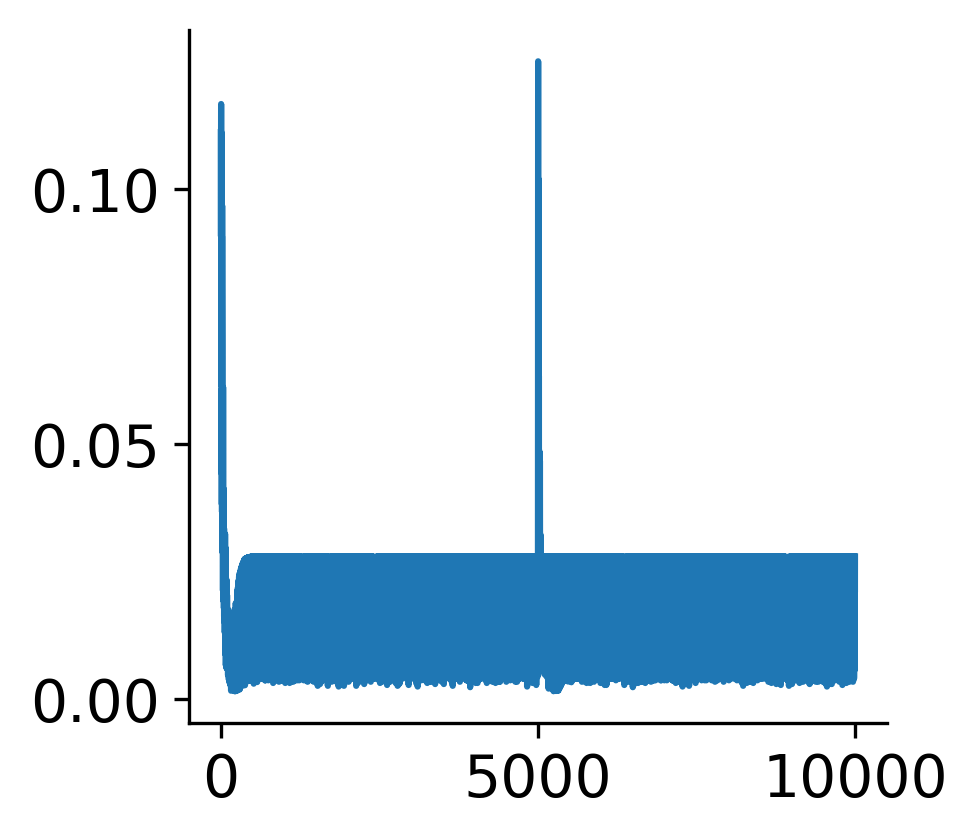

In [18]:
plt.plot(csc_losses)

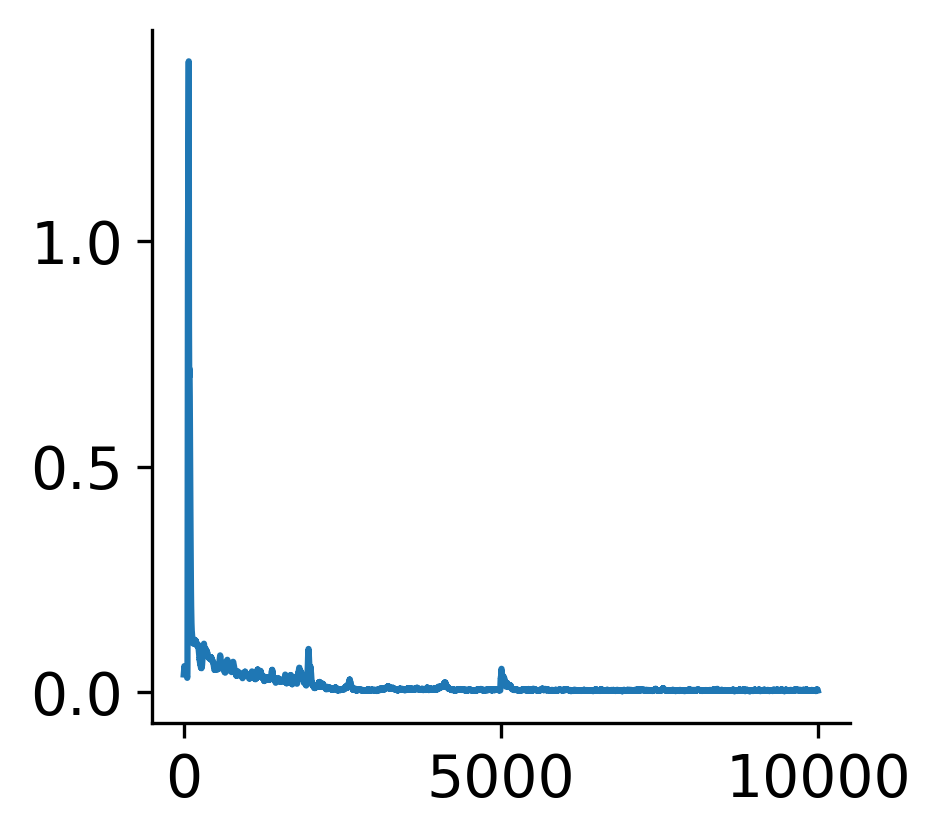

In [19]:
plt.plot(rnn_losses)

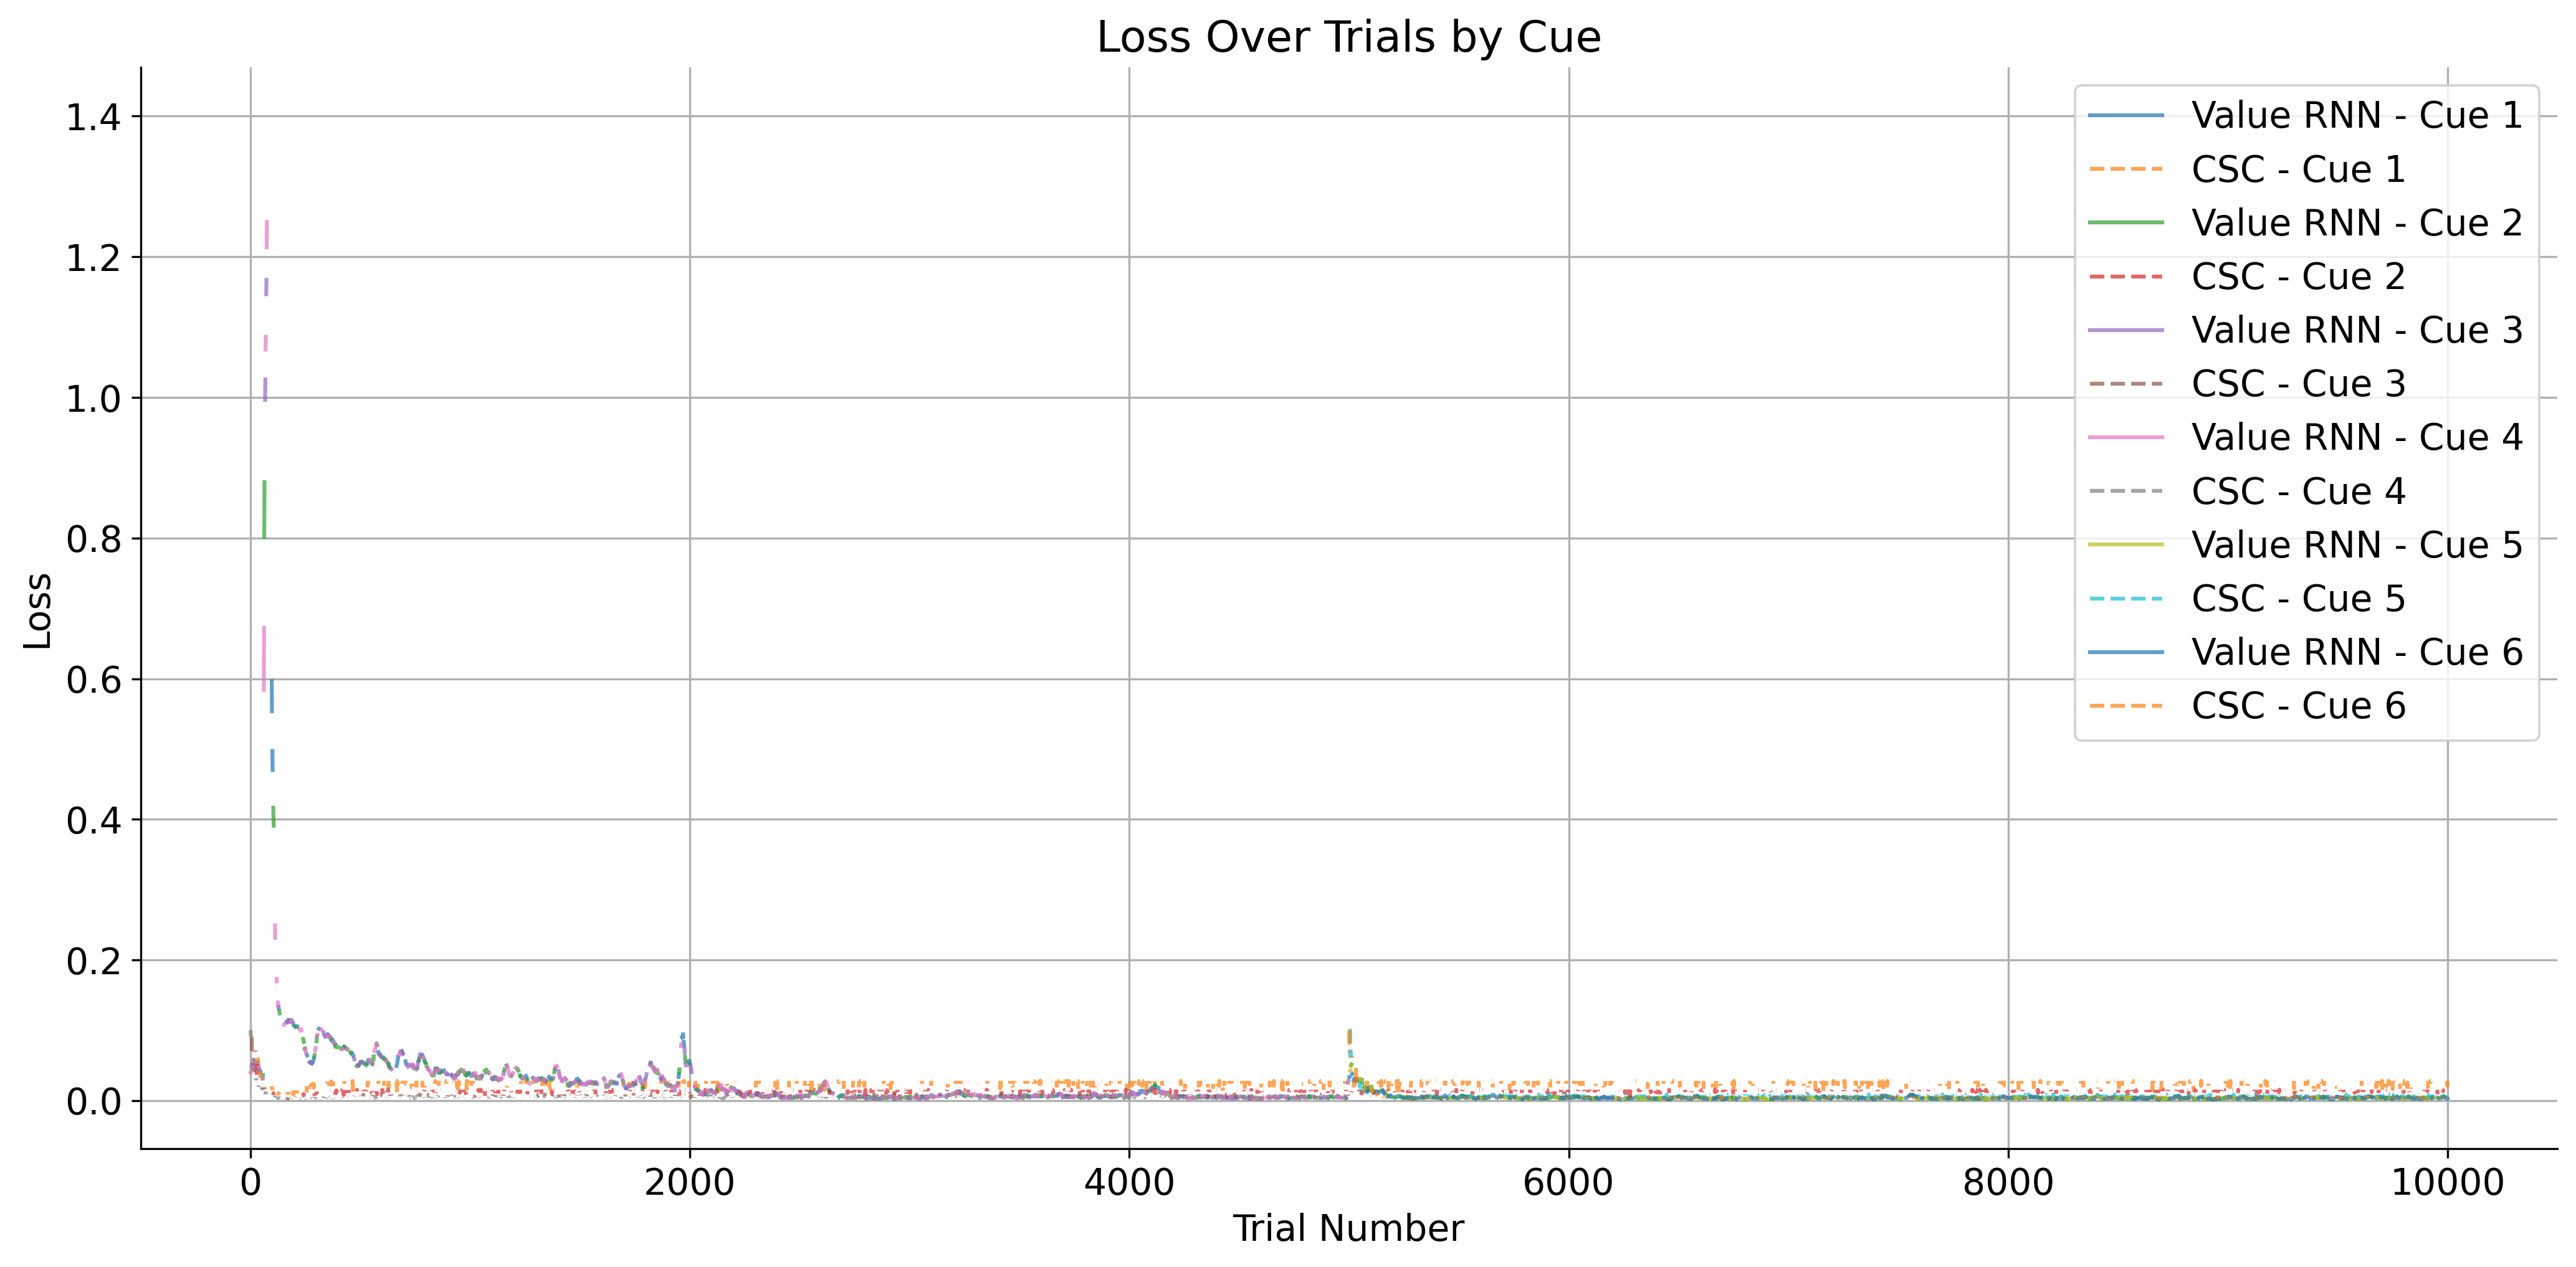

In [23]:
#Plot cue losses for both representations
plt.figure(figsize=(14, 7))
for cue in np.unique(cues):
    rnn_cue_losses = [rnn_losses[i] if cues[i] == cue else np.nan for i in range(ntrials)]
    csc_cue_losses = [csc_losses[i] if cues[i] == cue else np.nan for i in range(ntrials)]
    plt.plot(rnn_cue_losses, label=f'Value RNN - Cue {cue + 1}', linestyle='-', alpha=0.7)
    plt.plot(csc_cue_losses, label=f'CSC - Cue {cue + 1}', linestyle='--', alpha=0.7)

plt.xlabel('Trial Number')
plt.ylabel('Loss')
plt.title('Loss Over Trials by Cue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

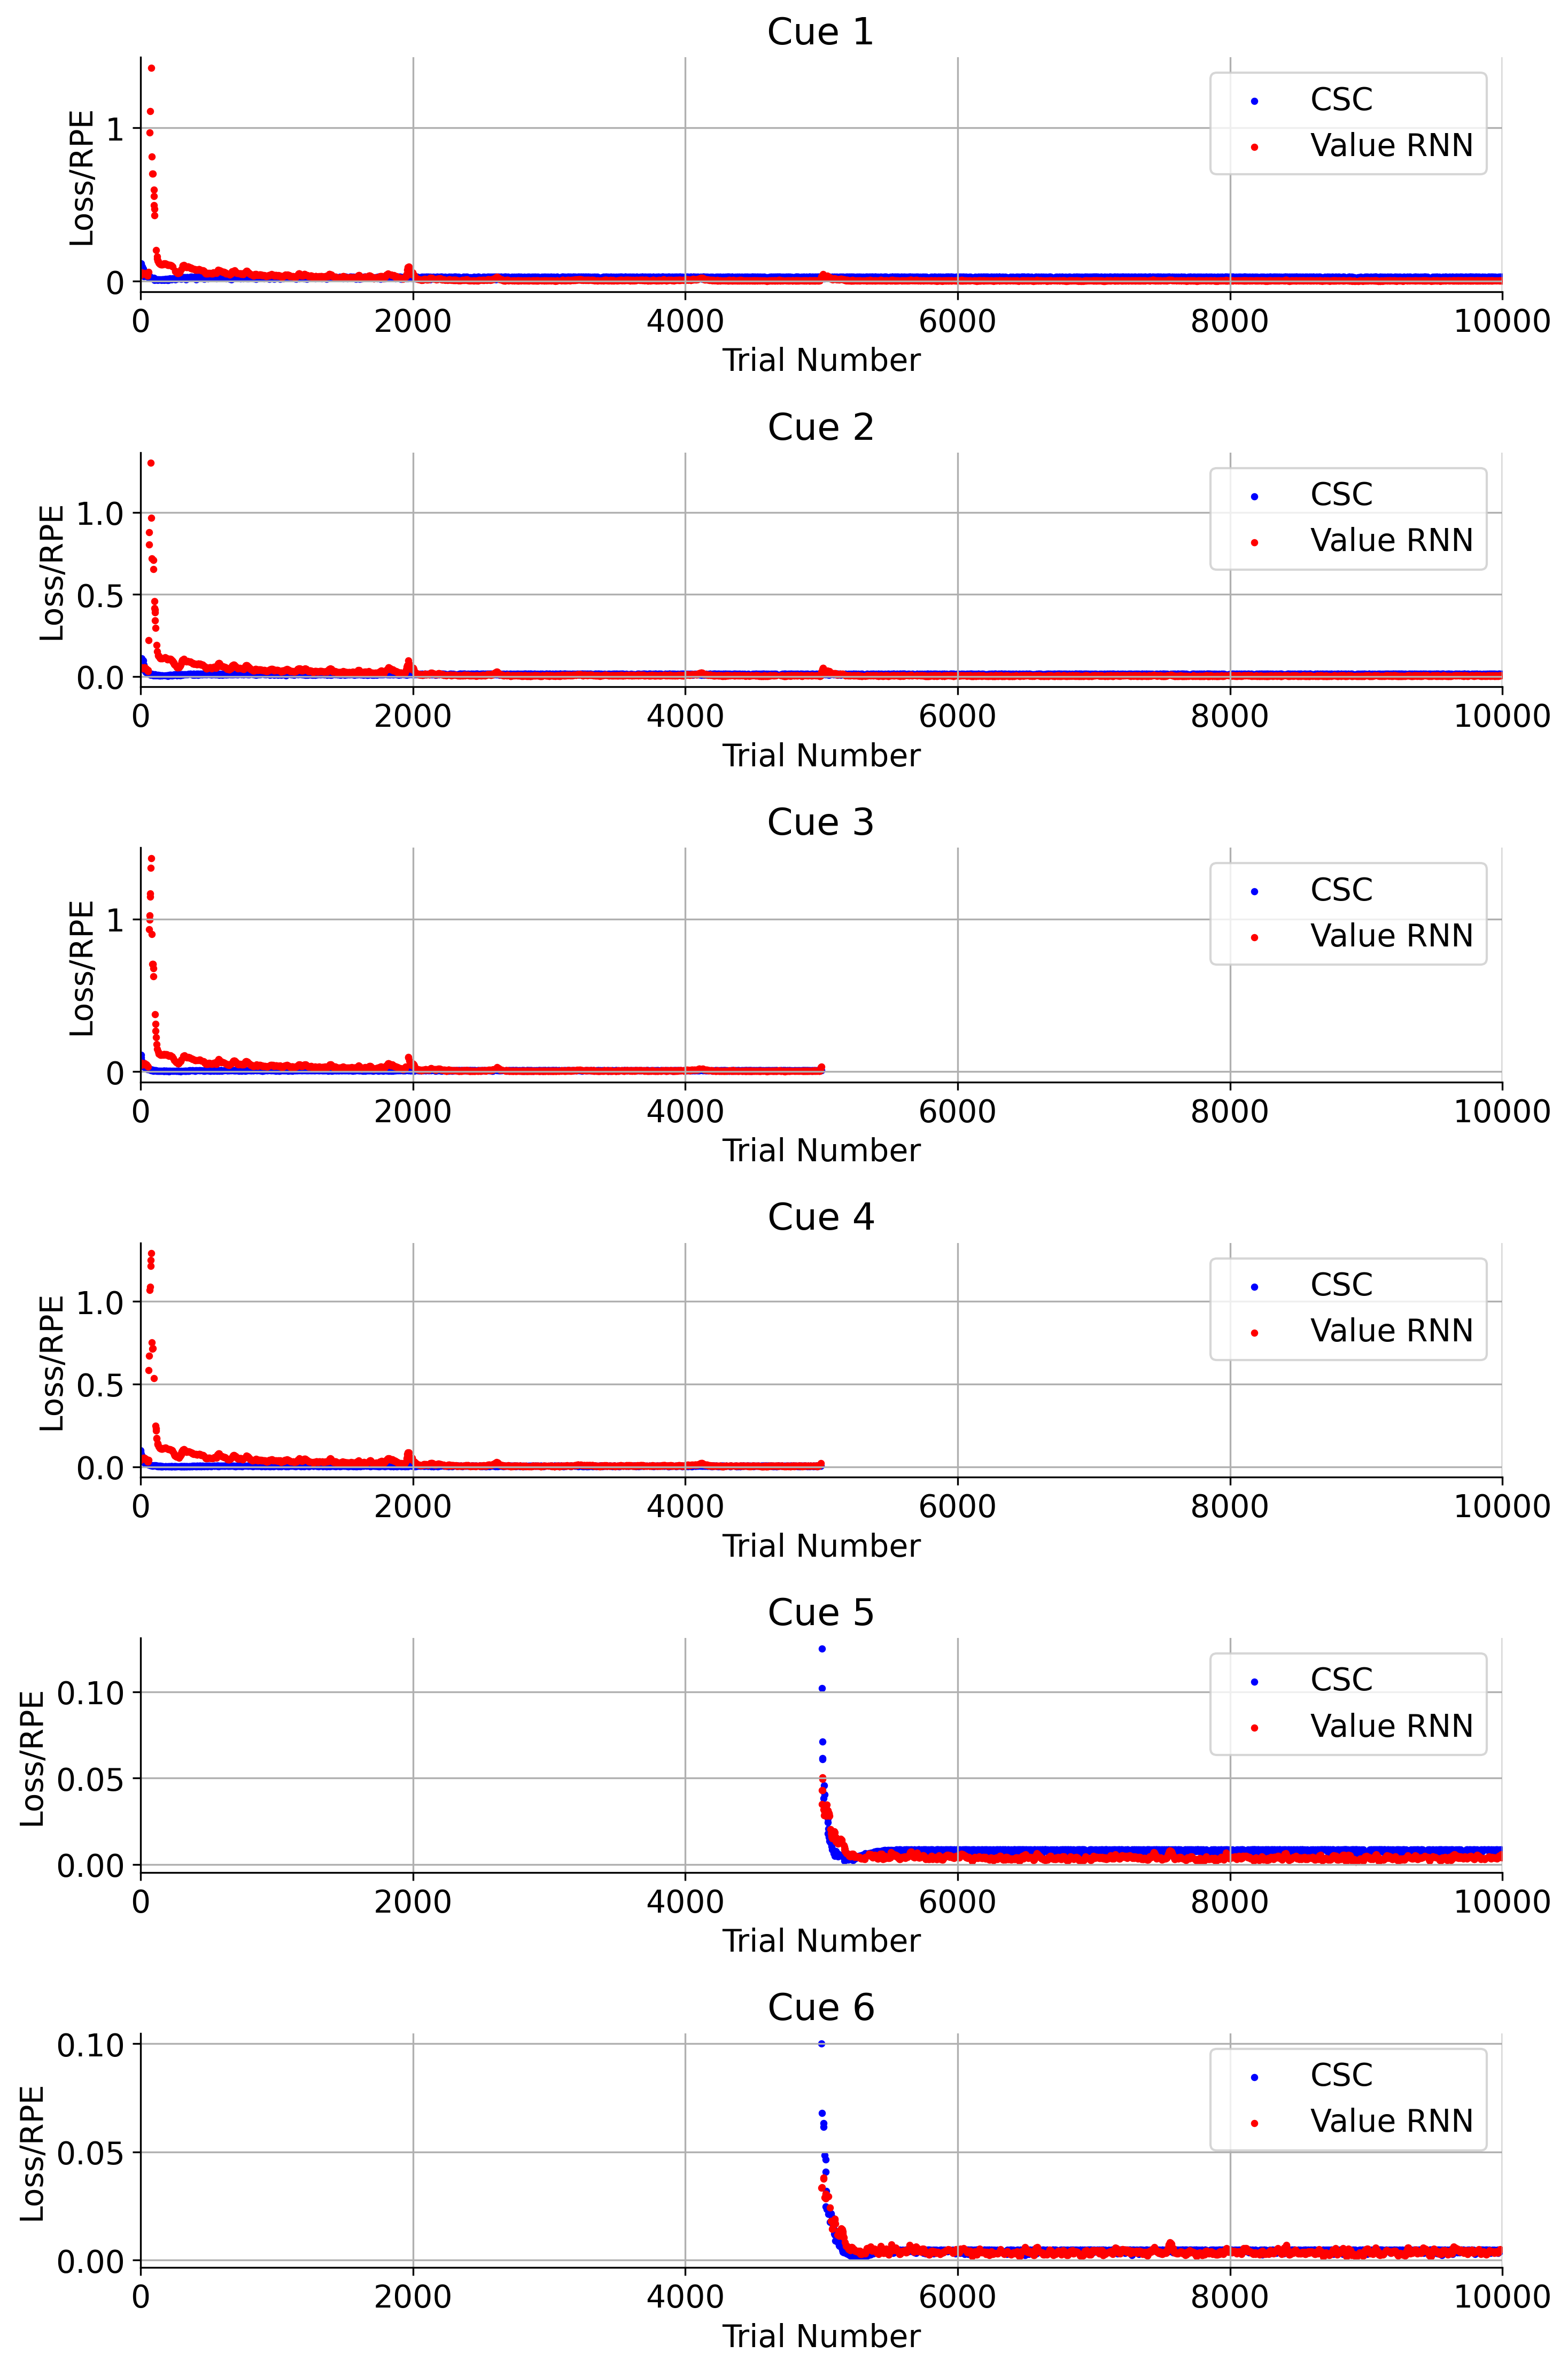

In [22]:
import matplotlib.pyplot as plt

n_cues = 6
n_trials_total = 10000

# Create a base x array for all trials
x = np.arange(n_trials_total)

fig, axes = plt.subplots(nrows=n_cues, ncols=1, figsize=(10, 15))

for cue in range(n_cues):
    # Create mask for the current cue
    mask = np.array(cues) == cue

    axes[cue].scatter(x[mask], np.array(csc_losses)[mask], label='CSC', color='blue', s=5)
    axes[cue].scatter(x[mask], np.array(rnn_losses)[mask], label='Value RNN', color='red', s=5)

    axes[cue].set_xlim([0, n_trials_total]) # ensure x-axis spans all 10,000 trials
    axes[cue].set_title(f'Cue {cue + 1}')
    axes[cue].set_xlabel('Trial Number')
    axes[cue].set_ylabel('Loss/RPE')
    axes[cue].legend()
    axes[cue].grid(True)

plt.tight_layout()
plt.show()



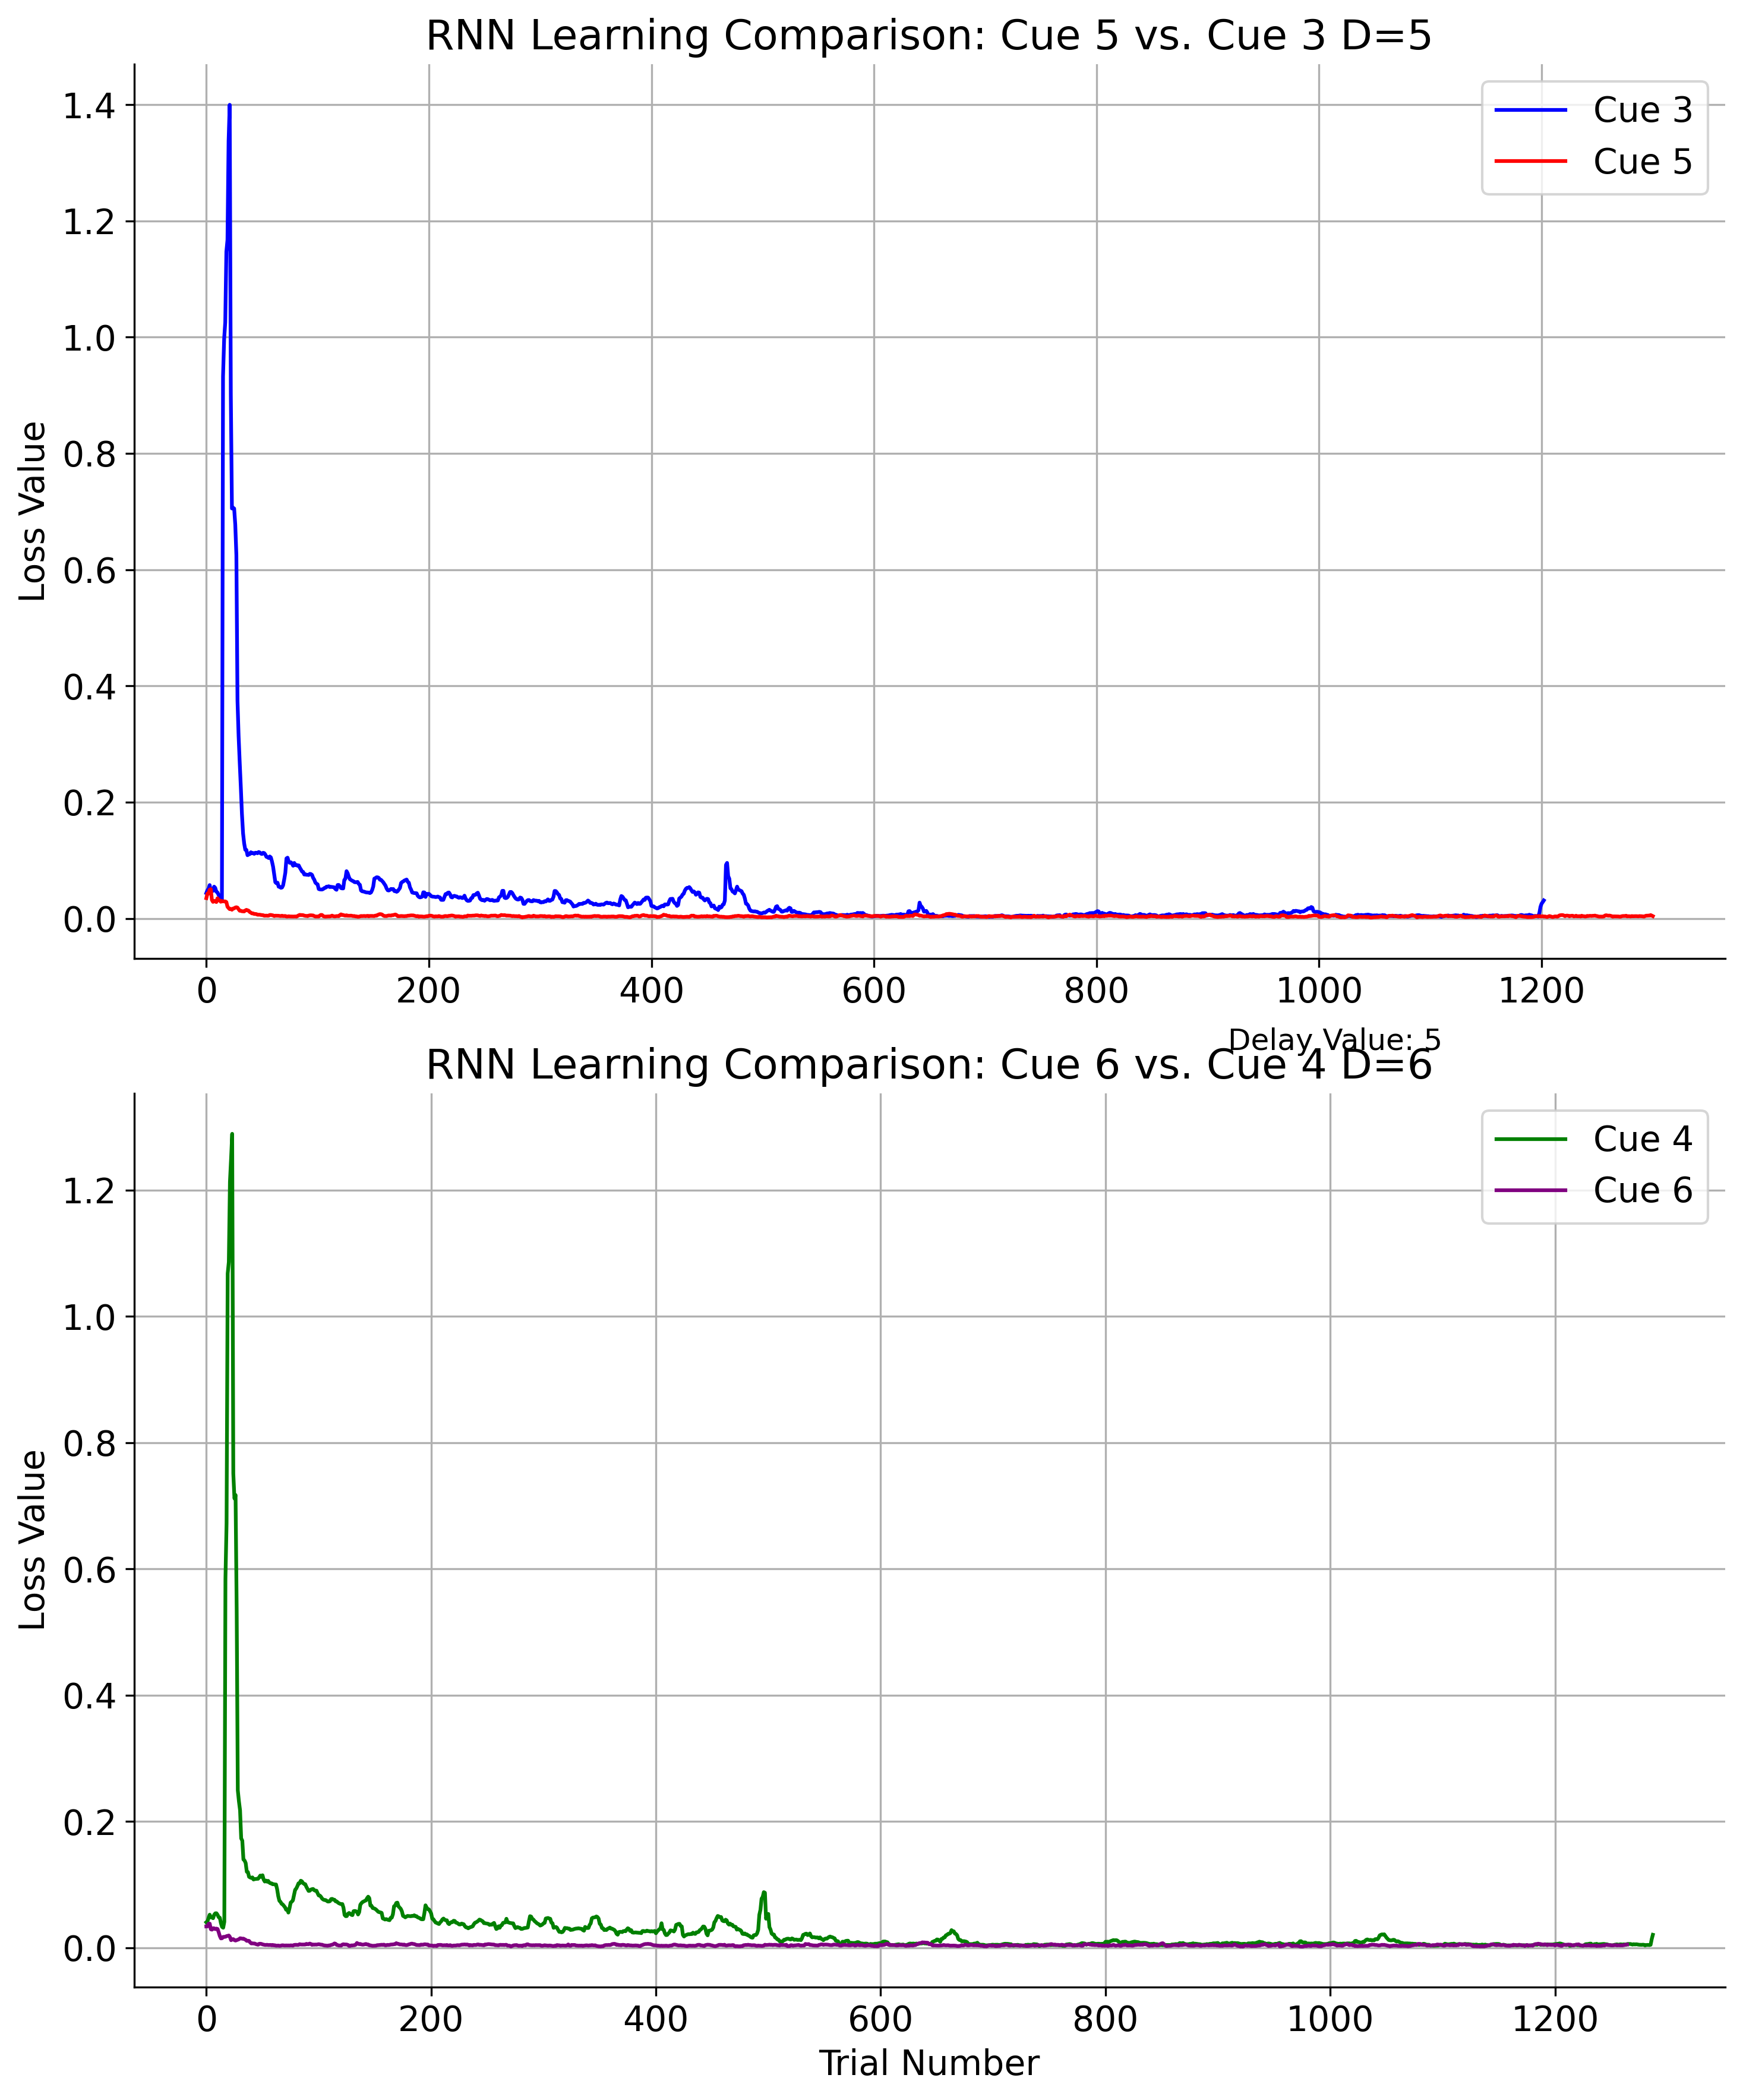

In [24]:
import matplotlib.pyplot as plt

cue3_losses = np.array(rnn_losses)[np.array(cues) == 2]  # cue 3
cue5_losses = np.array(rnn_losses)[np.array(cues) == 4]  # cue 5
cue4_losses = np.array(rnn_losses)[np.array(cues) == 3]  # cue 4
cue6_losses = np.array(rnn_losses)[np.array(cues) == 5]  # cue 6

x_cue3 = np.arange(len(cue3_losses))
x_cue5 = np.arange(len(cue5_losses))
x_cue4 = np.arange(len(cue4_losses))
x_cue6 = np.arange(len(cue6_losses))

fig, axs = plt.subplots(2, 1, figsize=(10, 12))

axs[0].plot(x_cue3, cue3_losses, label='Cue 3', color='blue')
axs[0].plot(x_cue5, cue5_losses, label='Cue 5', color='red')
axs[0].set_title('RNN Learning Comparison: Cue 5 vs. Cue 3 D=5')
axs[0].set_ylabel('Loss Value')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(x_cue4, cue4_losses, label='Cue 4', color='green')
axs[1].plot(x_cue6, cue6_losses, label='Cue 6', color='purple')
axs[1].set_title('RNN Learning Comparison: Cue 6 vs. Cue 4 D=6')
axs[1].set_xlabel('Trial Number')
axs[1].set_ylabel('Loss Value')
axs[1].legend()
axs[1].grid(True)

delay_value = 5
fig.text(0.7, 0.5, f"Delay Value: {delay_value}", fontsize=12)

plt.tight_layout()
plt.show()



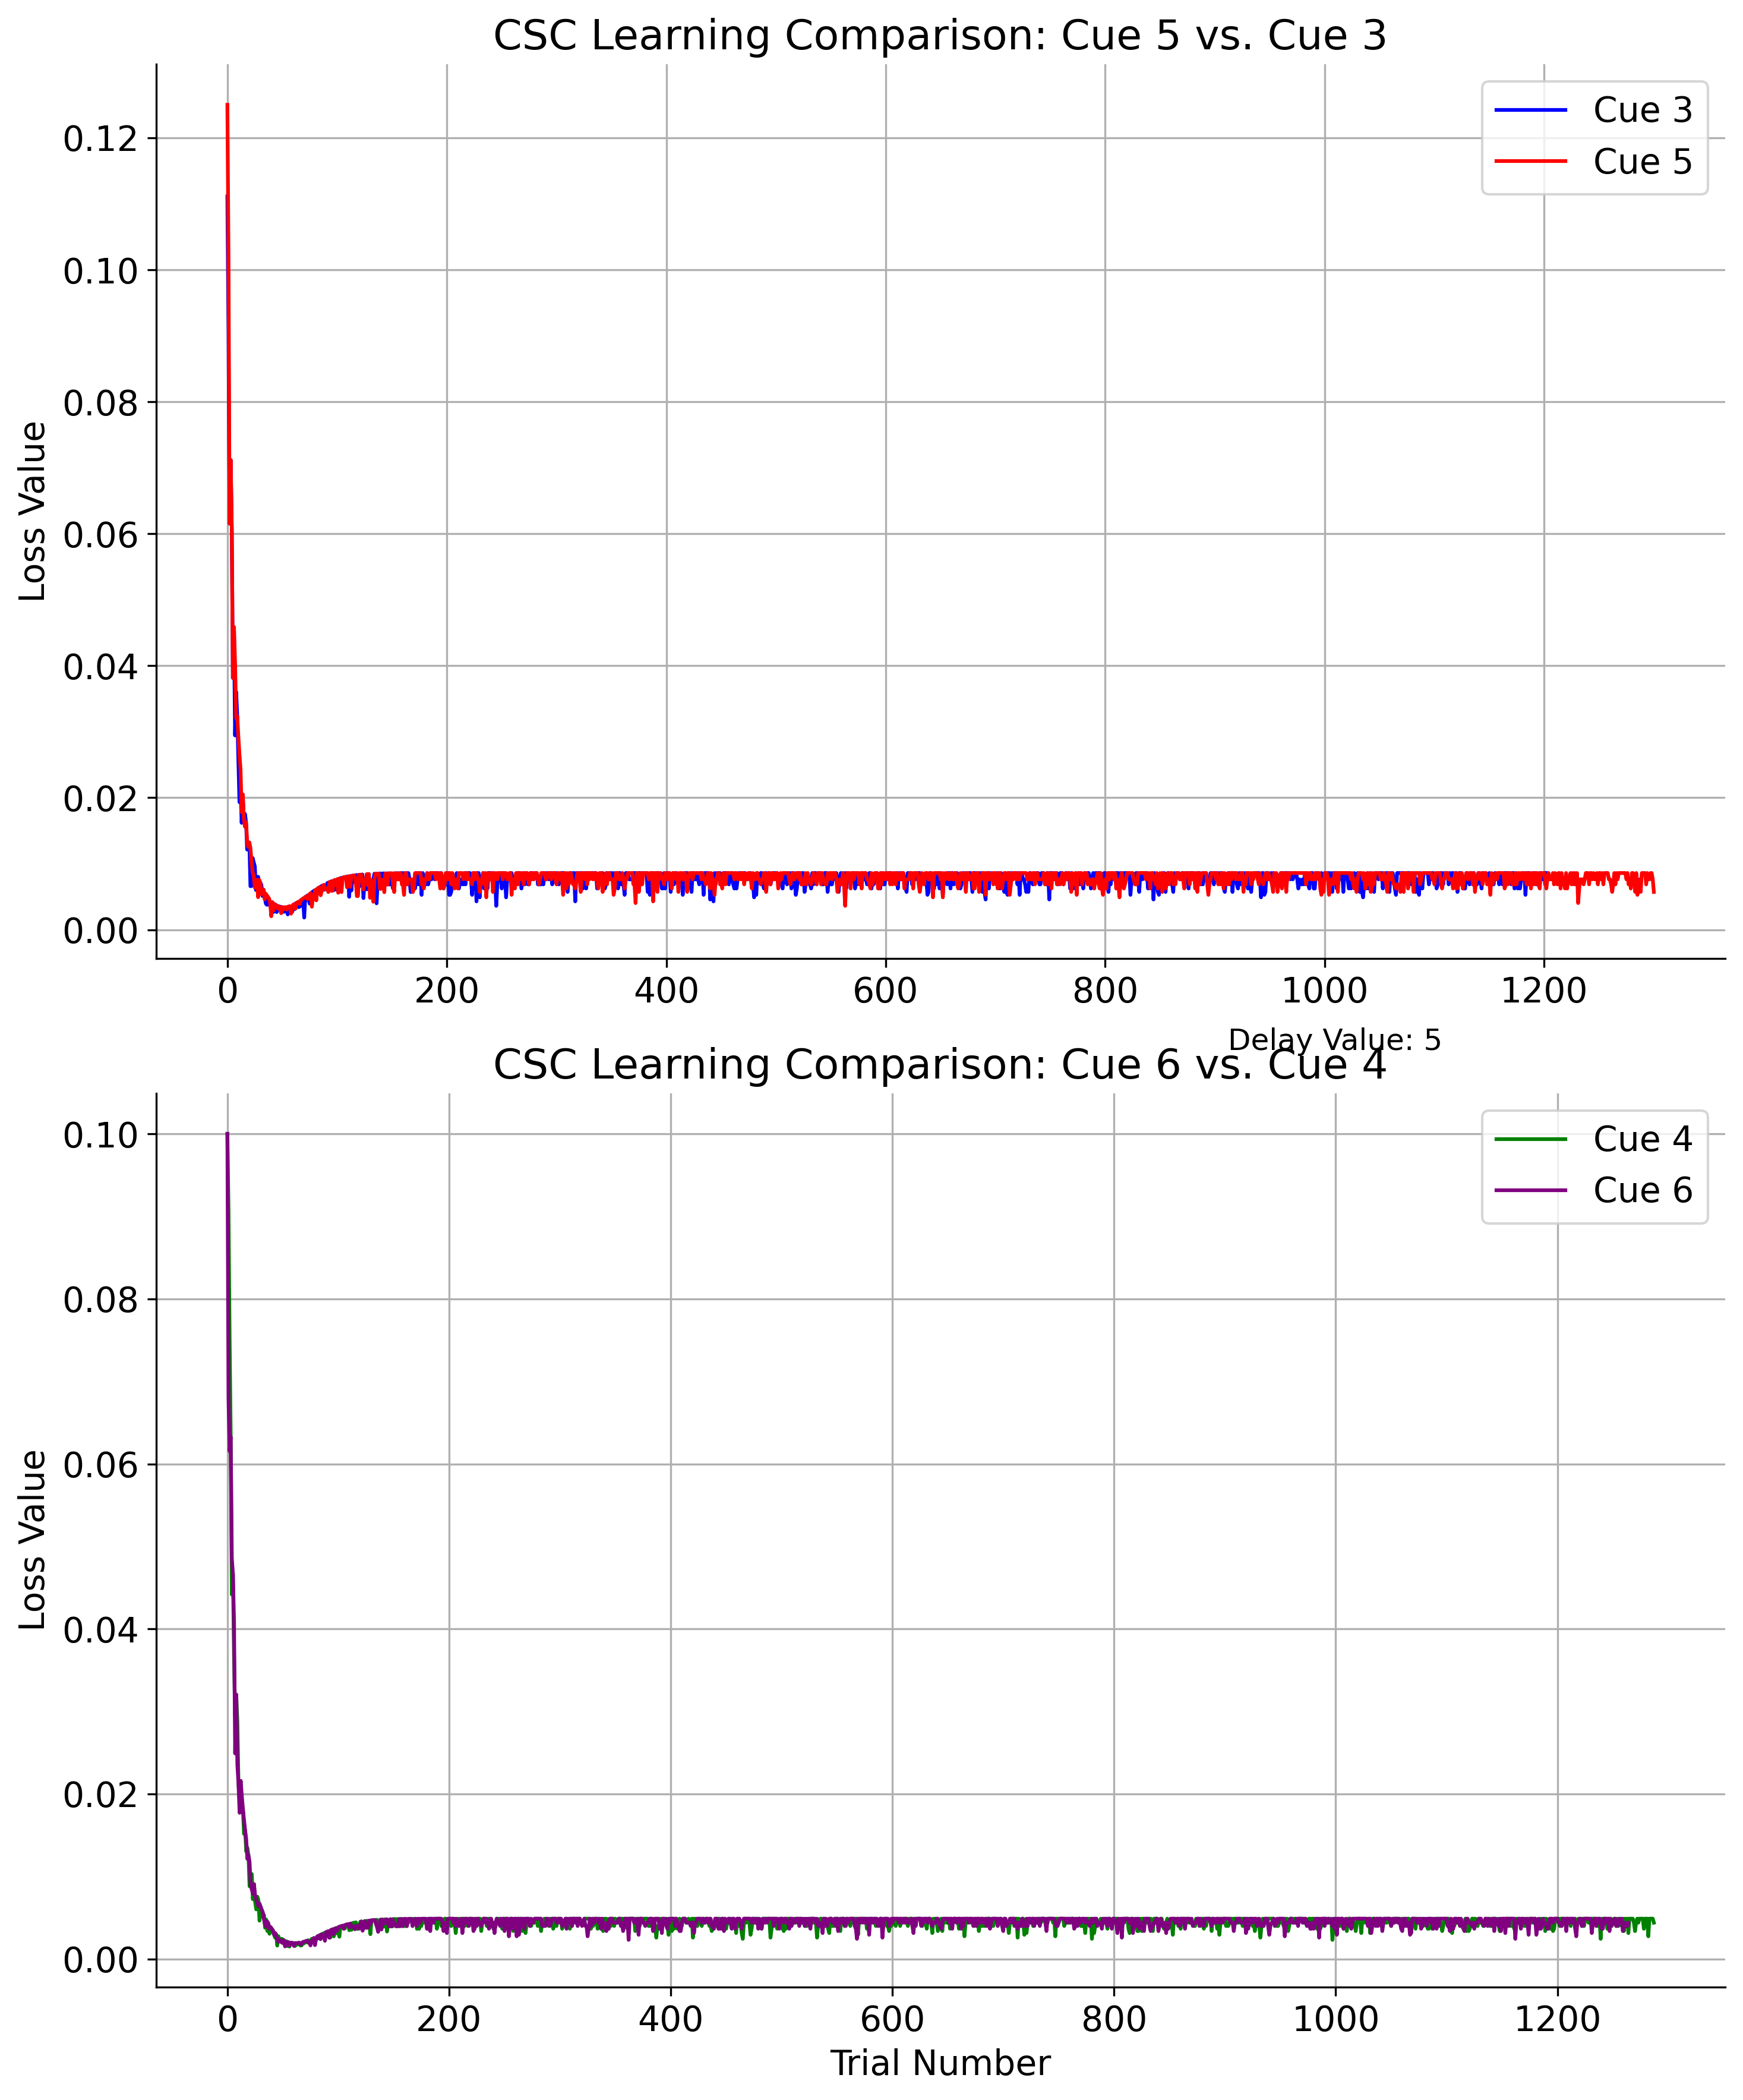

In [25]:
import matplotlib.pyplot as plt


cue3_losses_csc = np.array(csc_losses)[np.array(cues) == 2]
cue5_losses_csc = np.array(csc_losses)[np.array(cues) == 4]
cue4_losses_csc = np.array(csc_losses)[np.array(cues) == 3]
cue6_losses_csc = np.array(csc_losses)[np.array(cues) == 5]

x_cue3 = np.arange(len(cue3_losses_csc))
x_cue5 = np.arange(len(cue5_losses_csc))
x_cue4 = np.arange(len(cue4_losses_csc))
x_cue6 = np.arange(len(cue6_losses_csc))

fig, axs = plt.subplots(2, 1, figsize=(10, 12))

axs[0].plot(x_cue3, cue3_losses_csc, label='Cue 3', color='blue')
axs[0].plot(x_cue5, cue5_losses_csc, label='Cue 5', color='red')
axs[0].set_title('CSC Learning Comparison: Cue 5 vs. Cue 3')
axs[0].set_ylabel('Loss Value')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(x_cue4, cue4_losses_csc, label='Cue 4', color='green')
axs[1].plot(x_cue6, cue6_losses_csc, label='Cue 6', color='purple')
axs[1].set_title('CSC Learning Comparison: Cue 6 vs. Cue 4')
axs[1].set_xlabel('Trial Number')
axs[1].set_ylabel('Loss Value')
axs[1].legend()
axs[1].grid(True)

delay_value = 5
fig.text(0.7, 0.5, f"Delay Value: {delay_value}", fontsize=12)

plt.tight_layout()
plt.show()


In [26]:
class BlockNext1PavlovTiming(Dataset):
    def __init__(self, ntrials=5000, include_reward=True):
        self.include_reward = include_reward
        self.ncues = 6
        self.reward_times = [3, 4, 5, 6, 5, 6]
        self.ntrials = ntrials
        self.make_trials()

    def make_trial(self, cue, iti):
        isi = self.reward_times[cue]
        trial = np.zeros((iti + isi + 2, self.ncues + 1))
        trial[iti, cue] = 1.0
        trial[iti + isi, -1] = 1.0
        return trial

    def make_trials(self):
        cues = np.random.choice([0, 1, 2, 3], self.ntrials)
        ITIs = np.random.geometric(p=0.5, size=self.ntrials)
        self.trials = [self.make_trial(cue, iti) for cue, iti in zip(cues, ITIs)]

    def __getitem__(self, index):
        X = self.trials[index][:,:-1]
        y = self.trials[index][:,-1:]

        if self.include_reward:
            X = np.hstack([X, y])

        return (torch.from_numpy(X), torch.from_numpy(y))

    def __len__(self):
        return len(self.trials)

    def plot_trials(self, ntrials=800):
        fig, ax = plt.subplots(figsize=(12, 7))
        cmap = plt.get_cmap('tab10', self.ncues)

        trials_to_display = self.trials[:ntrials]
        total_time_steps = sum([trial.shape[0] for trial in trials_to_display])

        trial_data = np.vstack(trials_to_display)

        for t in range(total_time_steps):
            for c in range(self.ncues):
                if trial_data[t, c] == 1:
                    ax.add_patch(plt.Rectangle((t, c), 1, 1, color=cmap(c)))

        reward_y = -1
        for t in range(total_time_steps):
            if trial_data[t, -1] == 1:
                ax.plot(t + 0.5, reward_y, 'ro')

        handles = [plt.Rectangle((0, 0), 1, 1, color=cmap(i)) for i in range(self.ncues)]
        ax.legend(handles + ['Reward'], [f'Cue {i+1}' for i in range(self.ncues)] + ['Reward'], loc='upper right')
        ax.set_xlim(0, total_time_steps)
        ax.set_ylim(-2, self.ncues)
        ax.set_title("Visualization of Block 2 Experiment")
        ax.set_xlabel("Time Steps")
        ax.set_ylabel("Cues")
        ax.set_yticks(range(self.ncues))
        ax.set_yticklabels([f'Cue {i+1}' for i in range(self.ncues)])
        plt.tight_layout()
        plt.show()

In [27]:
class BlockNext2PavlovTiming(Dataset):
    def __init__(self, ntrials=5000, include_reward=True):
        self.include_reward = include_reward
        self.ncues = 6
        self.reward_times = [3, 4, 5, 6, 5, 6]
        self.ntrials = ntrials
        self.make_trials()

    def make_trial(self, cue, iti):
        isi = self.reward_times[cue]
        trial = np.zeros((iti + isi + 2, self.ncues + 1))
        trial[iti, cue] = 1.0
        trial[iti + isi, -1] = 1.0
        return trial

    def make_trials(self):
        cues = np.random.choice([0, 1, 4, 5], self.ntrials)
        ITIs = np.random.geometric(p=0.5, size=self.ntrials)
        self.trials = [self.make_trial(cue, iti) for cue, iti in zip(cues, ITIs)]

    def __getitem__(self, index):
        X = self.trials[index][:,:-1]
        y = self.trials[index][:,-1:]

        if self.include_reward:
            X = np.hstack([X, y])

        return (torch.from_numpy(X), torch.from_numpy(y))

    def __len__(self):
        return len(self.trials)

    def plot_trials(self, ntrials=800):
        fig, ax = plt.subplots(figsize=(12, 7))
        cmap = plt.get_cmap('tab10', self.ncues)

        trials_to_display = self.trials[:ntrials]
        total_time_steps = sum([trial.shape[0] for trial in trials_to_display])

        trial_data = np.vstack(trials_to_display)

        for t in range(total_time_steps):
            for c in range(self.ncues):
                if trial_data[t, c] == 1:
                    ax.add_patch(plt.Rectangle((t, c), 1, 1, color=cmap(c)))

        reward_y = -1
        for t in range(total_time_steps):
            if trial_data[t, -1] == 1:
                ax.plot(t + 0.5, reward_y, 'ro')

        handles = [plt.Rectangle((0, 0), 1, 1, color=cmap(i)) for i in range(self.ncues)]
        ax.legend(handles + ['Reward'], [f'Cue {i+1}' for i in range(self.ncues)] + ['Reward'], loc='upper right')
        ax.set_xlim(0, total_time_steps)
        ax.set_ylim(-2, self.ncues)
        ax.set_title("Visualization of Block 2 Experiment")
        ax.set_xlabel("Time Steps")
        ax.set_ylabel("Cues")
        ax.set_yticks(range(self.ncues))
        ax.set_yticklabels([f'Cue {i+1}' for i in range(self.ncues)])
        plt.tight_layout()
        plt.show()
class CombinedBlock:
    def __init__(self, block1, block2):
        self.trials = block1.trials + block2.trials

        self.include_reward = block1.include_reward
        self.ncues = block1.ncues
        self.reward_times = block1.reward_times
        self.ntrials = block1.ntrials + block2.ntrials
    def __getitem__(self, index):
        X = self.trials[index][:,:-1]
        y = self.trials[index][:,-1:]

        if self.include_reward:
            X = np.hstack([X, y])

        return (torch.from_numpy(X), torch.from_numpy(y))

    def __len__(self):
        return len(self.trials)

In [28]:
p1 = BlockNext1PavlovTiming()
p2 = BlockNext2PavlovTiming()
combined_block = CombinedBlock(p1, p2)

dataloader = make_dataloader(combined_block, batch_size=1)
dataloader1 = make_dataloader(p1, batch_size=1)
dataloader2 = make_dataloader(p2, batch_size=1)



hidden_size = 75
gamma = 0.8
input_size = E_block2.ncues + int(E_block2.include_reward)

model = ValueRNN(input_size=input_size, hidden_size=hidden_size, gamma=gamma)
lr = 0.05
scores, rnn_losses = train_model(model, dataloader, lr=lr, epochs=1)



modelFreeze = ValueRNN(input_size=input_size, hidden_size=hidden_size, gamma=gamma)
lr = 0.05
scoresFreeze, rnn_lossesFreeze = train_model(modelFreeze, dataloader1, lr=lr, epochs=1)
modelFreeze.freeze_weights(substr='_hh_')

scoresFreeze2, rnn_lossesFreeze2 = train_model(modelFreeze, dataloader1, lr=lr, epochs=1)

Epoch 0, 0.1366
Done! Best loss: 0.013445654747439948
Epoch 0, 0.1008
Done! Best loss: 0.021935026482105605
Epoch 0, 0.0180
Done! Best loss: 0.017653780371400352


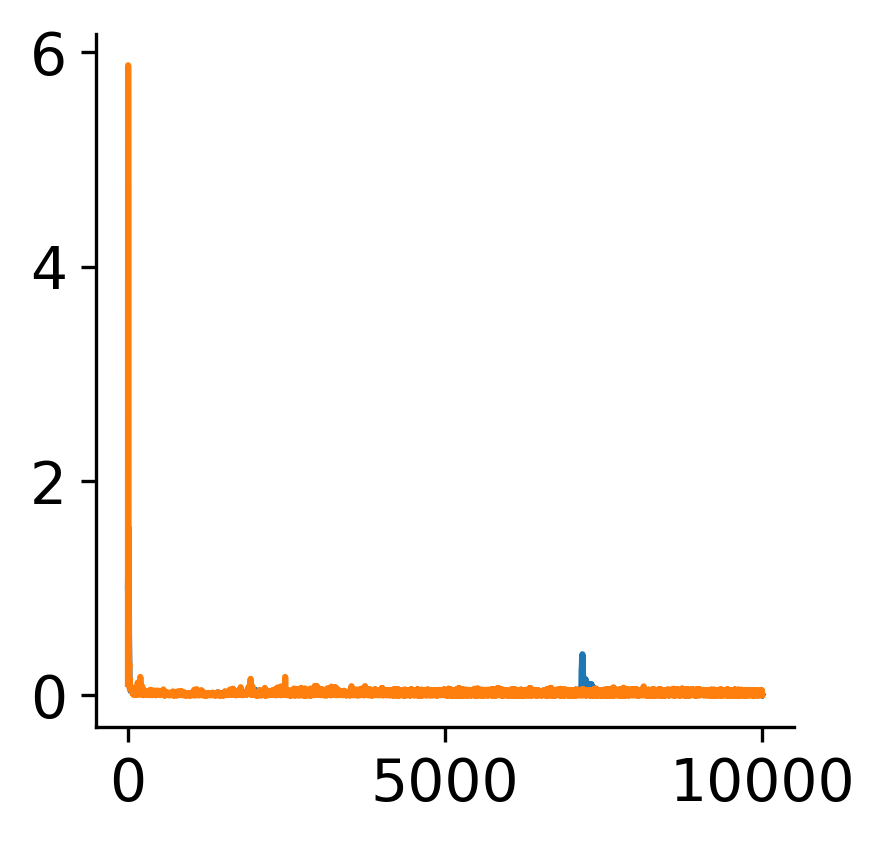

In [29]:
freeze_rnn_losses = rnn_lossesFreeze[0] + rnn_lossesFreeze2[0]
rnn_losses = smooth(rnn_losses[0], 20)
#freeze_rnn_losses = smooth(freeze_rnn_losses[0], 20)

plt.plot(rnn_losses)
plt.plot(freeze_rnn_losses)

In [30]:

print(len(rnn_lossesFreeze2[0]))
freeze_rnn_losses = rnn_lossesFreeze[0] + rnn_lossesFreeze2[0]
print(len(rnn_losses))
print(len(freeze_rnn_losses))

5000
10000
10000


In [31]:
# Check the distribution of cues
unique_cues, counts = np.unique(cues, return_counts=True)
print(f"Cue counts: {dict(zip(unique_cues, counts))}")


Cue counts: {0: 2447, 1: 2496, 2: 1203, 3: 1288, 4: 1301, 5: 1265}


In [32]:
cues_p1 = []
for trial in p1.trials:
    cue_sums = trial[:, :-1].sum(axis=0)
    active_cue = np.where(cue_sums > 0)[0][0]
    cues_p1.append(active_cue)

cues_p2 = []
for trial in p2.trials:
    cue_sums = trial[:, :-1].sum(axis=0)
    active_cue = np.where(cue_sums > 0)[0][0]
    cues_p2.append(active_cue)

print("Cues in p1:", np.unique(cues_p1, return_counts=True))
print("Cues in p2:", np.unique(cues_p2, return_counts=True))


Cues in p1: (array([0, 1, 2, 3]), array([1226, 1283, 1216, 1275]))
Cues in p2: (array([0, 1, 4, 5]), array([1278, 1241, 1277, 1204]))


In [33]:
X_exp = [trial[:, :-1] for trial in combined_block.trials]
R_exp = [trial[:, -1:] for trial in combined_block.trials]
Z_special = get_csc_representation(np.vstack(X_exp), np.vstack(R_exp), max(combined_block.reward_times) + 1)
w, Vt, rpes = TD_with_corrected_Vt(Z_special, np.vstack(R_exp), gamma, alpha)

timesteps_per_trial = [trial.shape[0] for trial in combined_block.trials]
split_points = np.cumsum(timesteps_per_trial)[:-1]

# Split the RPEs based on the determined split points
rpes_per_trial = np.split(rpes, split_points)

csc_losses = [np.mean(np.square(rpe)) for rpe in rpes_per_trial]

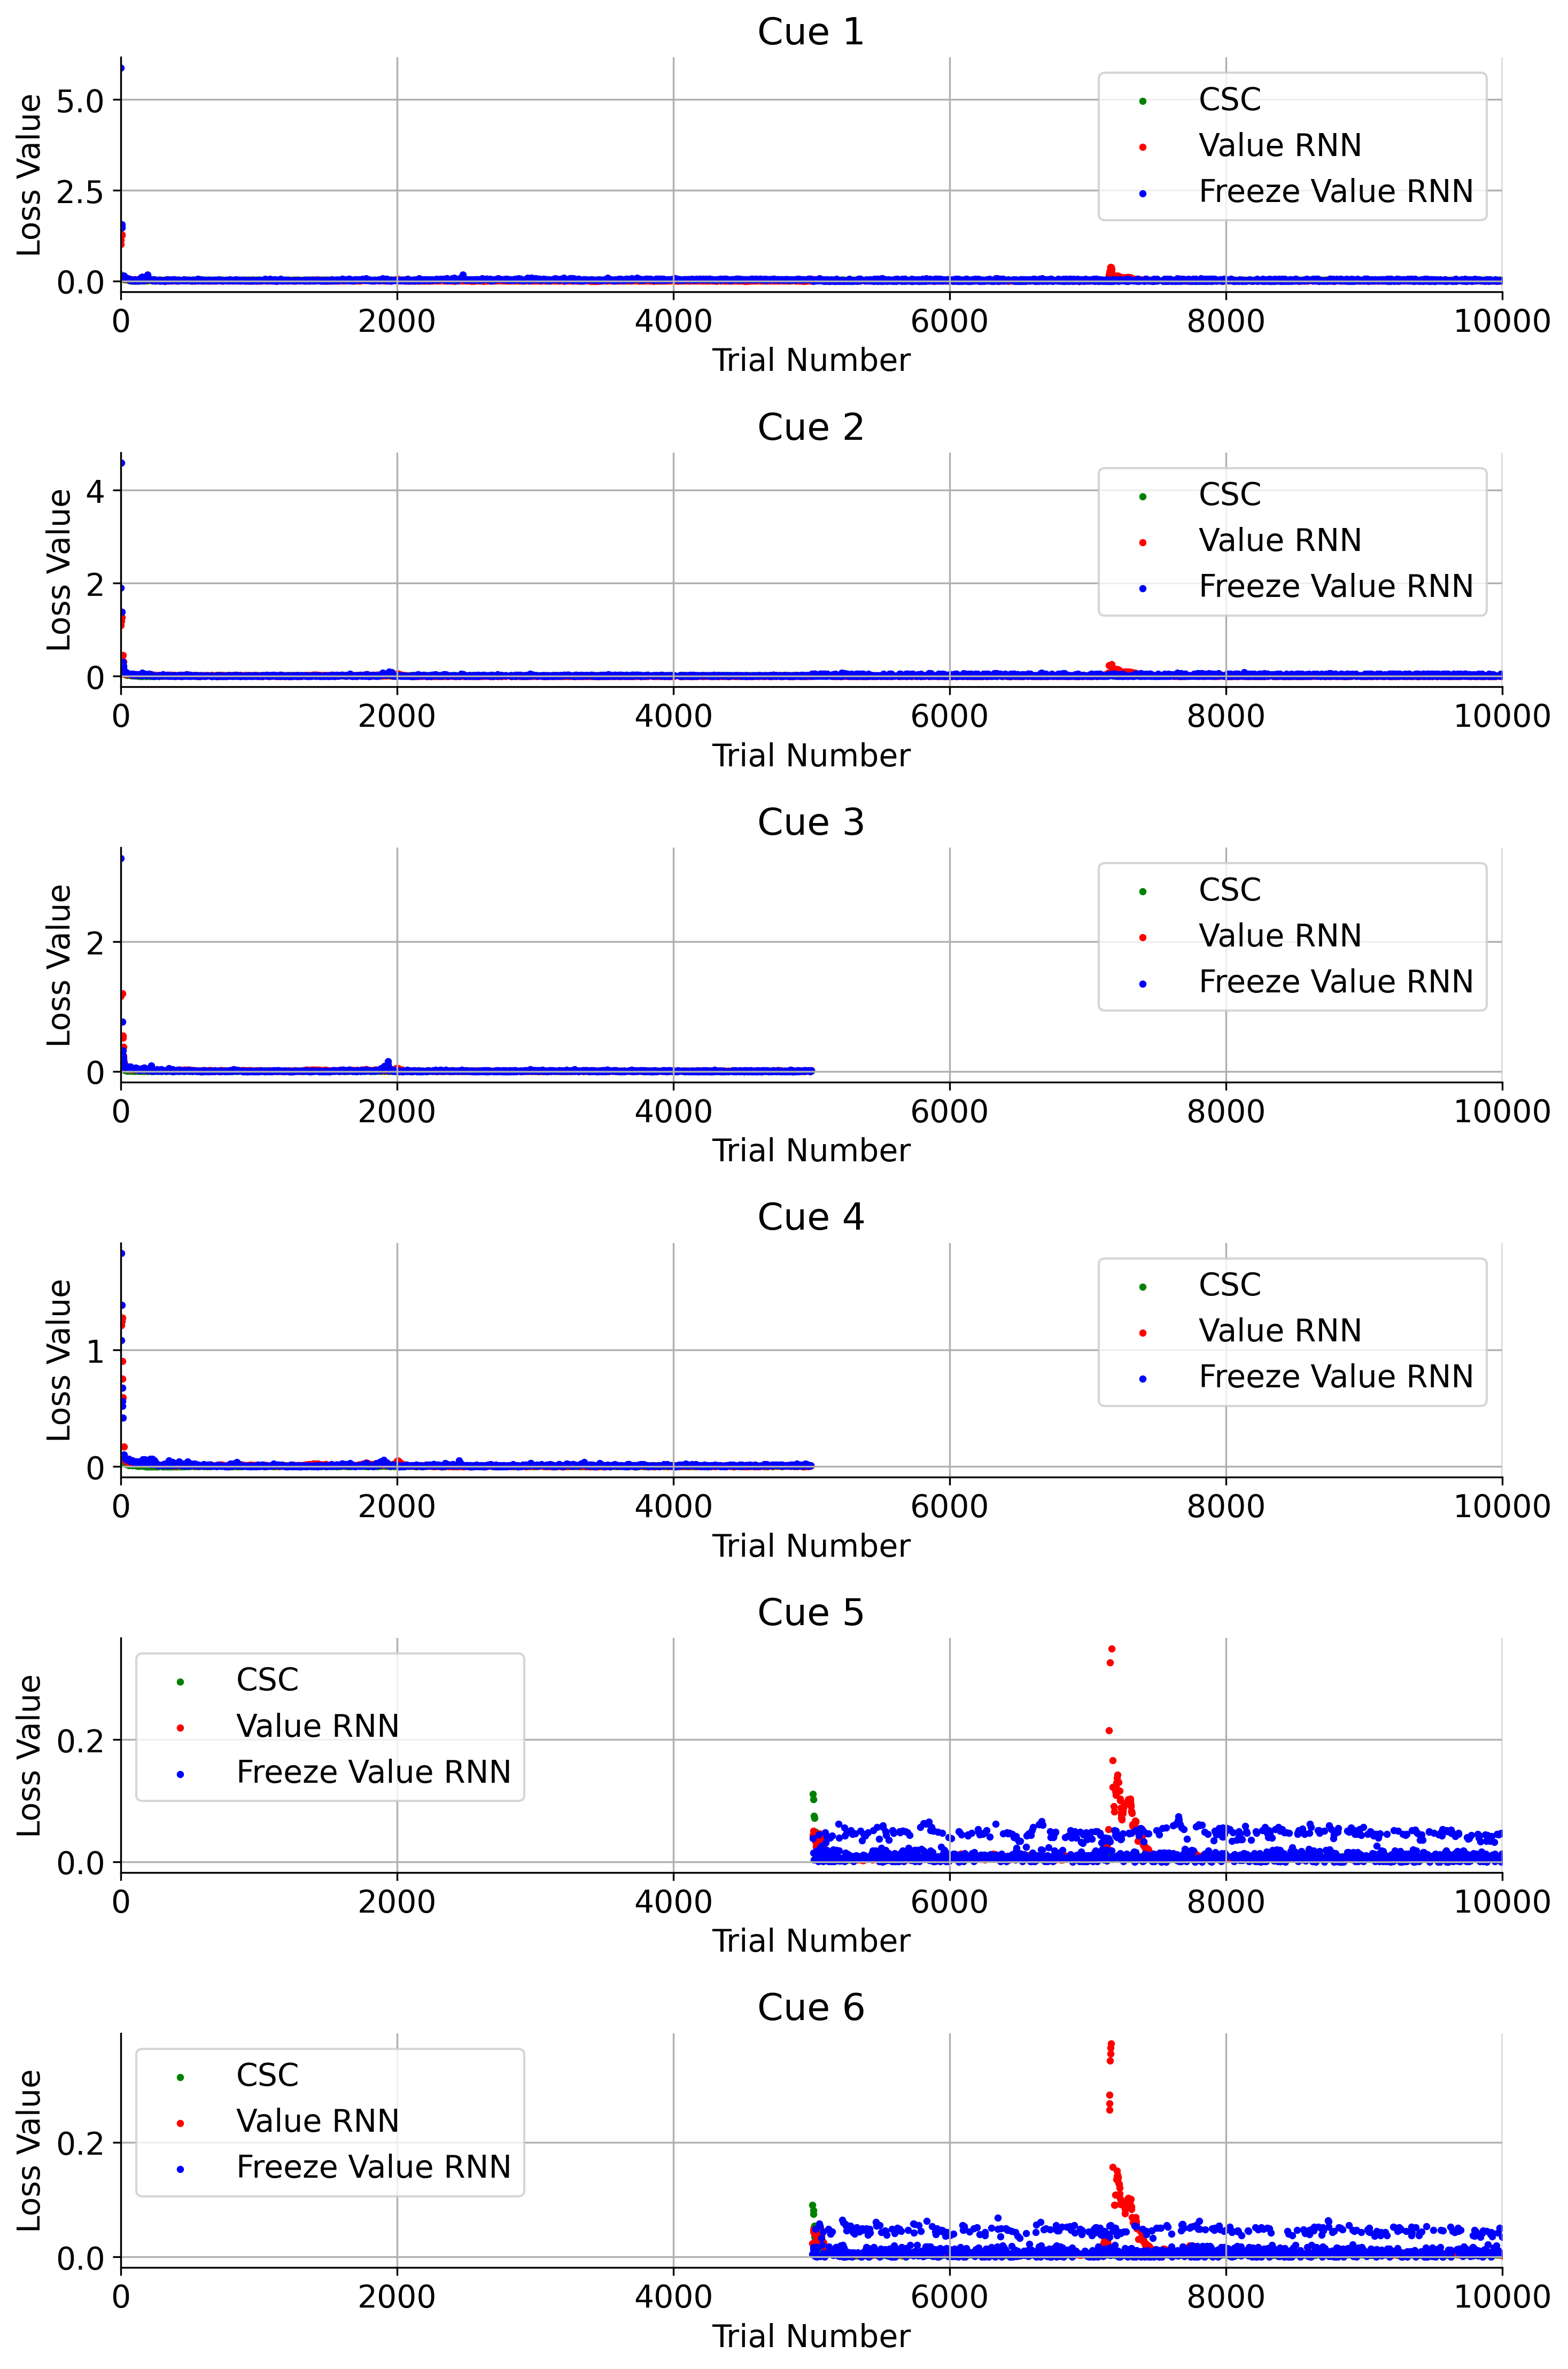

In [34]:
import numpy as np
import matplotlib.pyplot as plt

n_cues = 6
n_trials_total = 10000
cues = cues_p1 + cues_p2

x = np.arange(n_trials_total)

fig, axes = plt.subplots(nrows=n_cues, ncols=1, figsize=(10, 15))

for cue in range(n_cues):
    # Create mask for the current cue
    mask = np.array(cues) == cue

    axes[cue].scatter(x[mask], np.array(csc_losses)[mask], label='CSC', color='green', s=5)
    axes[cue].scatter(x[mask], np.array(rnn_losses)[mask], label='Value RNN', color='red', s=5)
    axes[cue].scatter(x[mask], np.array(freeze_rnn_losses)[mask], label='Freeze Value RNN', color='blue', s=5)

    axes[cue].set_xlim([0, n_trials_total]) # ensure x-axis spans all 10,000 trials
    axes[cue].set_title(f'Cue {cue + 1}')
    axes[cue].set_xlabel('Trial Number')
    axes[cue].set_ylabel('Loss Value')
    axes[cue].legend()
    axes[cue].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
trial_p1_last_tensor = torch.from_numpy(p1.trials[-1]).float().unsqueeze(0)
trial_p2_first_tensor = torch.from_numpy(p2.trials[0]).float().unsqueeze(0)

model.prepare_to_gather_activity()

model(trial_p1_last_tensor)
hidden_p1_last = model.features['hidden']

model(trial_p2_first_tensor)
hidden_p2_first = model.features['hidden']


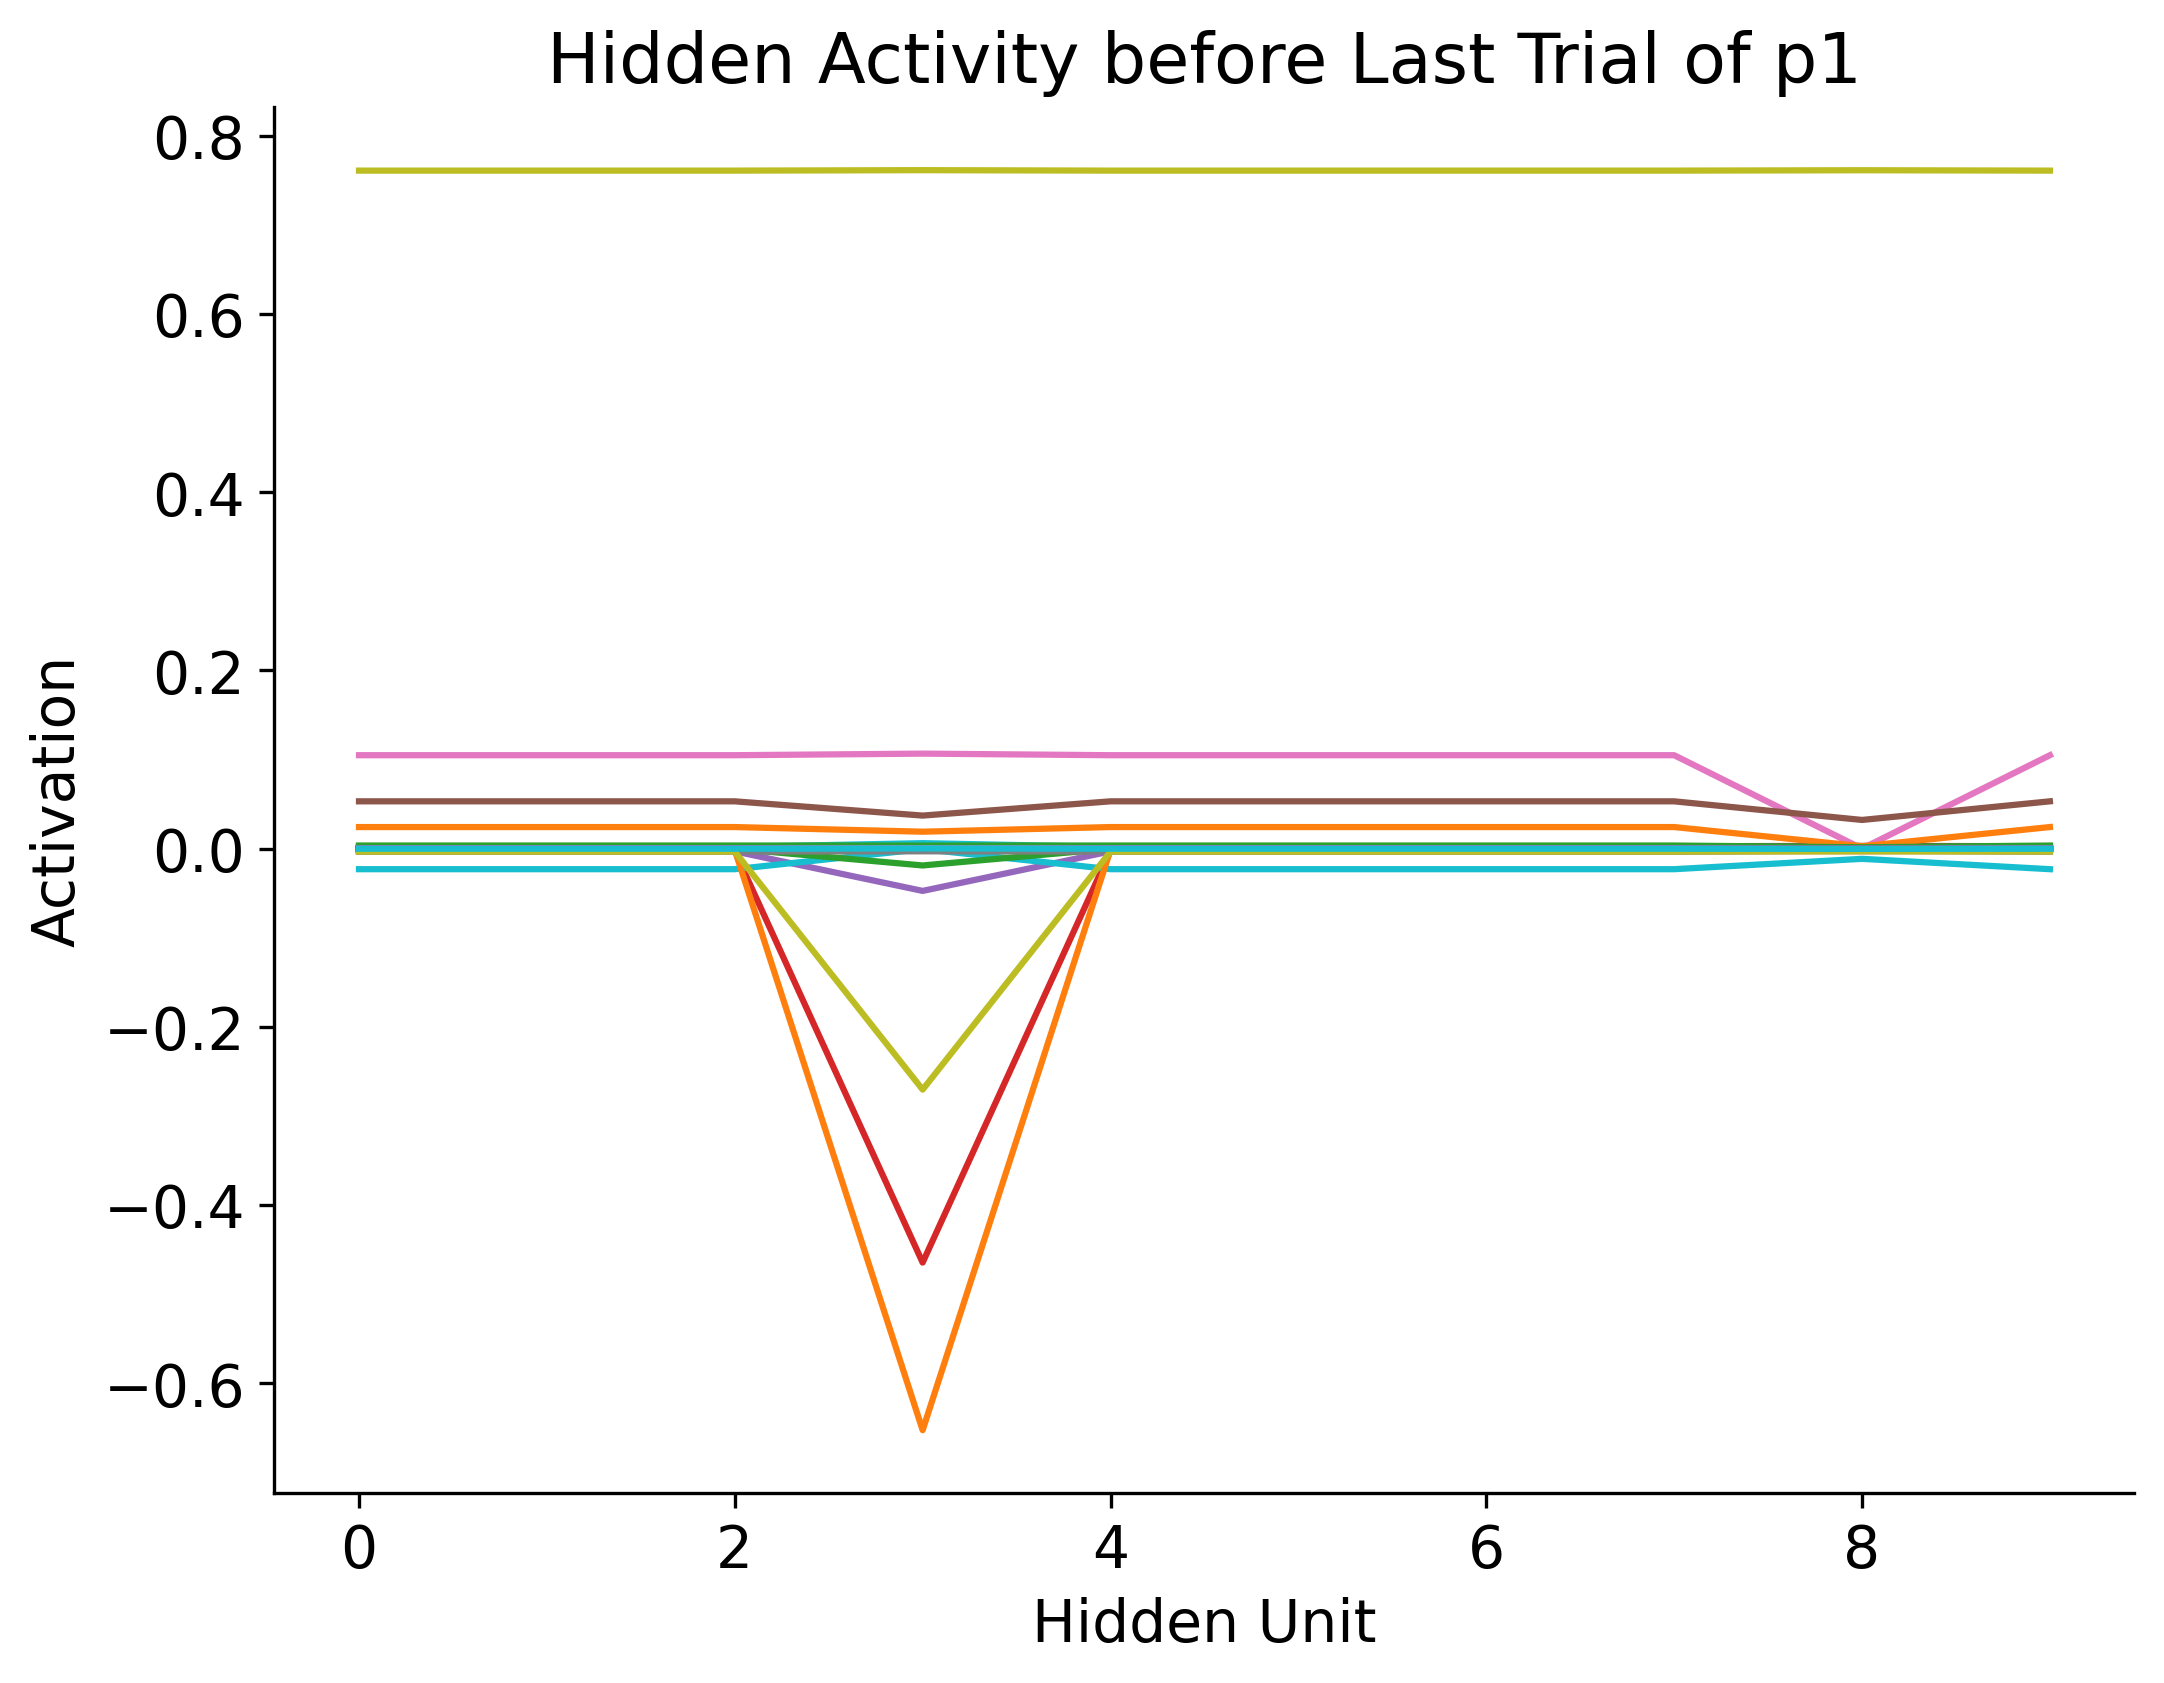

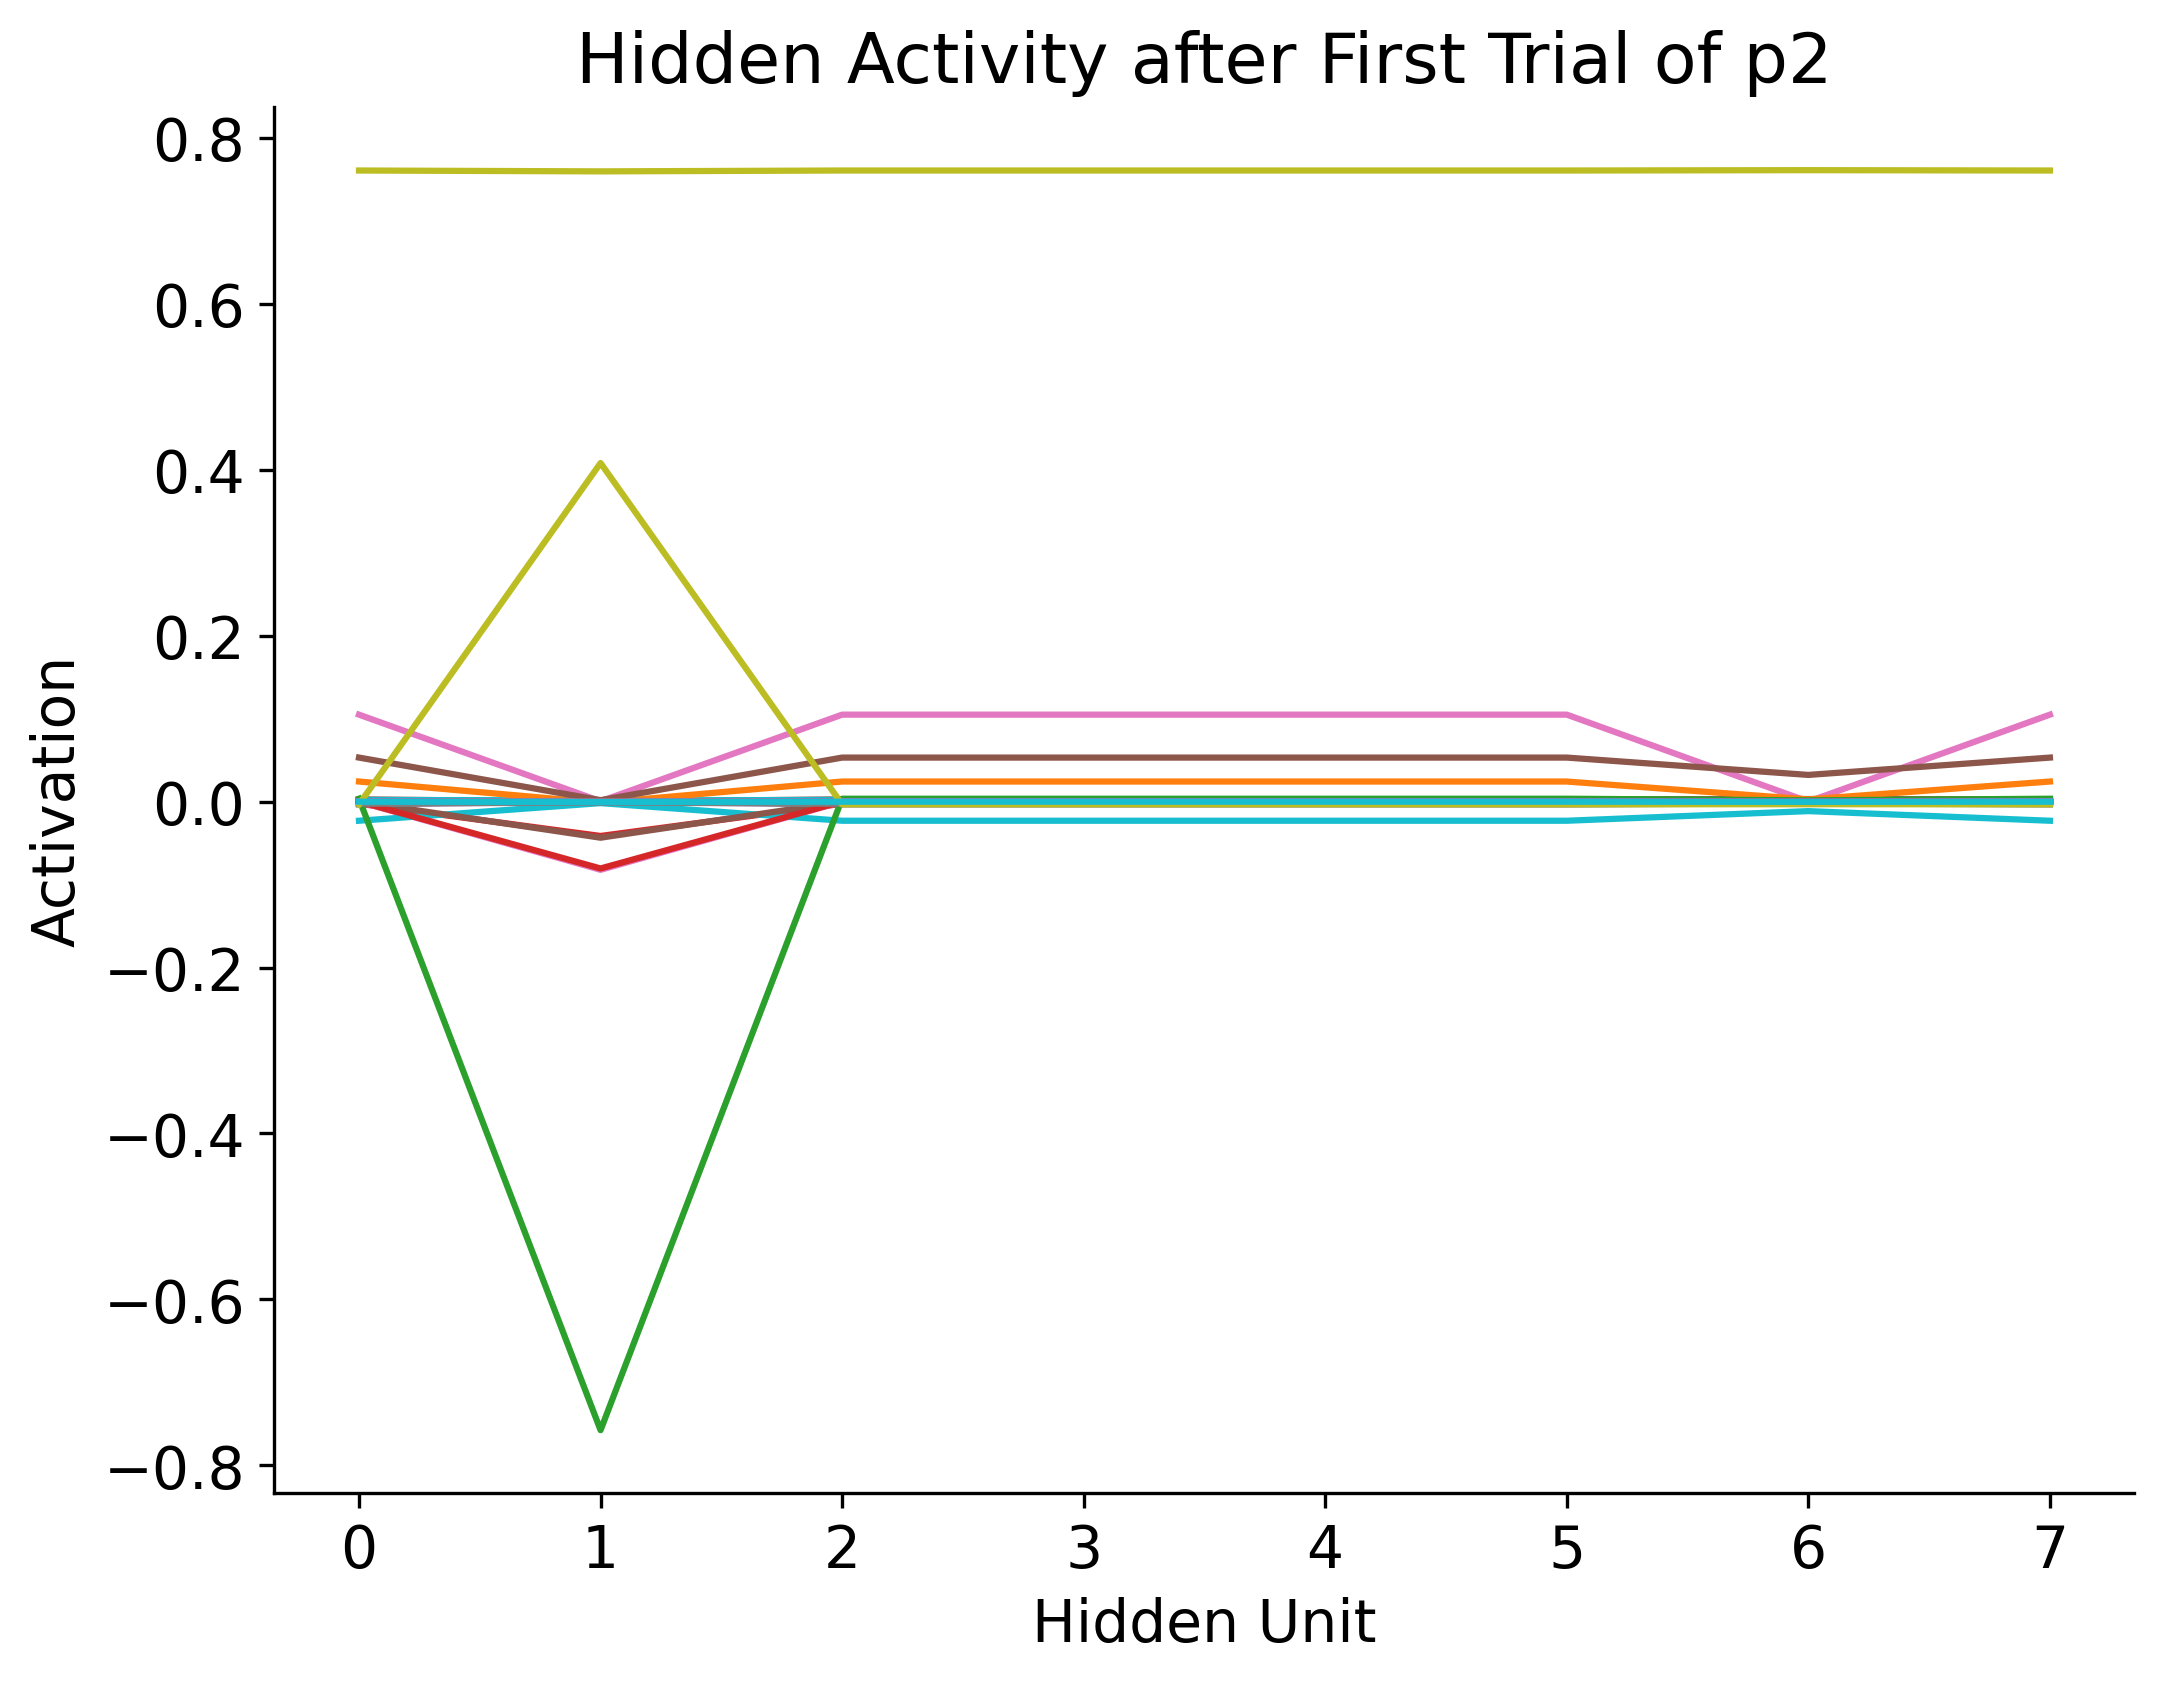

In [ ]:
def plot_hidden_activity(hidden_state, title):
    hidden_data = hidden_state[0].squeeze().detach().numpy()  # Assuming you want to visualize `hx`
    plt.figure(figsize=(8,6))
    plt.plot(hidden_data)
    plt.title(title)
    plt.xlabel('Hidden Unit')
    plt.ylabel('Activation')
    plt.show()

plot_hidden_activity(hidden_p1_last, "Hidden Activity before Last Trial of p1")
plot_hidden_activity(hidden_p2_first, "Hidden Activity after First Trial of p2")


5
2
3


In [ ]:
def plot_hidden_activity(responses, key='Z', align_offset=1):
    num_cues = max([trial['cue'] for trial in responses]) + 1
    clrs = COLORS[:num_cues]
    #clrs = COLORS[:responses[0]['X'].shape[1]]
    msz = 5
    for trial in responses:
        t_stim = trial['iti']
        if trial['isi'] is not None:
            t_rew = trial['isi'] + t_stim
        else:
            t_rew = None
        clr = clrs[trial['cue'] % len(clrs)]

        Z = trial[key]

        # Plot the trajectory
        plt.plot(Z[t_stim,0], Z[t_stim,1], 's', color=clr, markersize=5)
        plt.plot(Z[:,0], Z[:,1], '.-', color=clr, markersize=msz, alpha=0.5)

        plt.annotate(f"Cue {trial['cue']}",
                     (Z[t_stim,0], Z[t_stim,1]),
                     textcoords="offset points",
                     xytext=(10,-10),
                     ha='center')

        if t_rew is not None:
            plt.plot(Z[t_rew,0], Z[t_rew,1], '*', color=clr, markersize=5)
        # plt.plot(Z[trial.iti+1+align_offset,0], Z[trial.iti+1+align_offset,1], '*', markersize=6, color=h.get_color())
    plt.plot(0, 0, 'k+')
    plt.xlabel('$z_1$')
    plt.ylabel('$z_2$')
    plt.gca().set_xticks([]);
    plt.gca().set_yticks([]);
    plt.axis('equal')
    plt.show()

    plt.xlabel('time $\\rightarrow$')
    plt.ylabel(key)
    plt.yticks(ticks=[], labels=[])
    plt.gca().spines.get('left').set_visible(False)
    plt.show()


(7, 7)
(6, 7)
torch.Size([1, 7, 7])
torch.Size([1, 6, 7])


In [ ]:
from sklearn.decomposition import PCA

all_hidden_states = []

for trial in combined_block.trials:
    trial_tensor = torch.from_numpy(trial).float().unsqueeze(0)
    model.prepare_to_gather_activity()
    _, _ = model(trial_tensor)
    hidden_trial = model.features['hidden'][0]
    all_hidden_states.append(hidden_trial.detach().numpy())

# Reshape
all_hidden_states_matrix = np.vstack([state.reshape(state.shape[0]*state.shape[1], -1) for state in all_hidden_states])

pca = PCA(n_components=2)
pca.fit(all_hidden_states_matrix)


PCA(n_components=2)

In [ ]:
last_15_trials = p1.trials[-15:]

# cues for the last 15 trials
last_15_cues = [np.where(trial[:, :-1] == 1)[0][0] for trial in last_15_trials]
unique_cue_indices = []
seen_cues = set()

for idx, trial in enumerate(last_15_trials):
    iti_trial = np.where(trial[:, :-1] == 1)[0][0]
    cue_number_trial = np.where(trial[iti_trial, :-1] == 1)[0][0]

    if cue_number_trial not in seen_cues:
        unique_cue_indices.append(idx)
        seen_cues.add(cue_number_trial)

for idx in unique_cue_indices:
    trial = last_15_trials[idx]
    iti_trial = np.where(trial[:, :-1] == 1)[0][0]
    cue_number_trial = np.where(trial[iti_trial, :-1] == 1)[0][0]
    print(cue_number_trial)


0
2
1
3


In [ ]:
responses = []

for idx in unique_cue_indices:
    trial_tensor = torch.from_numpy(last_15_trials[idx]).float().unsqueeze(0)
    model.prepare_to_gather_activity()
    _, _ = model(trial_tensor)
    hidden_trial = model.features['hidden'][0]

    pca_trial_result = pca.transform(hidden_trial.detach().numpy().reshape(hidden_trial.shape[0]*hidden_trial.shape[1], -1))
    pca_trial_result = pca_trial_result.reshape(hidden_trial.shape[0], hidden_trial.shape[1], 2)

    iti_trial = np.where(last_15_trials[idx][:, :-1] == 1)[0][0]
    cue_number_trial = np.where(last_15_trials[idx][iti_trial, :-1] == 1)[0][0]
    if cue_number_trial in p1.reward_times:
        isi_trial = p1.reward_times[cue_number_trial]
    else:
        isi_trial = None

    trial_response = {
        'iti': iti_trial,
        'cue': cue_number_trial,
        'isi': isi_trial,
        'Z': pca_trial_result[0]
    }
    responses.append(trial_response)


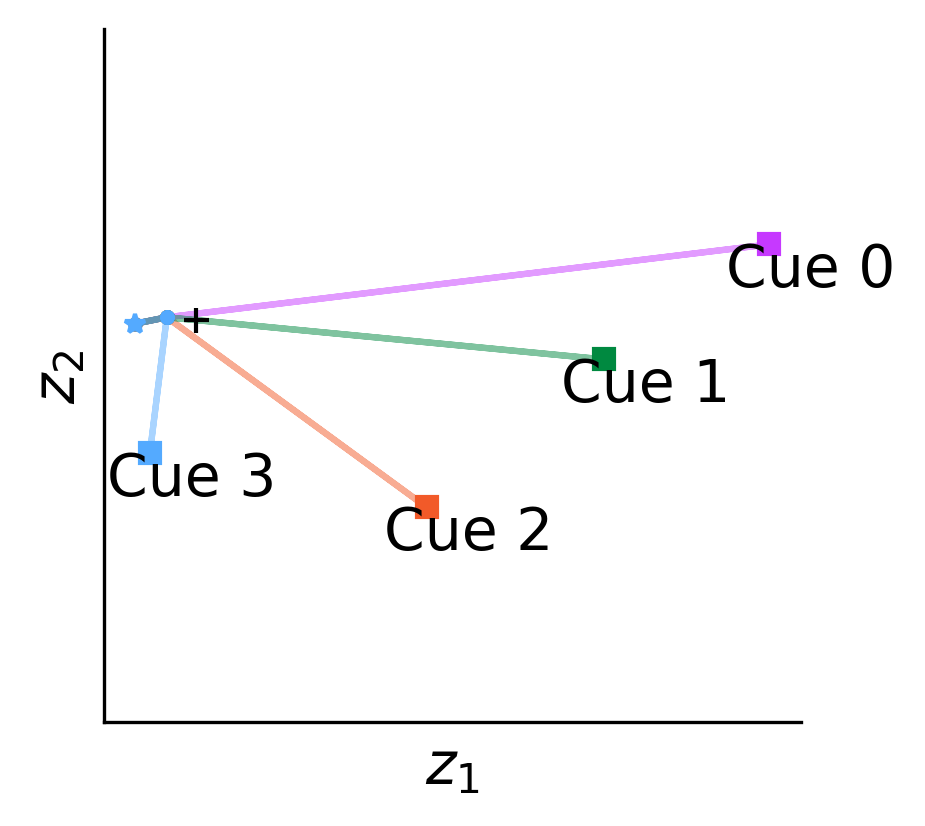

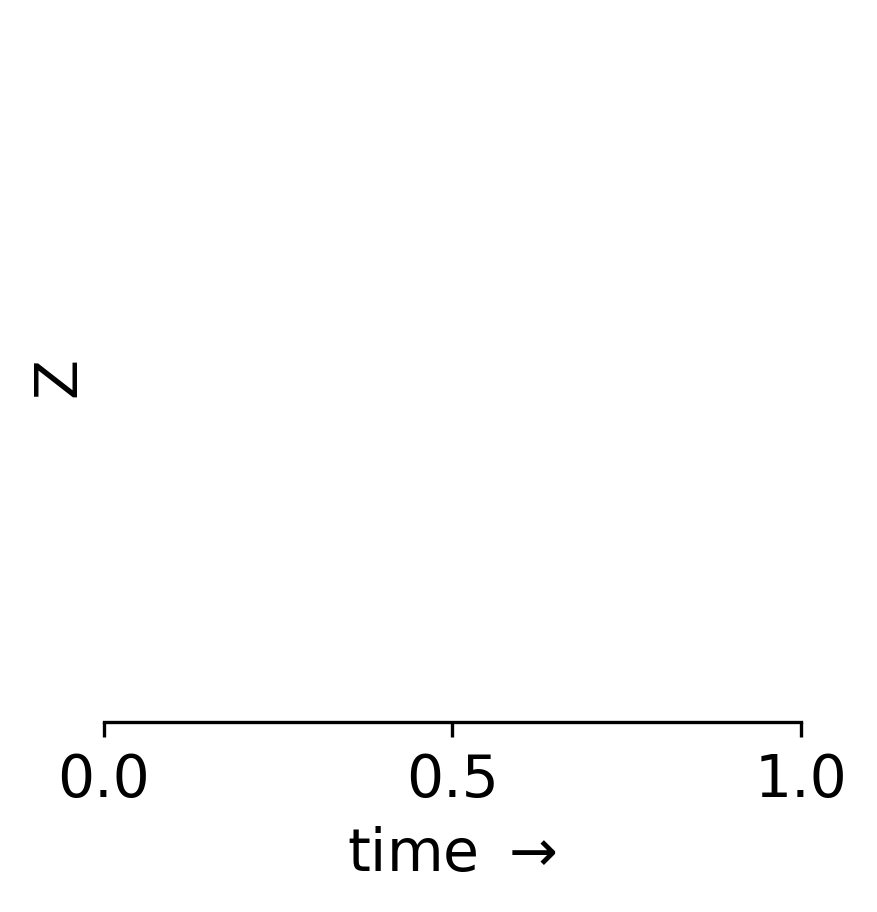

In [ ]:
plot_hidden_activity(responses)


5
4
1
0


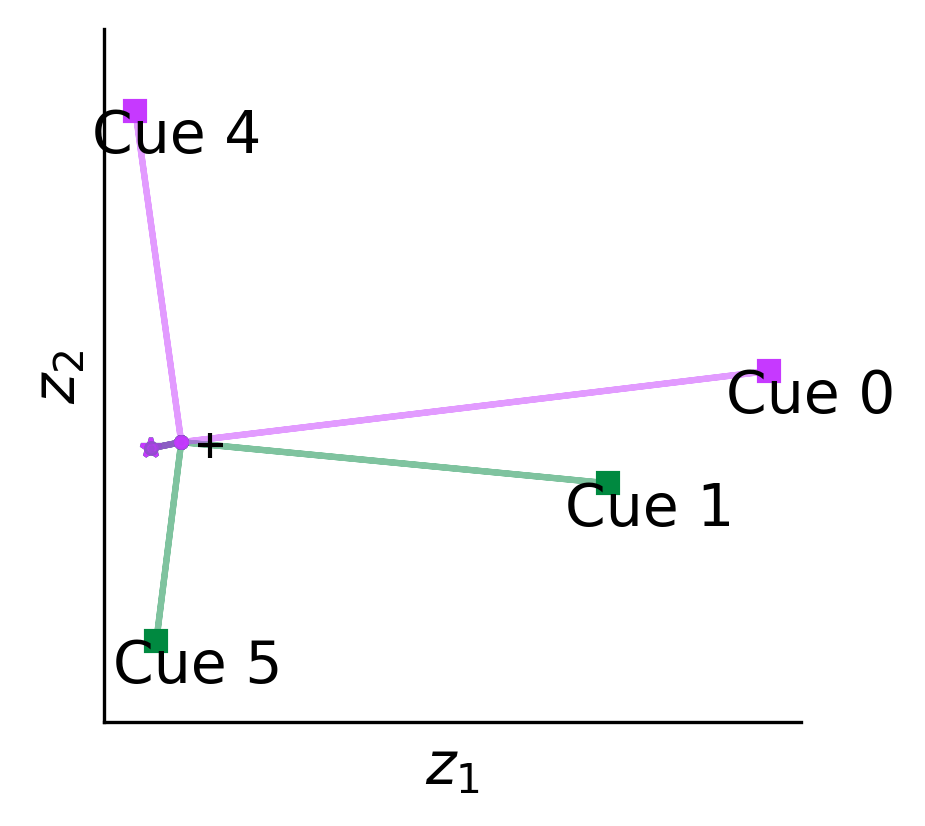

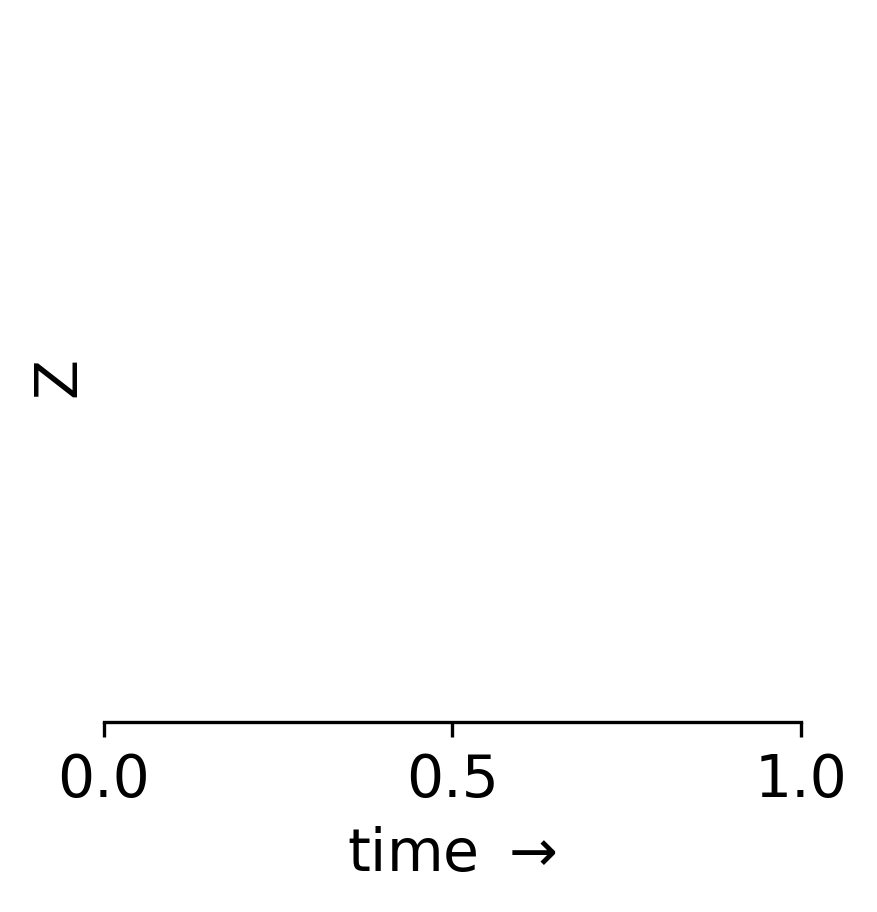

In [ ]:

last_few_trials_p2 = p2.trials[-10:]

# cues for the last 15 trials of block 2
last_few_cues_p2 = [np.where(trial[:, :-1] == 1)[0][0] for trial in last_few_trials_p2]

unique_cue_indices_p2 = []
seen_cues_p2 = set()

for idx, trial in enumerate(last_few_trials_p2):
    iti_trial_p2 = np.where(trial[:, :-1] == 1)[0][0]
    cue_number_trial_p2 = np.where(trial[iti_trial_p2, :-1] == 1)[0][0]

    if cue_number_trial_p2 not in seen_cues_p2:
        unique_cue_indices_p2.append(idx)
        seen_cues_p2.add(cue_number_trial_p2)

for idx in unique_cue_indices_p2:
    trial = last_few_trials_p2[idx]
    iti_trial_p2 = np.where(trial[:, :-1] == 1)[0][0]
    cue_number_trial_p2 = np.where(trial[iti_trial_p2, :-1] == 1)[0][0]
    print(cue_number_trial_p2)
responses_p2 = []
for idx in unique_cue_indices_p2:
    trial_tensor_p2 = torch.from_numpy(last_few_trials_p2[idx]).float().unsqueeze(0)
    model.prepare_to_gather_activity()
    _, _ = model(trial_tensor_p2)
    hidden_trial_p2 = model.features['hidden'][0]
    pca_trial_result_p2 = pca.transform(hidden_trial_p2.detach().numpy().reshape(hidden_trial_p2.shape[0]*hidden_trial_p2.shape[1], -1))
    pca_trial_result_p2 = pca_trial_result_p2.reshape(hidden_trial_p2.shape[0], hidden_trial_p2.shape[1], 2)

    iti_trial_p2 = np.where(last_few_trials_p2[idx][:, :-1] == 1)[0][0]
    cue_number_trial_p2 = np.where(last_few_trials_p2[idx][iti_trial_p2, :-1] == 1)[0][0]
    if cue_number_trial_p2 in p2.reward_times:
        isi_trial_p2 = p2.reward_times[cue_number_trial_p2]
    else:
        isi_trial_p2 = None

    trial_response_p2 = {
        'iti': iti_trial_p2,
        'cue': cue_number_trial_p2,
        'isi': isi_trial_p2,
        'Z': pca_trial_result_p2[0]
    }
    responses_p2.append(trial_response_p2)
plot_hidden_activity(responses_p2)

<ipython-input-92-947561e920db>:16: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(Z[:,0], Z[:,1], '.-', color=clrs_post[trial['cue']], markersize=5, alpha=0.5, linestyle='dashed', label=f"After p2 - Cue {trial['cue']}")


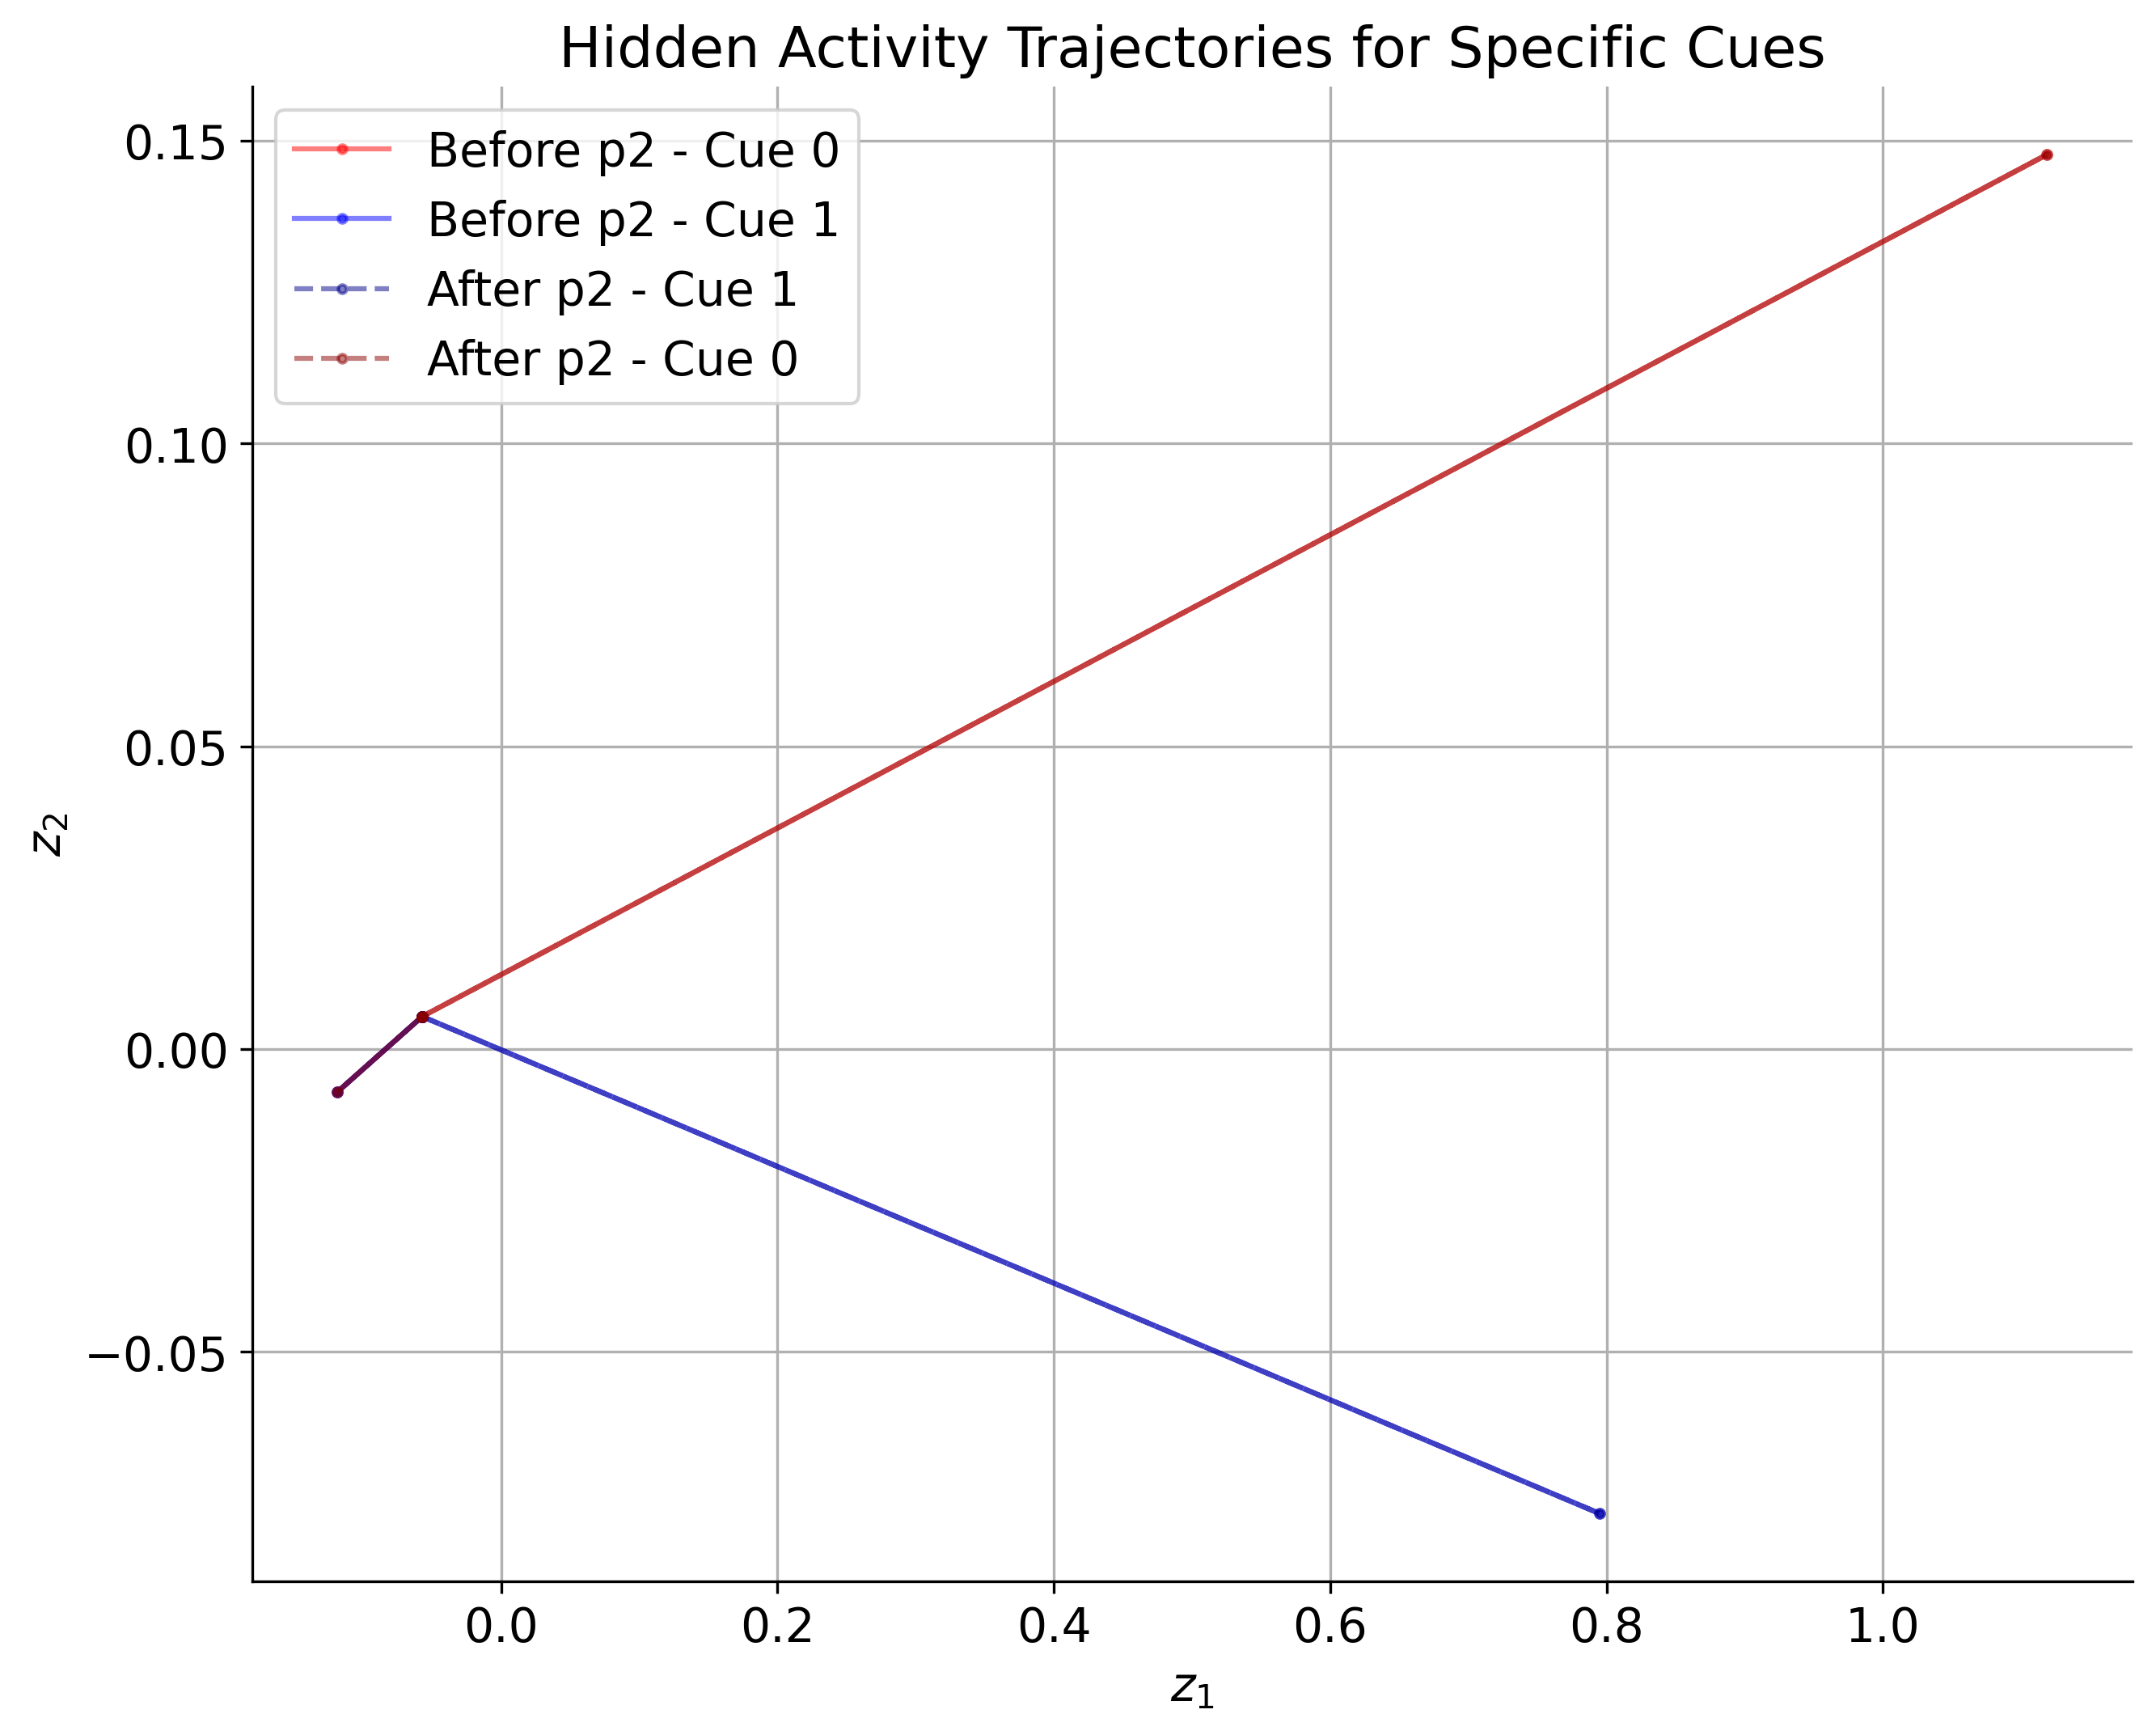

In [ ]:
def plot_comparison(responses_pre, responses_post, cue_list):
    clrs_pre = ['red', 'blue']
    clrs_post = ['darkred', 'darkblue']
    plt.figure(figsize=(10,8))

    for trial in responses_pre:
        if trial['cue'] in cue_list:
            Z = trial['Z']
            plt.plot(Z[:,0], Z[:,1], '.-', color=clrs_pre[trial['cue']], markersize=5, alpha=0.5, label=f"Before p2 - Cue {trial['cue']}")

    # for after p2
    for trial in responses_post:
        if trial['cue'] in cue_list:
            Z = trial['Z']
            plt.plot(Z[:,0], Z[:,1], '.-', color=clrs_post[trial['cue']], markersize=5, alpha=0.5, linestyle='dashed', label=f"After p2 - Cue {trial['cue']}")

    plt.xlabel('$z_1$')
    plt.ylabel('$z_2$')
    plt.title('Hidden Activity Trajectories for Specific Cues')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_comparison(responses, responses_p2, [0, 1])


In [ ]:
def plot_hidden_activity_3D(responses, key='Z', align_offset=1):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    num_cues = max([trial['cue'] for trial in responses]) + 1
    clrs = COLORS[:num_cues]
    msz = 5
    for trial in responses:
        t_stim = trial['iti']
        if trial['isi'] is not None:
            t_rew = trial['isi'] + t_stim
        else:
            t_rew = None
        clr = clrs[trial['cue'] % len(clrs)]
        Z = trial[key]

        # Plot the trajectory in 3D
        ax.plot(Z[:,0], Z[:,1], Z[:,2], '.-', color=clr, markersize=msz, alpha=0.5)
        ax.scatter(Z[t_stim,0], Z[t_stim,1], Z[t_stim,2], color=clr, s=50, depthshade=True)

        ax.text(Z[t_stim,0], Z[t_stim,1], Z[t_stim,2], f"Cue {trial['cue']}", size=10, zorder=1, color=clr)

        if t_rew is not None:
            ax.scatter(Z[t_rew,0], Z[t_rew,1], Z[t_rew,2], color=clr, s=100, marker='*', depthshade=True)

    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.show()


In [ ]:
all_hidden_states = []

for trial in combined_block.trials:
    trial_tensor = torch.from_numpy(trial).float().unsqueeze(0)
    model.prepare_to_gather_activity()
    _, _ = model(trial_tensor)
    hidden_trial = model.features['hidden'][0]
    all_hidden_states.append(hidden_trial.detach().numpy())

# Reshape
all_hidden_states_matrix = np.vstack([state.reshape(state.shape[0]*state.shape[1], -1) for state in all_hidden_states])

pca = PCA(n_components=3)
pca.fit(all_hidden_states_matrix)

PCA(n_components=3)

In [ ]:
responses = []

for idx in unique_cue_indices:
    trial_tensor = torch.from_numpy(last_15_trials[idx]).float().unsqueeze(0)
    model.prepare_to_gather_activity()
    _, _ = model(trial_tensor)
    hidden_trial = model.features['hidden'][0]

    pca_trial_result = pca.transform(hidden_trial.detach().numpy().reshape(hidden_trial.shape[0]*hidden_trial.shape[1], -1))
    pca_trial_result = pca_trial_result.reshape(hidden_trial.shape[0], hidden_trial.shape[1], 3) # Change 2 to 3 for 3D

    iti_trial = np.where(last_15_trials[idx][:, :-1] == 1)[0][0]
    cue_number_trial = np.where(last_15_trials[idx][iti_trial, :-1] == 1)[0][0]
    if cue_number_trial in p1.reward_times:
        isi_trial = p1.reward_times[cue_number_trial]
    else:
        isi_trial = None

    trial_response = {
        'iti': iti_trial,
        'cue': cue_number_trial,
        'isi': isi_trial,
        'Z': pca_trial_result[0]
    }
    responses.append(trial_response)
responses_p2 = []
for idx in unique_cue_indices_p2:
    trial_tensor_p2 = torch.from_numpy(last_few_trials_p2[idx]).float().unsqueeze(0)
    model.prepare_to_gather_activity()
    _, _ = model(trial_tensor_p2)
    hidden_trial_p2 = model.features['hidden'][0]
    pca_trial_result_p2 = pca.transform(hidden_trial_p2.detach().numpy().reshape(hidden_trial_p2.shape[0]*hidden_trial_p2.shape[1], -1))
    pca_trial_result_p2 = pca_trial_result_p2.reshape(hidden_trial_p2.shape[0], hidden_trial_p2.shape[1], 3)

    iti_trial_p2 = np.where(last_few_trials_p2[idx][:, :-1] == 1)[0][0]
    cue_number_trial_p2 = np.where(last_few_trials_p2[idx][iti_trial_p2, :-1] == 1)[0][0]
    if cue_number_trial_p2 in p2.reward_times:
        isi_trial_p2 = p2.reward_times[cue_number_trial_p2]
    else:
        isi_trial_p2 = None

    trial_response_p2 = {
        'iti': iti_trial_p2,
        'cue': cue_number_trial_p2,
        'isi': isi_trial_p2,
        'Z': pca_trial_result_p2[0]
    }
    responses_p2.append(trial_response_p2)

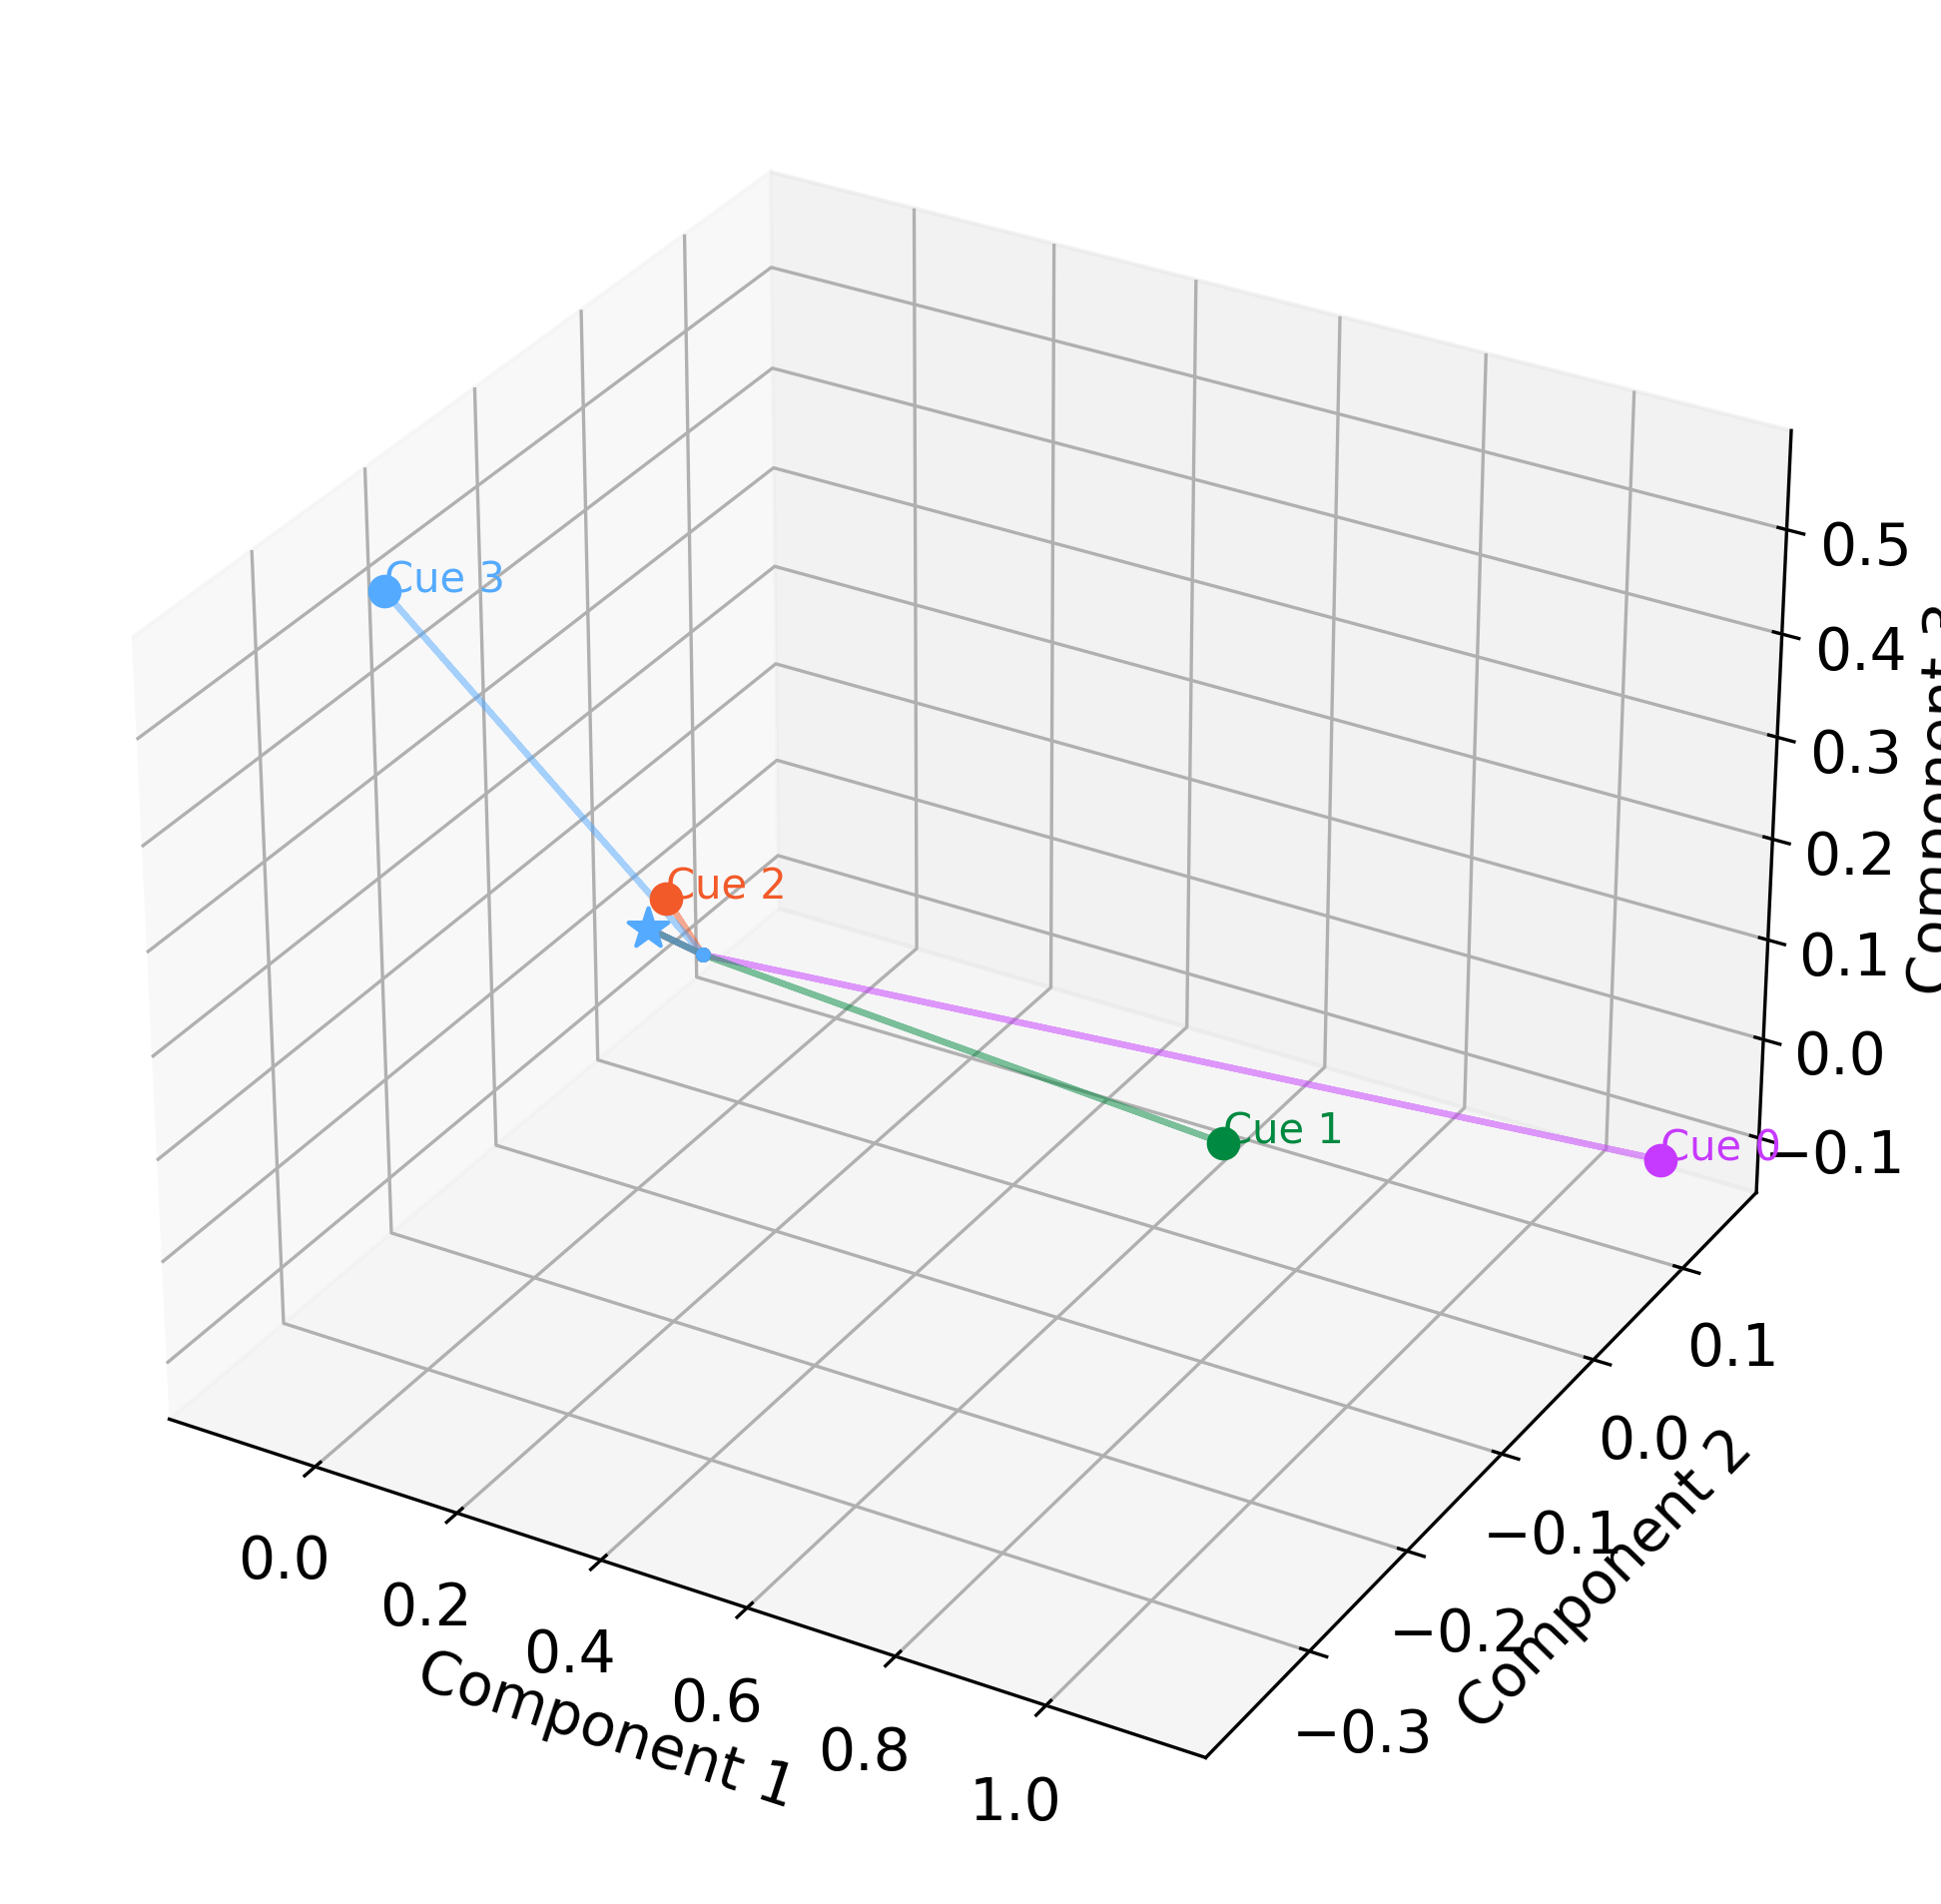

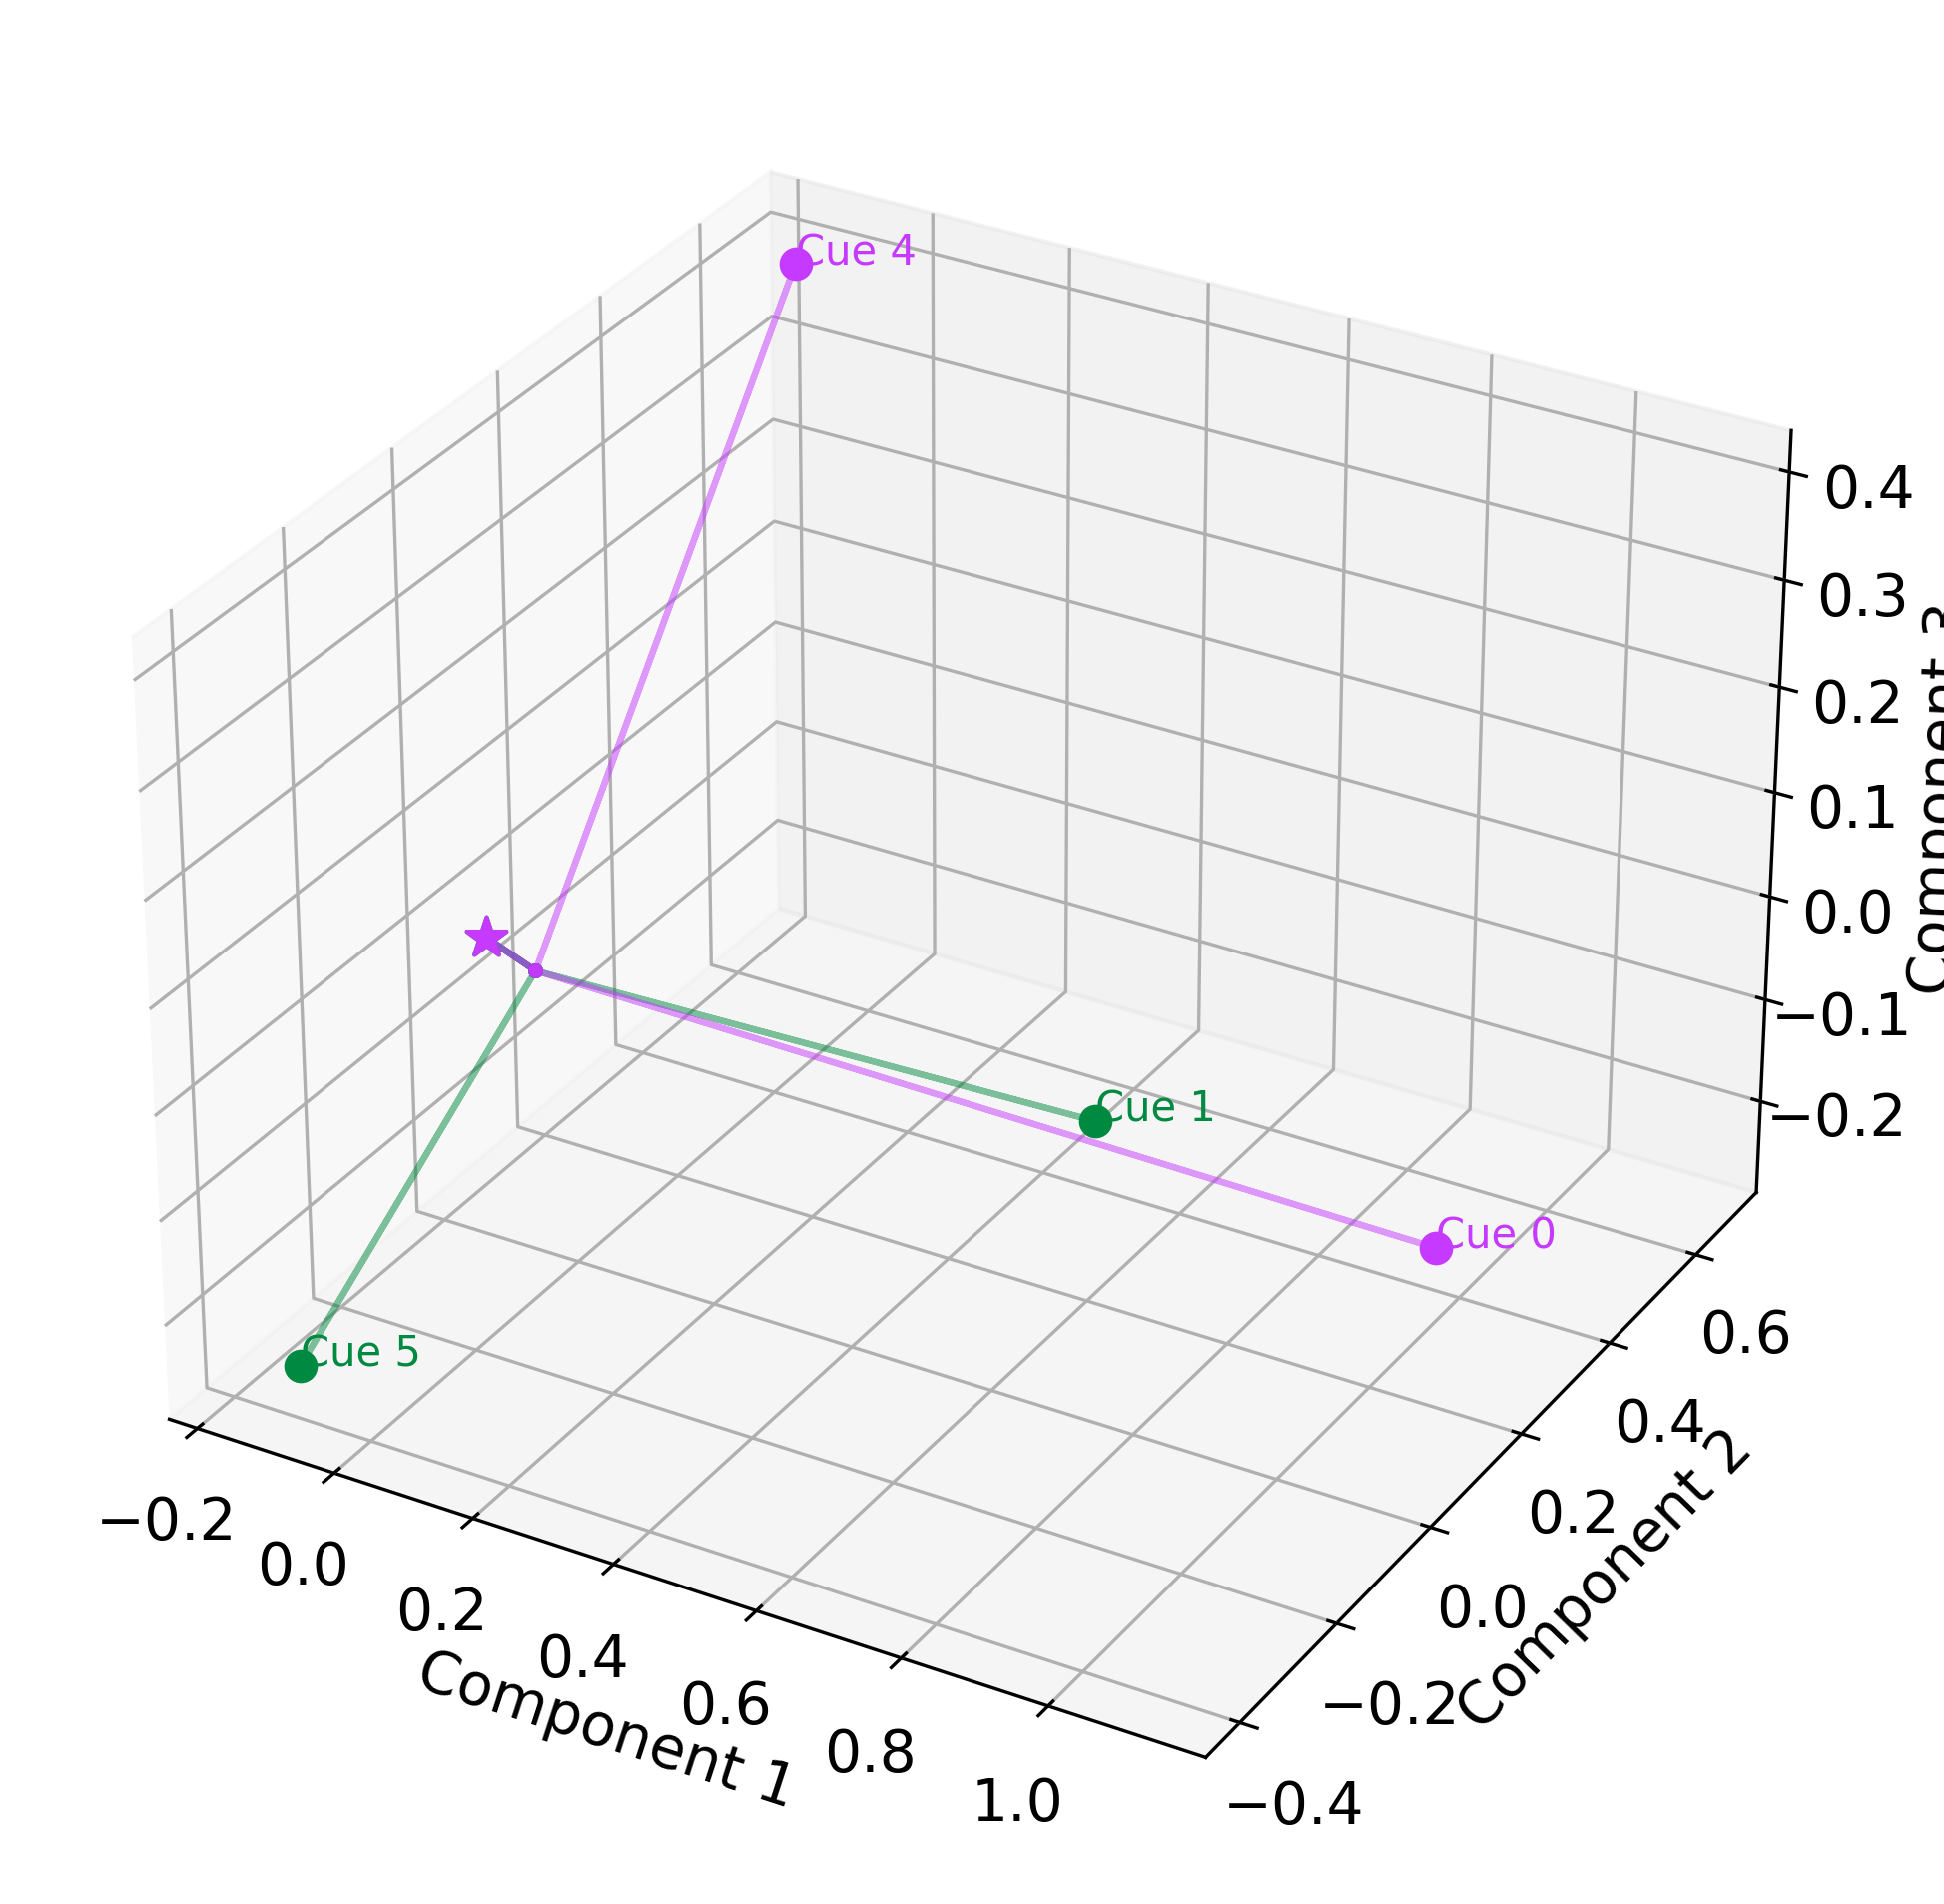

In [ ]:
plot_hidden_activity_3D(responses)
plot_hidden_activity_3D(responses_p2)

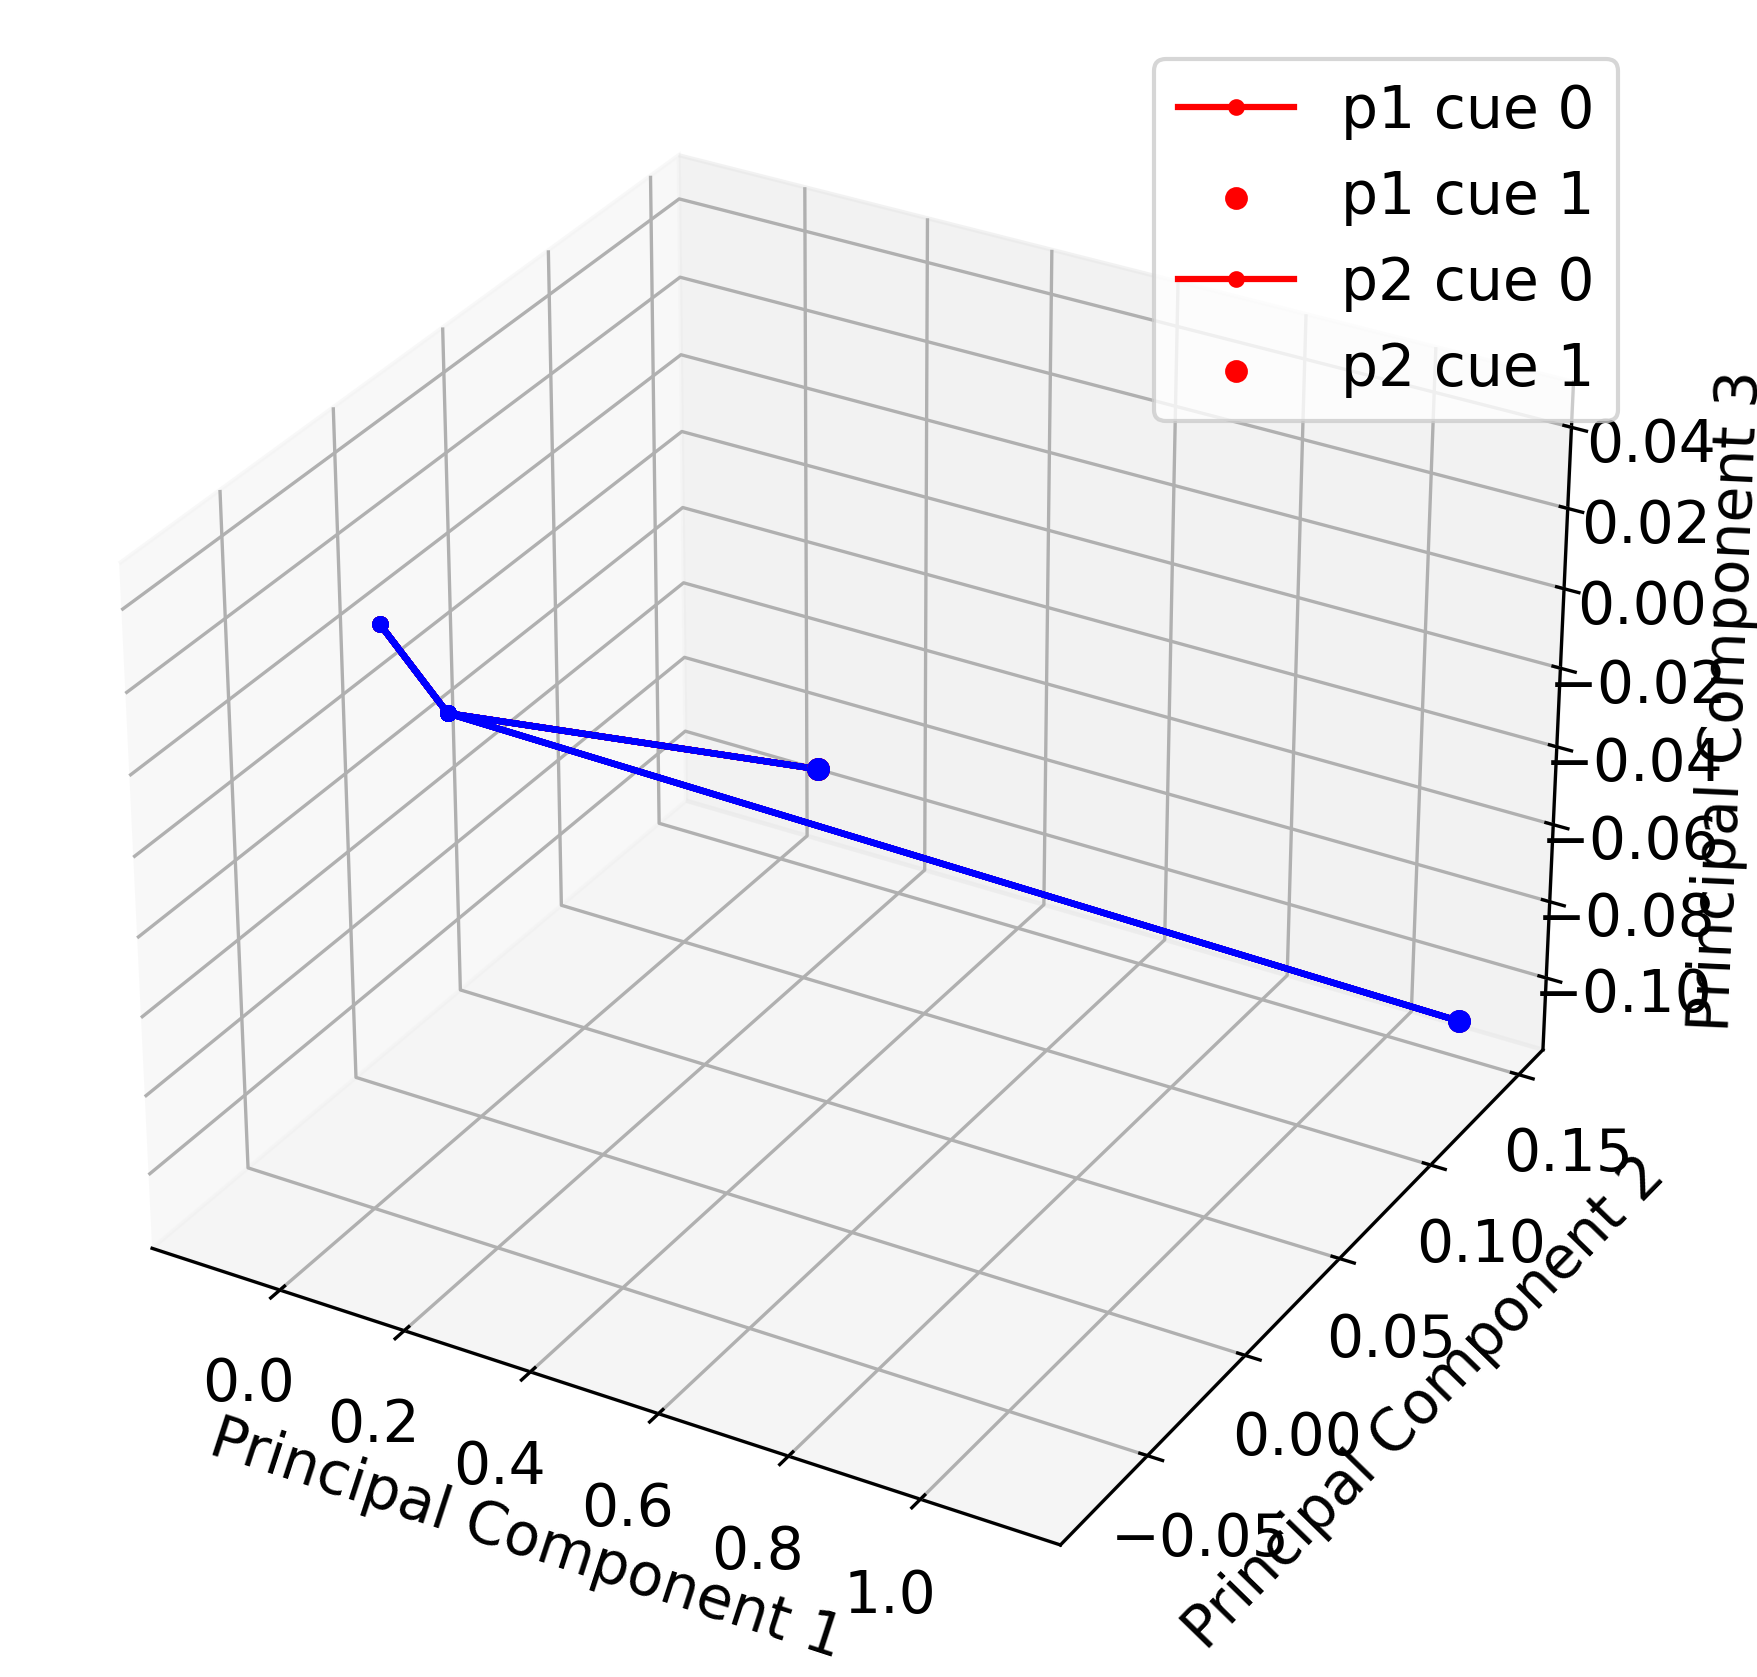

In [ ]:
def get_trajectory(trials, cue, model, pca):
    responses = []
    for idx in range(len(trials)):
        trial_tensor = torch.from_numpy(trials[idx]).float().unsqueeze(0)
        model.prepare_to_gather_activity()
        _, _ = model(trial_tensor)
        hidden_trial = model.features['hidden'][0]

        pca_trial_result = pca.transform(hidden_trial.detach().numpy().reshape(hidden_trial.shape[0]*hidden_trial.shape[1], -1))
        pca_trial_result = pca_trial_result.reshape(hidden_trial.shape[0], hidden_trial.shape[1], 3)

        iti_trial = np.where(trials[idx][:, :-1] == 1)[0][0]
        cue_number_trial = np.where(trials[idx][iti_trial, :-1] == 1)[0][0]
        if cue_number_trial == cue:
            if cue_number_trial in p1.reward_times:
                isi_trial = p1.reward_times[cue_number_trial]
            else:
                isi_trial = None

            trial_response = {
                'iti': iti_trial,
                'cue': cue_number_trial,
                'isi': isi_trial,
                'Z': pca_trial_result[0]
            }
            responses.append(trial_response)
    return responses


responses_p1_cue0 = get_trajectory(last_15_trials, 0, model, pca)  # assuming last_15_trials_p1 is in scope
responses_p1_cue1 = get_trajectory(last_15_trials, 1, model, pca)
responses_p2_cue0 = get_trajectory(last_few_trials_p2, 0, model, pca)  # assuming last_few_trials_p2 is in scope
responses_p2_cue1 = get_trajectory(last_few_trials_p2, 1, model, pca)

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'b', 'g', 'y']

def plot_3d_trajectory(responses, ax, color):
    for trial in responses:
        Z = trial['Z']
        ax.plot(Z[:, 0], Z[:, 1], Z[:, 2], '.-', color=color)
        ax.scatter(Z[trial['iti'], 0], Z[trial['iti'], 1], Z[trial['iti'], 2], 's', color=color)
        if trial['isi'] is not None:
            ax.scatter(Z[trial['isi'], 0], Z[trial['isi'], 1], Z[trial['isi'], 2], '*', color=color)

plot_3d_trajectory(responses_p1_cue0, ax, colors[0])
plot_3d_trajectory(responses_p1_cue1, ax, colors[0])
plot_3d_trajectory(responses_p2_cue0, ax, colors[1])
plot_3d_trajectory(responses_p2_cue1, ax, colors[1])

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend(['p1 cue 0', 'p1 cue 1', 'p2 cue 0', 'p2 cue 1'])

plt.show()
